## Self-Driving Car Engineer Nanodegree
### Project: Advanced Lane Finding
---------------------------------------------------------------------------------------------------------------------

#### Import Packages

In [2]:
import os
import glob
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Imageio: 'ffmpeg.linux64' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg.linux64 (27.2 MB)
Downloading: 8192/28549024 bytes (0.0286720/28549024 bytes (1.0598016/28549024 bytes (2.11056768/28549024 bytes (3.7%1482752/28549024 bytes (5.2%1957888/28549024 bytes (6.9%2465792/28549024 bytes (8.6%2809856/28549024 bytes (9.8%3096576/28549024 bytes (10.83661824/28549024 bytes (12.84055040/28549024 bytes (14.24562944/28549024 bytes (16.05103616/28549024 bytes (17.95300224/28549024 bytes (18.65799936/28549024 bytes (20.36283264/28549024 bytes (22.06496256/28549024 bytes (22.86971392/28549024 bytes (24.47430144/28549024 bytes (26.07716864/28549024 bytes (27.08200192/28549024 bytes (28.78650752/28549024 bytes (30.38986624/28549024 bytes (31.59494528/28549024 bytes (33.39969664/28549024 bytes (34.910461184/28549024 bytes (36.6%10846208/28549024 bytes (38.0%11182080/28549024 bytes (39.2%11673600/28549024 b

In [3]:
# Constants
mx = 3.7/600
my = 3/180
MAX_LEN = 5

In [4]:
# Import images for camera calibration
images = glob.glob("./camera_cal/calibration*.jpg")

objpts = []
imgpts = []

# Set the size of chessboard in the calibration images (inner corners)
chessX = 9
chessY = 6
objp = np.zeros((chessX*chessY,3), np.float32)
objp[:,:2] = np.mgrid[0:chessX,0:chessY].T.reshape(-1,2)
shape = None
outDirName = 'output_images/'

for fName in images:
    # Read in image
    img = mpimg.imread(fName)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (chessX, chessY), None)
    
    if ret:
        imgpts.append(corners)
        objpts.append(objp)
    img = cv2.drawChessboardCorners(img, (chessX, chessY), corners, ret)
    iName = os.path.basename(fName)
    # Plot image for debugging
    cv2.imwrite(os.path.join(outDirName, iName), img)
    
    # Shape of most recent image
    shape = img.shape[1::-1]

ret, mtx, dist, _, _ = cv2.calibrateCamera(objpts, imgpts, shape, None, None)

In [5]:
def warper(img, src, dst):

    # Compute and apply perpective transform
    imgSize = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, imgSize, flags=cv2.INTER_NEAREST)  # keep same size as input image

    return warped

In [6]:
def pipeline(img):
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    sChannel = hls[:,:,2]
    yw = filterWhiteAndYellow(img)
    gray = cv2.cvtColor(yw, cv2.COLOR_RGB2GRAY)
    lChannel = hls[:,:,1]
    lBinary = np.zeros_like(lChannel)
    lBinary[(lChannel > 185)] = 1
    lBinary = combinedThreshold(lBinary)
    dBinary = sobelD(gray)
    #dBinary = combinedThreshold(dBinary)
    sBinary = np.zeros_like(sChannel)
    dirbinary = sobelD(sChannel, sobel_kernel=11, thresh=(1.3, 0.7))
    mgbinary = sobelMag(sChannel, sobel_kernel=3, thresh=(25, 255))
    sBinary[(mgbinary == 1) & (dirbinary == 1 )] = 1
    combined_binary = np.zeros_like(sBinary)
    combined_binary[(sBinary == 1) | (dBinary == 1) | (lBinary == 1)] = 1
    return combined_binary

In [7]:
def combinedThreshold(img, thresh=(1.2, 0.5), thresh_x=(30, 255), thresh_mag=(80,255)):
    sxbinary = sobelX(img, thresh=thresh_x)    
    dirbinary = sobelD(img, thresh=thresh)
    mgbinary = sobelMag(img, thresh=thresh_mag)
    combined = np.zeros_like(sxbinary)
    combined[(sxbinary == 1) | ((mgbinary == 1) & (dirbinary == 1))] = 1
    return combined

def sobelX(img, sobel_kernel=3, thresh=(60, 255)):
    sobelX = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    scaledX = np.uint8(255*sobelX/np.max(sobelX))
    sxbinary = np.zeros_like(sobelX)
    sxbinary[((scaledX >= thresh[0]) & (scaledX <= thresh[1]))] = 1
    return sxbinary

def sobelMag(img, sobel_kernel=9, thresh=(40, 255)):
    sobelXM = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    sobelYM = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    absSob = np.sqrt(np.square(sobelXM) + np.square(sobelYM))
    scaledSobel = np.uint8(255*absSob/np.max(absSob))
    smbinary = np.zeros_like(scaledSobel)
    smbinary[((scaledSobel >= thresh[0]) & (scaledSobel <= thresh[1]))] = 1
    return smbinary

def sobelD(img, sobel_kernel=5, thresh=(1.2, 0.5)):
    sobelXM = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    sobelYM = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    dirSob = np.arctan2(sobelYM, sobelXM)
    sdbinary = np.zeros_like(dirSob)
    sdbinary[(dirSob <= thresh[0]) & (dirSob >= thresh[1])] = 1
    return sdbinary

In [8]:
def filterWhiteAndYellow(img):
    # Mask to yellow-gray by masking for each color and combining them
    yellowLow = np.array([145, 145, 0])
    yellowHigh = np.array([255, 255, 130])
    whiteLow = np.array([198,198,195])
    white = np.array([255, 255, 255])
    yMask = cv2.inRange(img, yellowLow, yellowHigh)
    wMask = cv2.inRange(img, whiteLow, white)
    mask = cv2.add(yMask, wMask)
    img = cv2.bitwise_and(img, img, mask=mask)
    return img

In [9]:
def measure_curvature(y_eval, fit):
    '''
    Calculates the curvature of polynomial functions.
    '''    
    # Calculation of R_curve (radius of curvature)
    a = fit[0] * mx / (my**2)
    b = fit[1] * mx / my
    curverad = ((1 + (2*a*y_eval + b)**2)**1.5) / np.absolute(2*a)
    return curverad


In [10]:
def find_lane_pixels(binary_warped):
    
    if lane.detected() <= 0:
        return windowed_pixels(binary_warped)
    else:
        return search_around_poly(binary_warped)

In [11]:
def search_around_poly(binary_warped):
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    margin = 50

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    left_lane_inds = ((nonzerox < (lane.left.best_fit[0]*(nonzeroy**2) + lane.left.best_fit[1]*nonzeroy +
                        lane.left.best_fit[2] + margin)) &
                        (nonzerox > (lane.left.best_fit[0]*(nonzeroy**2) + lane.left.best_fit[1]*nonzeroy +
                        lane.left.best_fit[2] - margin)))
    right_lane_inds = ((nonzerox < (lane.right.best_fit[0]*(nonzeroy**2) + lane.right.best_fit[1]*nonzeroy +
                        lane.right.best_fit[2] + margin)) &
                       (nonzerox > (lane.right.best_fit[0]*(nonzeroy**2) + lane.right.best_fit[1]*nonzeroy +
                       lane.right.best_fit[2] - margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

In [12]:
def windowed_pixels(binary_warped):
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    lane.clear()
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)

    lLane = lane.left
    rLane = lane.right
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lanes
    midpoint = np.int(histogram.shape[0]//2)
    if lLane.bestx is not None:
        leftx_base = np.int(lLane.bestx[-1])
    else:
        leftx_base = np.argmax(histogram[:midpoint])  
    if rLane.bestx is not None:
        rightx_base = np.int(rLane.bestx[-1])
    else:    
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 20
    # Set the width of the windows +/- margin
    margin = 60
    # Set minimum number of pixels found to recenter window
    minpix = 300

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base
    win_y_low = binary_warped.shape[0]

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Do a fit and find the intersection of the line and the window boundary
        # if it's maxy, put it on top, else put it at x +- margin
        
        # Identify window boundaries in x and y (and right and left)
        win_y_low = win_y_low - window_height
        win_y_high = win_y_low + window_height

        win_xleft_low = leftx_current - margin  
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin 
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        if lane.visualize:
            #print(win_y_low, win_y_high, win_xleft_low, win_xleft_high, out_img.shape)
            cv2.rectangle(out_img,(int(win_xleft_low),int(win_y_low)),(int(win_xleft_high),int(win_y_high)),(120,100,85), 3) 
            cv2.rectangle(out_img,(int(win_xright_low),int(win_y_low)),(int(win_xright_high),int(win_y_high)),(120,100,85), 3) 
        
        good_left_inds = [int(i) for i in range(len(nonzerox)) if (nonzerox[i] >= win_xleft_low and nonzerox[i] < win_xleft_high and nonzeroy[i] >= win_y_low and nonzeroy[i] < win_y_high)]
        good_right_inds = [int(i) for i in range(len(nonzerox)) if (nonzerox[i] >= win_xright_low and nonzerox[i] < win_xright_high and nonzeroy[i] >= win_y_low and nonzeroy[i] < win_y_high)]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        good_left = len(good_left_inds) > minpix
        good_right = len(good_right_inds) > minpix
        if good_left:
            lFit = np.polyfit(nonzeroy[good_left_inds], nonzerox[good_left_inds], 1)
            xH = win_y_low*lFit[0] + lFit[1]
            if xH <= win_xleft_low:
                leftx_current = win_xleft_low - margin
                win_y_low = window_height + (win_xleft_low - lFit[1]) / lFit[0] 
            elif xH >= win_xleft_high:
                leftx_current = win_xleft_high + margin
                win_y_low = window_height + (win_xleft_high - lFit[1]) / lFit[0] 
            else:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if good_right:
            rFit = np.polyfit(nonzeroy[good_right_inds], nonzerox[good_right_inds], 1)
            xH = win_y_low*rFit[0] + rFit[1]
            if xH <= win_xright_low:
                rightx_current = win_xright_low - margin
                win_y_low = window_height + (win_xright_low - rFit[1]) / rFit[0] 
            elif xH >= win_xright_high:
                rightx_current = win_xright_high + margin
                win_y_low = window_height + (win_xright_high - rFit[1]) / rFit[0] 
            else:
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        if lane.visualize:
            print("Left window:", leftx_current, " Right window: ", rightx_current)

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right lane pixel positions
    leftx = nonzerox[left_lane_inds.astype(int)]
    lefty = nonzeroy[left_lane_inds.astype(int)] 
    rightx = nonzerox[right_lane_inds.astype(int)]
    righty = nonzeroy[right_lane_inds.astype(int)]

    return leftx, lefty, rightx, righty, out_img


In [13]:
def fit_polynomial(binary_warped):
    # Find our line pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    if len(leftx) == 0 and len(rightx) == 0:
        # Really bad fit
        lane.right.detected -= 1
        lane.left.detected -= 1
        return out_img, ploty
    rline = lane.right
    lline = lane.left
    lFitx = None
    rFitx = None
    if lane.visualize:
        print(len(leftx))
        print(len(rightx))
    if len(leftx) > 200:   
        lFit = np.polyfit(lefty, leftx, 2)
        lFitx = fit_line(lline, lFit, ploty)
    if len(rightx) > 200:
        rFit = np.polyfit(righty, rightx, 2)
        rFitx = fit_line(rline, rFit, ploty)
    if lane.visualize:
        print(lline.best_fit)
        print(rline.best_fit)
    
    ## Visualization ##
    if lane.visualize:
        # Colors in the left and right line regions
        out_img[lefty, leftx] = [100, 110, 110]
        out_img[righty, rightx] = [110, 180, 255]

        # Plot the polynomial on the line
        plt.close()
        if lFitx is not None:
            plt.plot(lFitx, ploty, color='purple')
            plt.plot(lline.bestx, ploty, color='red')
        if rFitx is not None:
            plt.plot(rFitx, ploty, color='orange')
            plt.plot(rline.bestx, ploty, color='green')
        saveImages(out_img)
        
    llineTop = (ploty[-1]**2 * lline.best_fit[0] + ploty[-1] * lline.best_fit[1] + lline.best_fit[2])
    rlineTop = (ploty[-1]**2 * rline.best_fit[0] + ploty[-1] * rline.best_fit[1] + rline.best_fit[2])
    
    lane.width = np.average([(rlineTop - llineTop), (rline.best_fit[2] - lline.best_fit[2])])
    
    return out_img, ploty

def fit_line(line, fit, ploty):
    try:
        fitx = fit[0]*ploty**2 + fit[1]*ploty + fit[2]
        if len(line.recent_xfitted) > 0:
            if len(line.recent_xfitted) >= MAX_LEN:
                line.diffs = [np.abs(x - r) for (x, r) in zip(fit, line.best_fit)]
                xym = (ploty[-1]**2 * fit[0] + ploty[-1] * fit[1] + fit[2])
                bfm = (ploty[-1]**2 * line.best_fit[0] + ploty[-1] * line.best_fit[1] + line.best_fit[2])
                xydiff = np.abs(xym - bfm)
               
                if badFit(fit) or badDiff(xydiff, line.diffs):                    
                    print('Bad fit?', fit, line.best_fit)
                    print('Detected: ', line.detected)
                    line.detected -= 1
                else:
                    line.detected = 2 * MAX_LEN
                    line.best_fit = [x + ((f - r)/MAX_LEN) for (x, r, f) in zip(line.best_fit, line.recent_fits[0], fit)]
                    line.bestx = [x + ((f - r)/MAX_LEN) for (x, r, f) in zip(line.bestx, line.recent_xfitted[0], fitx)]
                    if lane.visualize:
                        print(line.best_fit)
                    line.recent_xfitted.append(fitx)
                    line.recent_fits.append(fit)
            else:
                line.detected = 2 * MAX_LEN
                line.recent_xfitted.append(fitx)
                line.recent_fits.append(fit)
                fitTotal = [sum(r) for r in zip(*line.recent_fits)]
                line.best_fit = np.divide(fitTotal, len(line.recent_fits))
                if lane.visualize:
                    print(line.best_fit)
                xTotal = [sum(r) for r in zip(*line.recent_xfitted)]
                line.bestx = np.divide(xTotal, len(line.recent_xfitted))
                
        else:
            if not badFit(fit):   
                line.detected = 1.5 * MAX_LEN
                line.recent_xfitted.append(fitx)        
                line.bestx = fitx
                line.best_fit = fit
                line.recent_fits.append(fit)
            else:
                print('Bad fit?', fit, line.best_fit)
    except TypeError as e:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line! ', e)
        line.detected -= 1
    return fitx

def badDiff(xydiff, diffs):
    if (diffs[0] > 3e-4) or (diffs[2] > 120) or (xydiff > 120):
        print( 'Diff issue', diffs, xydiff)
        return True
    return False

def badFit(fit):
    good = True
    #if np.abs(fit[0]) > 3e-4 and \
    #   any([np.sign(fit[0]) != np.sign[a] for a in [lane.left.best_fit[0], lane.right.best_fit[0]]]):
    #    good = False
    if lane.left.best_fit is None:
        lDiff = 0
    else:
        lDiff = lane.left.best_fit[2] - fit[2]
    if lane.right.best_fit is None:
        rDiff = 0
    else:
        rDiff = lane.right.best_fit[2] - fit[2]
        
    laneDiff = 180
    if lDiff > laneDiff and (lDiff < (lane.width - laneDiff) or lDiff > (lane.width + laneDiff)):
        print( "Lane width changed (left)", lDiff, lane.width)
        good = False
    if rDiff > laneDiff and (rDiff < (lane.width - laneDiff) or rDiff > (lane.width + laneDiff)):
        good = False
        print( "Lane width changed (right)", rDiff, lane.width)
    return not good
    

In [14]:
def getLanePoints(img):
    # Estimate for now - could use a technique like Hough in future
    shape = img.shape
    lx1 = shape[1] * 0.443
    lx2 = shape[1] * 0.182
    rx1 = shape[1] * 0.558
    rx2 = shape[1] * 0.858
    y1 = shape[0] * 0.65
    y2 = shape[0] * 0.99
    return np.float32([[lx1,y1],[rx1,y1],[lx2,y2],[rx2,y2]])

In [15]:
# Define a class to receive the characteristics of each line detection
import collections
class Line(object):
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = 0  
        # x values of the last n fits of the line
        self.recent_xfitted = collections.deque(maxlen=MAX_LEN)
        #average x values of the fitted line over the last n iterations
        self.bestx = None
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fits
        self.recent_fits = collections.deque(maxlen=MAX_LEN)
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None 
        
    def clear(self):
        self.recent_xfitted = collections.deque(maxlen=MAX_LEN)
        self.recent_fits = collections.deque(maxlen=MAX_LEN)
        self.diffs = np.array([0,0,0], dtype='float') 
        #self.best_fit = None 
        #self.bestx = None

class Lane(object):
    def __init__(self):
        self.left = Line()
        self.right = Line()
        self.width = None
        self.src = None
        self.dst = None
        self.visualize = False
        
    def detected(self):
        return (self.left.detected > 0) and (self.right.detected > 0)
    
    def clear(self):
        if self.visualize:
            print("Clearing")
        self.left.clear()
        self.right.clear()
        
    def curvature(self):
        return int(np.min([self.left.radius_of_curvature, self.right.radius_of_curvature]))
    
    def center(self):
        return np.average([self.left.best_fit[2], self.right.best_fit[2]])

In [16]:
def weightedImg(img, initialImg, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initialImg` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initialImg and img must be the same shape!
    """
    img = np.dstack((img, img, img)) * 255
    return cv2.addWeighted(initialImg, α, img, β, γ, initialImg)

In [39]:
def processImage(image):
    global lane
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    binary = pipeline(undist)
    shape = image.shape
    if lane.src is None:
        lane.src = getLanePoints(binary)
        p1,p2,p3,p4 = lane.src
        color = [255,10,255]
        #cv2.line(undist, (p1[0], p1[1]), (p3[0], p3[1]), color, 5)
        #cv2.line(undist, (p2[0], p2[1]), (p4[0], p4[1]), color, 5)
        x1 = shape[1] * 0.3
        x2 = shape[1] * 0.7
        y1 = -200
        y2 = shape[0]
        #cv2.line(undist, (int(x1), int(y1)), (int(x1), int(y2)), color, 5)
        #cv2.line(undist, (int(x2), int(y1)), (int(x2), int(y2)), color, 5)
        lane.dst = np.float32([[x1,y1],[x2,y1],[x1,y2],[x2,y2]])
        
    if lane.visualize:
        saveImages(undist)
        saveImages(binary)
    
    warped = warper(binary, lane.src, lane.dst)
    if lane.visualize:
        saveImages(warped)
    out, ploty = fit_polynomial(warped)
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    #left_fitx = np.subtract(lane.bestx, lane.laneWidth/2)
    #right_fitx = np.add(lane.bestx, lane.laneWidth/2)
    left_fitx = lane.left.bestx
    right_fitx = lane.right.bestx
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = warper(color_warp, lane.dst, lane.src)
    
    lane.left.radius_of_curvature = measure_curvature(np.max(ploty*my), lane.left.best_fit)
    lane.right.radius_of_curvature = measure_curvature(np.max(ploty*my), lane.right.best_fit)
    
    center = (lane.center() - shape[1]//2)*mx
    txt = 'Curve = ' + str(lane.curvature()) + "m, Distance to center = {:.2f}m".format(center)
    cv2.putText(undist, txt, (200, 100), cv2.FONT_HERSHEY_TRIPLEX, 1, (255,255,200), 2)
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    return result
    

In [18]:
i = 0
outDirName = 'output_images/'
def saveImages(img):
    global i
    plt.imshow(img)
    imgName = str(i) + 'test.jpg'
    i += 1
    print(imgName)
    plt.savefig(os.path.join(outDirName, imgName))
    

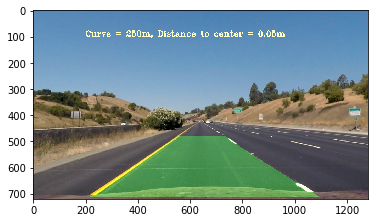

In [40]:
# Test Images
dirName = 'test_images/'
outDirName = 'output_images/'
images = os.listdir(dirName)
#f, plts = plt.subplots(len(images), 1, figsize=(100,50))
i = -10
#images = ['straight_lines1.jpg','straight_lines2.jpg']
for imgName in images:
    imgPath = os.path.join(dirName, imgName)
    image = mpimg.imread(os.path.join(dirName, imgName))
    global lane
    lane = Lane()
    #lane.visualize = True
    outImg = processImage(image)
    plt.imshow(outImg)
    #imgName = "fit_" + imgName
    plt.savefig(os.path.join(outDirName, imgName))
    #cv2.imwrite(os.path.join(outDirName, imgName), outImg)

In [19]:
project_output = 'test_videos_output/project_video.mp4'
#clip3 = VideoFileClip('project_video.mp4').subclip(0,4)
clip3 = VideoFileClip('project_video.mp4')
global lane
lane = Lane()
#lane.visualize = True
global i
i = 0
challenge_clip = clip3.fl_image(processImage)
%time challenge_clip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/project_video.mp4
[MoviePy] Writing video test_videos_output/project_video.mp4


 44%|████▍     | 555/1261 [04:52<05:27,  2.16it/s]

Diff issue [0.00031819011581285186, 0.20982508565155666, 19.845370124653073] 33.4730140019
Bad fit? [ -1.76842228e-04   4.39750769e-02   9.42543709e+02] [0.00014134788781379454, -0.16585000870408984, 962.38907914606841]
Detected:  10


 44%|████▍     | 556/1261 [04:53<05:34,  2.11it/s]

Diff issue [0.00033856216278568558, 0.25010878042670309, 31.632084118360012] 26.8273052274
Bad fit? [ -1.97214275e-04   8.42587717e-02   9.30756995e+02] [0.00014134788781379454, -0.16585000870408984, 962.38907914606841]
Detected:  9


 80%|███████▉  | 1005/1261 [08:37<02:03,  2.08it/s]

Diff issue [0.00031041934196407927, 0.20800617220870282, 12.506457662293087] 23.4247132853
Bad fit? [ -1.68197510e-04   3.80091983e-03   9.77983434e+02] [0.00014222183166338854, -0.20420525238325865, 990.48989172841345]
Detected:  10


 81%|████████  | 1020/1261 [08:45<02:06,  1.91it/s]

Diff issue [0.00032640181728406923, 0.22902822383245777, 32.134247402682263] 36.1999643321
Bad fit? [ -1.85008702e-04   5.03884665e-02   9.45625180e+02] [0.00014139311561242208, -0.17863975734603796, 977.75942786934036]
Detected:  10


 83%|████████▎ | 1041/1261 [08:55<01:48,  2.03it/s]

Diff issue [0.00051217628837914352, 0.32265030101069275, 38.698439438916353] 71.488039229
Bad fit? [ -4.82770778e-04   2.38300529e-01   9.07464966e+02] [2.9405510227287392e-05, -0.084349771655782821, 946.16340572770753]
Detected:  10


100%|█████████▉| 1260/1261 [10:44<00:00,  1.98it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/project_video.mp4 

CPU times: user 9min 15s, sys: 1min 22s, total: 10min 38s
Wall time: 10min 46s


In [20]:
project_output = 'test_videos_output/challenge_video.mp4'
#clip5 = VideoFileClip('challenge_video.mp4').subclip(0,5)
#clip5 = VideoFileClip('challenge_video.mp4').subclip(1.2,1.8)
clip5 = VideoFileClip('challenge_video.mp4')
global lane
lane = Lane()
#lane.visualize = True
global i
i = 0
challenge_clip = clip5.fl_image(processImage)
%time challenge_clip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge_video.mp4
[MoviePy] Writing video test_videos_output/challenge_video.mp4


  2%|▏         | 8/485 [00:03<03:51,  2.06it/s]

Diff issue [0.00049068897821712588, 0.2030974264381864, 15.914415446873477] 123.554430706
Bad fit? [  6.52174649e-04  -2.96993602e-01   9.12577382e+02] [0.00016148567060864571, -0.093896175928728939, 896.66296691416176]
Detected:  10


 27%|██▋       | 129/485 [01:02<02:59,  1.98it/s]

Diff issue [0.00046793701164576197, 0.57621527908538006, 179.04138351827885] 6.6477833333
Bad fit? [ -3.63386307e-04   2.70962768e-01   4.12301553e+02] [0.00010455070423084517, -0.30525251114158863, 591.34293631196851]
Detected:  10
Diff issue [0.00073789003663381572, 0.90273855365578792, 271.6228926302241] 4.01424377997
Bad fit? [ -5.41736297e-04   6.33173865e-01   6.83718890e+02] [0.00019615373961719514, -0.26956468873043338, 955.34178310314451]
Detected:  10


 27%|██▋       | 130/485 [01:02<02:56,  2.01it/s]

Diff issue [0.00034484823473855105, 0.4233301773580882, 132.88261106782585] 6.78130182604
Bad fit? [ -2.40297531e-04   1.18077666e-01   4.58460325e+02] [0.00010455070423084517, -0.30525251114158863, 591.34293631196851]
Detected:  9
Diff issue [0.00084450622461558033, 1.0671967423120305, 331.99164111761388] 1.25396577876
Bad fit? [ -6.48352485e-04   7.97632054e-01   6.23350142e+02] [0.00019615373961719514, -0.26956468873043338, 955.34178310314451]
Detected:  9


 27%|██▋       | 131/485 [01:03<02:52,  2.05it/s]

Lane width changed (left) 713.917328493 400.506217336
Lane width changed (right) 1070.14181261 400.506217336
Bad fit? [ -2.23647361e-03   2.96473152e+00  -1.14800030e+02] [0.00019615373961719514, -0.26956468873043338, 955.34178310314451]
Detected:  8


 28%|██▊       | 134/485 [01:04<02:43,  2.14it/s]

Diff issue [0.00030571553843008028, 0.14318184767680972, 18.201592625821036] 36.8936693569
Bad fit? [  4.23375836e-04  -3.27359945e-01   9.16436444e+02] [0.00011766029748451059, -0.18417809726888393, 934.6380365239778]
Detected:  10


 29%|██▊       | 139/485 [01:06<02:37,  2.20it/s]

Diff issue [0.0005642029363816109, 0.071804413348220908, 5.4261436869084037] 234.61739731
Bad fit? [ -3.31176455e-04  -1.62313093e-01   9.22114221e+02] [0.00023302648093188991, -0.23411750654036365, 916.68807700112745]
Detected:  10


 29%|██▉       | 140/485 [01:07<02:38,  2.18it/s]

Diff issue [0.00095092577580317911, 0.47818321362164196, 58.844497117908986] 206.622306509
Bad fit? [  1.18395226e-03  -7.12300720e-01   9.75532574e+02] [0.00023302648093188991, -0.23411750654036365, 916.68807700112745]
Detected:  9


 29%|██▉       | 142/485 [01:08<02:39,  2.15it/s]

Diff issue [0.00030053294688131766, 0.26824323890678015, 37.824204659745988] 0.321128638484
Bad fit? [ -3.43560108e-04   6.23871351e-02   5.51536344e+02] [-4.3027161078375701e-05, -0.20585610383318473, 589.36054852692314]
Detected:  10


 30%|███       | 147/485 [01:10<02:42,  2.09it/s]

Diff issue [0.00034862632044349232, 0.16611211040152324, 19.149781768424759] 79.9413856325
Bad fit? [  4.40481753e-04  -3.09076751e-01   9.30472598e+02] [9.1855432227206575e-05, -0.14296464105735535, 911.32281623934682]
Detected:  10


 31%|███       | 148/485 [01:11<02:42,  2.08it/s]

Diff issue [0.00034393675793649724, 0.17591057367763968, 17.852892324318759] 69.1750801697
Bad fit? [  4.35792190e-04  -3.18875215e-01   9.29175709e+02] [9.1855432227206575e-05, -0.14296464105735535, 911.32281623934682]
Detected:  9


 31%|███       | 149/485 [01:11<02:42,  2.07it/s]

Diff issue [0.00032952016557072952, 0.15026936630173443, 13.88162244499938] 76.1870223877
Bad fit? [  4.21375598e-04  -2.93234007e-01   9.25204439e+02] [9.1855432227206575e-05, -0.14296464105735535, 911.32281623934682]
Detected:  8


 34%|███▍      | 167/485 [01:20<02:38,  2.00it/s]

Diff issue [0.00030622475092266716, 0.18480490262699445, 9.6260484518364819] 35.0575769248
Bad fit? [ -2.64721293e-04   7.67521999e-02   9.08588344e+02] [4.1503458361054148e-05, -0.1080527027036767, 918.21439248404431]
Detected:  10


 98%|█████████▊| 477/485 [03:46<00:03,  2.10it/s]

Diff issue [0.00030481638575076343, 0.23813142103513049, 36.581699784433681] 22.9433916543
Bad fit? [  1.25538786e-04  -6.91308047e-02   8.97897561e+02] [0.00043035517169039649, -0.3072622256959231, 934.47926105430713]
Detected:  10


 99%|█████████▊| 478/485 [03:47<00:03,  2.13it/s]

Diff issue [0.00040890108277983673, 0.34992562589592796, 62.967071488278975] 22.7564591241
Bad fit? [  2.14540889e-05   4.26634002e-02   8.71512190e+02] [0.00043035517169039649, -0.3072622256959231, 934.47926105430713]
Detected:  9


100%|██████████| 485/485 [03:50<00:00,  2.21it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge_video.mp4 

CPU times: user 3min 18s, sys: 27.8 s, total: 3min 46s
Wall time: 3min 52s


In [21]:
project_output = 'test_videos_output/harder_challenge_video.mp4'
#clip6 = VideoFileClip('harder_challenge_video.mp4').subclip(0,5)
#clip6 = VideoFileClip('harder_challenge_video.mp4').subclip(1.2,1.8)
clip6 = VideoFileClip('harder_challenge_video.mp4')
global lane
lane = Lane()
#lane.visualize = True
global i
i = 0
challenge_clip = clip6.fl_image(processImage)
%time challenge_clip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/harder_challenge_video.mp4
[MoviePy] Writing video test_videos_output/harder_challenge_video.mp4


  8%|▊         | 94/1200 [00:45<08:26,  2.18it/s]

Lane width changed (left) 240.262673281 513.228630825
Lane width changed (right) 764.141601118 513.228630825
Bad fit? [ -1.06349758e-03   1.77892975e+00  -3.18312567e+02] [-0.00053034049191400521, 1.0670210139163119, -78.049894132703898]
Detected:  10


 11%|█         | 134/1200 [01:04<08:33,  2.08it/s]

Diff issue [0.00018267942498405125, 0.30921605603915037, 127.76886414123101] 0.119341931738
Bad fit? [  1.08115448e-03  -1.32538678e+00   1.27578338e+03] [0.0008984750552310317, -1.0161707271620835, 1148.0145150892452]
Detected:  10


 11%|█▏        | 135/1200 [01:05<08:32,  2.08it/s]

Diff issue [0.00011938593720056201, 0.26927175130855585, 130.48992630683847] 1.39858940287
Bad fit? [  1.01786099e-03  -1.28544248e+00   1.27850444e+03] [0.0008984750552310317, -1.0161707271620835, 1148.0145150892452]
Detected:  9


 11%|█▏        | 136/1200 [01:05<08:41,  2.04it/s]

Diff issue [2.7157579267161891e-05, 0.19083426145708171, 120.84004787798131] 2.33037677413
Bad fit? [  9.25632634e-04  -1.20700499e+00   1.26885456e+03] [0.0008984750552310317, -1.0161707271620835, 1148.0145150892452]
Detected:  8


 12%|█▏        | 138/1200 [01:06<08:34,  2.06it/s]

Diff issue [1.0385617189153425e-05, 0.18717451706846178, 127.07658292305155] 2.13293580145
Bad fit? [  8.97844035e-04  -1.24081480e+00   1.30680245e+03] [0.00088745841799800344, -1.0536402839252275, 1179.7258636569886]
Detected:  10


 12%|█▏        | 140/1200 [01:07<08:33,  2.06it/s]

Diff issue [2.5914645274760311e-05, 0.21785631855505483, 141.64262486502025] 1.59920724018
Bad fit? [  9.08018251e-04  -1.32090294e+00   1.35892851e+03] [0.00088210360557040206, -1.1030466240096699, 1217.2858834291399]
Detected:  10


 12%|█▏        | 143/1200 [01:09<08:21,  2.11it/s]

Diff issue [7.345669157150824e-05, 0.26074264978004758, 148.5674840170459] 0.93223644331
Bad fit? [  8.80026561e-04  -1.40544331e+00   1.43268264e+03] [0.00080656986918099761, -1.1447006626931449, 1284.1151562472101]
Detected:  10


 12%|█▏        | 145/1200 [01:10<08:20,  2.11it/s]

Diff issue [5.2670301433289241e-05, 0.23291988313286716, 139.96796412183585] 0.272940151441
Bad fit? [  8.03404223e-04  -1.38553222e+00   1.45760431e+03] [0.00075073392164312581, -1.1526123381259246, 1317.636344347404]
Detected:  10


 12%|█▏        | 147/1200 [01:11<08:23,  2.09it/s]

Diff issue [7.0696975034355964e-05, 0.24998560930752767, 145.96603454509909] 2.77396036372
Bad fit? [  7.92872655e-04  -1.43023856e+00   1.49818811e+03] [0.00072217567968985705, -1.1802529504186379, 1352.2220711081757]
Detected:  10


 12%|█▏        | 149/1200 [01:11<08:16,  2.12it/s]

Diff issue [3.0784393522191133e-05, 0.19521597630698206, 129.856341508696] 5.4103854036
Bad fit? [  6.94387954e-04  -1.36662267e+00   1.50617225e+03] [0.00066360356048072772, -1.171406697049737, 1376.315912183735]
Detected:  10


 13%|█▎        | 152/1200 [01:13<08:14,  2.12it/s]

Diff issue [7.8555621928040652e-05, 0.23058459771540063, 132.25320090095761] 7.07306801113
Bad fit? [  6.53123278e-04  -1.40776437e+00   1.56192103e+03] [0.00057456765569531966, -1.1771797676484261, 1429.6678265952053]
Detected:  10


 14%|█▍        | 168/1200 [01:21<08:24,  2.04it/s]

Lane width changed (right) 907.22128911 715.368509996
Bad fit? [  2.85516031e-04  -9.25509669e-01   8.77602761e+02] [0.0003670539827531943, -1.0029524283562206, 896.4036685421662]
Detected:  10


 14%|█▍        | 169/1200 [01:21<08:20,  2.06it/s]

Lane width changed (right) 910.144028174 716.172876026
Bad fit? [  3.13337416e-04  -9.38982783e-01   8.75362466e+02] [0.0003670539827531943, -1.0029524283562206, 896.4036685421662]
Detected:  9


 14%|█▍        | 170/1200 [01:22<08:22,  2.05it/s]

Lane width changed (right) 901.546429066 715.931369938
Bad fit? [  3.60133148e-04  -9.81081569e-01   8.82718849e+02] [0.0003670539827531943, -1.0029524283562206, 896.4036685421662]
Detected:  8


 14%|█▍        | 171/1200 [01:22<08:18,  2.06it/s]

Lane width changed (right) 911.386621874 715.878723102
Bad fit? [  3.16820399e-04  -9.34299148e-01   8.72052585e+02] [0.0003670539827531943, -1.0029524283562206, 896.4036685421662]
Detected:  7


 14%|█▍        | 172/1200 [01:23<08:20,  2.05it/s]

Lane width changed (right) 911.653456984 715.604191026
Bad fit? [  3.10227967e-04  -9.24643224e-01   8.70736838e+02] [0.0003670539827531943, -1.0029524283562206, 896.4036685421662]
Detected:  6


 14%|█▍        | 174/1200 [01:24<08:14,  2.07it/s]

Lane width changed (right) 906.119818334 721.088410784
Bad fit? [  3.65319882e-04  -9.77956540e-01   8.86984456e+02] [0.00036638696979331717, -1.0037346286096791, 897.59349604217687]
Detected:  10


 15%|█▍        | 175/1200 [01:24<08:10,  2.09it/s]

Lane width changed (right) 945.11611772 725.964679228
Bad fit? [  2.69212955e-04  -8.65794598e-01   8.56933486e+02] [0.00036638696979331717, -1.0037346286096791, 897.59349604217687]
Detected:  9


 15%|█▍        | 176/1200 [01:24<08:12,  2.08it/s]

Lane width changed (right) 951.986408004 731.331377153
Bad fit? [  2.81527037e-04  -8.76679129e-01   8.59930038e+02] [0.00036638696979331717, -1.0037346286096791, 897.59349604217687]
Detected:  8


 15%|█▍        | 177/1200 [01:25<08:08,  2.09it/s]

Lane width changed (right) 963.667677201 739.51205539
Bad fit? [  3.05109076e-04  -8.94702385e-01   8.63236148e+02] [0.00036638696979331717, -1.0037346286096791, 897.59349604217687]
Detected:  7


 15%|█▍        | 178/1200 [01:25<08:07,  2.10it/s]

Lane width changed (right) 975.831638555 748.21710277
Bad fit? [  3.15244691e-04  -9.04616383e-01   8.66912046e+02] [0.00036638696979331717, -1.0037346286096791, 897.59349604217687]
Detected:  6


 15%|█▍        | 179/1200 [01:26<08:05,  2.10it/s]

Lane width changed (right) 966.570205786 755.400956487
Bad fit? [  3.92241835e-04  -9.88559808e-01   8.89276281e+02] [0.00036638696979331717, -1.0037346286096791, 897.59349604217687]
Detected:  5


 15%|█▌        | 180/1200 [01:26<07:59,  2.13it/s]

Lane width changed (right) 1012.67381094 763.554379951
Bad fit? [  3.02215228e-04  -8.80308821e-01   8.57982429e+02] [0.00036638696979331717, -1.0037346286096791, 897.59349604217687]
Detected:  4


 15%|█▌        | 181/1200 [01:27<07:46,  2.19it/s]

Lane width changed (right) 1021.46648749 764.412932897
Bad fit? [  2.81182927e-04  -8.52661220e-01   8.49892653e+02] [0.00036638696979331717, -1.0037346286096791, 897.59349604217687]
Detected:  3


 15%|█▌        | 182/1200 [01:27<07:52,  2.16it/s]

Lane width changed (right) 1003.88392033 761.783752252
Bad fit? [  3.24907944e-04  -8.97574758e-01   8.61303332e+02] [0.00036638696979331717, -1.0037346286096791, 897.59349604217687]
Detected:  2


 15%|█▌        | 183/1200 [01:28<07:52,  2.15it/s]

Lane width changed (right) 995.302770697 752.678019067
Bad fit? [  2.74047348e-04  -8.50016364e-01   8.51600599e+02] [0.00036638696979331717, -1.0037346286096791, 897.59349604217687]
Detected:  1


 15%|█▌        | 184/1200 [01:28<09:00,  1.88it/s]

Lane width changed (left) 385.479300565 742.061606071
Lane width changed (right) 977.700754835 742.061606071
Bad fit? [ -1.68924243e-03   1.31094914e+00   8.47317594e+02] [0.00072640501609566805, -1.7782016422093707, 1825.0183488853986]


 15%|█▌        | 185/1200 [01:29<08:37,  1.96it/s]

Lane width changed (right) 192.149833012 565.341868237
Bad fit? [  7.02000393e-05  -1.03869982e+00   1.63286852e+03] [0.00072640501609566805, -1.7782016422093707, 1825.0183488853986]


 16%|█▌        | 189/1200 [01:31<08:18,  2.03it/s]

Diff issue [0.00030894657572489359, 0.36371102374919873, 95.986522160464233] 5.80837318189
Bad fit? [  4.39772469e-04  -1.14718345e+00   9.89528688e+02] [  7.48719044e-04  -1.51089447e+00   1.08551521e+03]
Detected:  10


 16%|█▌        | 190/1200 [01:31<08:13,  2.05it/s]

Diff issue [0.00052340271608661488, 0.57261317316123728, 135.66986305203488] 5.46021694004
Bad fit? [  2.25316328e-04  -9.38281299e-01   9.49845347e+02] [  7.48719044e-04  -1.51089447e+00   1.08551521e+03]
Detected:  9


 16%|█▌        | 191/1200 [01:32<08:08,  2.07it/s]

Diff issue [0.00031847641632905185, 0.38302171151088382, 108.67683080323297] 2.07589311121
Bad fit? [  4.30242628e-04  -1.12787276e+00   9.76838379e+02] [  7.48719044e-04  -1.51089447e+00   1.08551521e+03]
Detected:  8
Diff issue [0.00047701421857815411, 0.63877035304879171, 207.74888195250901] 4.92925443919
Bad fit? [ -2.97529508e-04  -6.08963085e-01   1.51254075e+03] [ -7.74543726e-04   2.98072676e-02   1.30479187e+03]
Detected:  10


 16%|█▌        | 192/1200 [01:32<08:02,  2.09it/s]

Lane width changed (left) 187.594225267 379.425210688
Bad fit? [  7.08510872e-05  -7.55928247e-01   8.97920984e+02] [  7.48719044e-04  -1.51089447e+00   1.08551521e+03]
Detected:  7
Diff issue [0.00030444063255235414, 0.44334200663004397, 156.10377269770811] 5.2751962244
Bad fit? [ -4.70103094e-04  -4.13534739e-01   1.46089564e+03] [ -7.74543726e-04   2.98072676e-02   1.30479187e+03]
Detected:  9


 16%|█▌        | 193/1200 [01:33<07:55,  2.12it/s]

Lane width changed (left) 183.917405643 379.425210688
Bad fit? [  1.54960147e-04  -8.21524248e-01   9.01597804e+02] [  7.48719044e-04  -1.51089447e+00   1.08551521e+03]
Detected:  6
Diff issue [0.0002816070386010951, 0.38551980627273535, 132.21787093773423] 0.608986509898
Bad fit? [ -4.92936688e-04  -3.55712539e-01   1.43700974e+03] [ -7.74543726e-04   2.98072676e-02   1.30479187e+03]
Detected:  8


 16%|█▌        | 194/1200 [01:33<07:52,  2.13it/s]

Diff issue [0.0003388862214519194, 0.44143969329357224, 139.66426422718223] 2.53991532289
Bad fit? [  4.09832823e-04  -1.06945478e+00   9.45850945e+02] [  7.48719044e-04  -1.51089447e+00   1.08551521e+03]
Detected:  5
Diff issue [0.00046614359583390069, 0.53896605131086472, 155.39757230927216] 8.85904086265
Bad fit? [ -3.08400130e-04  -5.09158784e-01   1.46018944e+03] [ -7.74543726e-04   2.98072676e-02   1.30479187e+03]
Detected:  7


 16%|█▋        | 195/1200 [01:34<08:04,  2.07it/s]

Diff issue [0.00042414224111943141, 0.56061663542732276, 174.86900987140712] 8.9493538895
Bad fit? [  3.24576803e-04  -9.50277837e-01   9.10646200e+02] [  7.48719044e-04  -1.51089447e+00   1.08551521e+03]
Detected:  4
Diff issue [0.00058554475381140871, 0.61856076409496352, 160.53378820560579] 18.4924002964
Bad fit? [ -1.88998972e-04  -5.88753497e-01   1.46532566e+03] [ -7.74543726e-04   2.98072676e-02   1.30479187e+03]
Detected:  6


 16%|█▋        | 196/1200 [01:34<08:02,  2.08it/s]

Diff issue [0.00039316098892566514, 0.48359051511540807, 157.13408620445318] 12.6814038325
Bad fit? [  3.55558056e-04  -1.02730396e+00   9.28381123e+02] [  7.48719044e-04  -1.51089447e+00   1.08551521e+03]
Detected:  3
Diff issue [0.00059842294952881054, 0.5949193135671168, 141.0203748658796] 22.6347148225
Bad fit? [ -1.76120777e-04  -5.65112046e-01   1.44581224e+03] [ -7.74543726e-04   2.98072676e-02   1.30479187e+03]
Detected:  5


 16%|█▋        | 197/1200 [01:35<07:54,  2.11it/s]

Lane width changed (left) 184.292648298 379.425210688
Bad fit? [  3.07116169e-04  -9.46631744e-01   9.01222561e+02] [  7.48719044e-04  -1.51089447e+00   1.08551521e+03]
Detected:  2
Diff issue [0.00048012748902767898, 0.46170248033548222, 98.478162271014526] 14.721265765
Bad fit? [ -2.94416237e-04  -4.31895213e-01   1.40327003e+03] [ -7.74543726e-04   2.98072676e-02   1.30479187e+03]
Detected:  4


 16%|█▋        | 198/1200 [01:35<07:51,  2.13it/s]

Diff issue [0.00021434682488037345, 0.33845005471401235, 135.20903743254473] 2.67239703015
Bad fit? [  5.34372220e-04  -1.17244442e+00   9.50306172e+02] [  7.48719044e-04  -1.51089447e+00   1.08551521e+03]
Detected:  1
Diff issue [0.00039546027570193745, 0.35807816016620347, 60.937723553848855] 7.9170659815
Bad fit? [ -3.79083450e-04  -3.28270893e-01   1.36572959e+03] [ -7.74543726e-04   2.98072676e-02   1.30479187e+03]
Detected:  3


 17%|█▋        | 199/1200 [01:36<10:29,  1.59it/s]

Lane width changed (left) 750.437180087 379.425210688
Lane width changed (right) 969.713837947 379.425210688
Bad fit? [ -2.28774598e-05   1.21591489e-01   3.35078030e+02] [  7.48719044e-04  -1.51089447e+00   1.08551521e+03]


 17%|█▋        | 200/1200 [01:37<13:00,  1.28it/s]

Lane width changed (left) 785.17032896 379.425210688
Lane width changed (right) 1004.44698682 379.425210688
Bad fit? [ -2.77257747e-05   1.76299380e-01   3.00344881e+02] [  7.48719044e-04  -1.51089447e+00   1.08551521e+03]


 17%|█▋        | 201/1200 [01:39<15:31,  1.07it/s]

Lane width changed (left) 974.801275107 379.425210688
Lane width changed (right) 1194.07793297 379.425210688
Bad fit? [ -1.17865859e-03   1.22734609e+00   1.10713935e+02] [  7.48719044e-04  -1.51089447e+00   1.08551521e+03]


 17%|█▋        | 202/1200 [01:40<17:58,  1.08s/it]

Lane width changed (right) 763.739481687 379.425210688
Bad fit? [ -1.95872307e-04  -7.61805565e-02   5.41052386e+02] [  7.48719044e-04  -1.51089447e+00   1.08551521e+03]


 17%|█▋        | 203/1200 [01:42<20:53,  1.26s/it]

Lane width changed (left) 816.421049665 379.425210688
Lane width changed (right) 1035.69770752 379.425210688
Bad fit? [ -8.65272773e-04   7.83838507e-01   2.69094160e+02] [  7.48719044e-04  -1.51089447e+00   1.08551521e+03]
Lane width changed (left) 3507.32741331 379.425210688
Lane width changed (right) 3726.60407117 379.425210688
Bad fit? [ -8.26333948e-03   1.06057199e+01  -2.42181220e+03] [ -7.74543726e-04   2.98072676e-02   1.30479187e+03]


 17%|█▋        | 204/1200 [01:44<24:29,  1.48s/it]

Lane width changed (right) 767.541841286 379.425210688
Bad fit? [ -6.85071750e-04   2.24237764e-01   5.37250026e+02] [  7.48719044e-04  -1.51089447e+00   1.08551521e+03]


 17%|█▋        | 205/1200 [01:46<28:02,  1.69s/it]

Lane width changed (left) 599.315810575 263.219891758
Lane width changed (right) 591.054512735 263.219891758
Bad fit? [ -8.85317186e-04   4.24528078e-01   4.86199399e+02] [  7.48719044e-04  -1.51089447e+00   1.08551521e+03]


 17%|█▋        | 206/1200 [01:48<30:44,  1.86s/it]

Lane width changed (left) 640.656312431 226.715116143
Lane width changed (right) 564.379528635 226.715116143
Bad fit? [ -8.88871644e-04   5.00327424e-01   4.44858897e+02] [  7.48719044e-04  -1.51089447e+00   1.08551521e+03]


 17%|█▋        | 207/1200 [01:50<33:26,  2.02s/it]

Lane width changed (left) 686.986341031 185.889897701
Lane width changed (right) 531.744072312 185.889897701
Bad fit? [ -9.80367111e-04   6.30645975e-01   3.98528869e+02] [  7.48719044e-04  -1.51089447e+00   1.08551521e+03]


 17%|█▋        | 208/1200 [01:53<36:12,  2.19s/it]

Lane width changed (left) 747.740878311 155.042738309
Lane width changed (right) 532.026843223 155.042738309
Bad fit? [ -1.13568630e-03   8.23949355e-01   3.37774331e+02] [  7.48719044e-04  -1.51089447e+00   1.08551521e+03]


 17%|█▋        | 209/1200 [01:56<39:12,  2.37s/it]

Lane width changed (left) 796.615657815 148.736544406
Lane width changed (right) 556.223403741 148.736544406
Bad fit? [ -1.17694671e-03   9.30343886e-01   2.88899552e+02] [  7.48719044e-04  -1.51089447e+00   1.08551521e+03]


 18%|█▊        | 210/1200 [01:59<41:58,  2.54s/it]

Lane width changed (left) 853.259311552 144.257313437
Lane width changed (right) 589.125990604 144.257313437
Bad fit? [ -1.26825269e-03   1.08005851e+00   2.32255898e+02] [  7.48719044e-04  -1.51089447e+00   1.08551521e+03]


 18%|█▊        | 211/1200 [02:02<45:49,  2.78s/it]

Lane width changed (left) 881.351342435 125.810321193
Lane width changed (right) 580.544347378 125.810321193
Bad fit? [ -1.17435480e-03   1.06712215e+00   2.04163867e+02] [  7.48719044e-04  -1.51089447e+00   1.08551521e+03]
Lane width changed (left) 334.151149309 125.810321193
Bad fit? [ -5.30950603e-04   6.48249917e-01   7.51364060e+02] [ -6.10549344e-04   6.53115789e-01   7.84708215e+02]


 18%|█▊        | 212/1200 [02:06<49:04,  2.98s/it]

Lane width changed (left) 900.58836639 125.810321193
Lane width changed (right) 599.781371333 125.810321193
Bad fit? [ -1.06940076e-03   1.02893290e+00   1.84926843e+02] [  7.48719044e-04  -1.51089447e+00   1.08551521e+03]
Lane width changed (left) 364.240571717 125.810321193
Bad fit? [ -3.52684317e-04   5.76704399e-01   7.21274638e+02] [ -6.10549344e-04   6.53115789e-01   7.84708215e+02]


 18%|█▊        | 213/1200 [02:09<52:17,  3.18s/it]

Lane width changed (left) 914.986136751 125.810321193
Lane width changed (right) 614.179141694 125.810321193
Bad fit? [ -9.52338142e-04   9.77501107e-01   1.70529073e+02] [  7.48719044e-04  -1.51089447e+00   1.08551521e+03]
Lane width changed (left) 380.508680696 125.810321193
Bad fit? [ -2.41115594e-04   5.22820358e-01   7.05006529e+02] [ -6.10549344e-04   6.53115789e-01   7.84708215e+02]


 18%|█▊        | 214/1200 [02:13<54:36,  3.32s/it]

Lane width changed (left) 917.203337125 125.810321193
Lane width changed (right) 616.396342068 125.810321193
Bad fit? [ -7.46041203e-04   8.58545783e-01   1.68311873e+02] [  7.48719044e-04  -1.51089447e+00   1.08551521e+03]
Lane width changed (left) 402.185556487 125.810321193
Bad fit? [ -6.64198199e-05   4.36442720e-01   6.83329653e+02] [ -6.10549344e-04   6.53115789e-01   7.84708215e+02]


 18%|█▊        | 215/1200 [02:17<56:59,  3.47s/it]

Lane width changed (left) 1042.75962369 125.810321193
Lane width changed (right) 741.952628633 125.810321193
Bad fit? [ -1.34079239e-03   1.40988337e+00   4.27555860e+01] [  7.48719044e-04  -1.51089447e+00   1.08551521e+03]
Lane width changed (left) 418.026739593 125.810321193
Bad fit? [  2.77648053e-05   3.88687689e-01   6.67488470e+02] [ -6.10549344e-04   6.53115789e-01   7.84708215e+02]


 18%|█▊        | 216/1200 [02:20<57:49,  3.53s/it]

Lane width changed (left) 901.948278999 125.810321193
Lane width changed (right) 601.141283942 125.810321193
Bad fit? [ -2.89777206e-04   5.62251637e-01   1.83566931e+02] [  7.48719044e-04  -1.51089447e+00   1.08551521e+03]
Lane width changed (left) 420.136689781 125.810321193
Bad fit? [  1.57793364e-04   2.98848677e-01   6.65378520e+02] [ -6.10549344e-04   6.53115789e-01   7.84708215e+02]


 18%|█▊        | 217/1200 [02:24<58:40,  3.58s/it]

Lane width changed (left) 914.838766111 125.810321193
Lane width changed (right) 614.031771054 125.810321193
Bad fit? [ -2.21719771e-04   5.35262330e-01   1.70676444e+02] [  7.48719044e-04  -1.51089447e+00   1.08551521e+03]
Lane width changed (left) 419.721012131 125.810321193
Bad fit? [  3.28606257e-04   1.83766879e-01   6.65794198e+02] [ -6.10549344e-04   6.53115789e-01   7.84708215e+02]


 18%|█▊        | 218/1200 [02:28<59:42,  3.65s/it]

Lane width changed (left) 941.893675896 125.810321193
Lane width changed (right) 641.086680838 125.810321193
Bad fit? [ -3.02909455e-04   6.11263597e-01   1.43621534e+02] [  7.48719044e-04  -1.51089447e+00   1.08551521e+03]
Lane width changed (left) 421.374411348 125.810321193
Bad fit? [  4.07817449e-04   1.28123754e-01   6.64140798e+02] [ -6.10549344e-04   6.53115789e-01   7.84708215e+02]


 18%|█▊        | 219/1200 [02:32<1:01:36,  3.77s/it]

Lane width changed (left) 1159.75287705 125.810321193
Lane width changed (right) 858.945881996 125.810321193
Bad fit? [ -1.45590455e-03   1.64779606e+00  -7.42376674e+01] [  7.48719044e-04  -1.51089447e+00   1.08551521e+03]
Lane width changed (left) 440.068738455 125.810321193
Bad fit? [  4.10125660e-04   1.45703789e-01   6.45446471e+02] [ -6.10549344e-04   6.53115789e-01   7.84708215e+02]


 18%|█▊        | 220/1200 [02:36<1:03:27,  3.89s/it]

Lane width changed (left) 1158.27521081 125.810321193
Lane width changed (right) 857.468215752 125.810321193
Bad fit? [ -1.37372213e-03   1.58599681e+00  -7.27600011e+01] [  7.48719044e-04  -1.51089447e+00   1.08551521e+03]
Lane width changed (left) 433.876448858 125.810321193
Bad fit? [  4.76897181e-04   8.52912392e-02   6.51638761e+02] [ -6.10549344e-04   6.53115789e-01   7.84708215e+02]


 18%|█▊        | 221/1200 [02:40<1:06:02,  4.05s/it]

Lane width changed (left) 1179.22225911 125.810321193
Lane width changed (right) 878.415264058 125.810321193
Bad fit? [ -1.38096631e-03   1.62067915e+00  -9.37070494e+01] [  7.48719044e-04  -1.51089447e+00   1.08551521e+03]


 18%|█▊        | 222/1200 [02:45<1:06:24,  4.07s/it]

Lane width changed (left) 1168.18767409 213.833586091
Lane width changed (right) 1084.82544507 213.833586091
Bad fit? [ -1.26440041e-03   1.52888819e+00  -8.26724644e+01] [  7.48719044e-04  -1.51089447e+00   1.08551521e+03]
Lane width changed (left) 417.430257115 213.833586091
Bad fit? [  5.82715397e-04  -2.09401525e-02   6.68084953e+02] [  1.69333424e-04  -2.67624097e-01   1.00215298e+03]


 19%|█▊        | 223/1200 [02:49<1:08:04,  4.18s/it]

Lane width changed (left) 1181.54567601 213.833586091
Lane width changed (right) 1098.18344699 213.833586091
Bad fit? [ -1.29903250e-03   1.56847812e+00  -9.60304663e+01] [  7.48719044e-04  -1.51089447e+00   1.08551521e+03]


 19%|█▊        | 224/1200 [02:53<1:08:38,  4.22s/it]

Lane width changed (left) 1185.59213382 139.410942712
Lane width changed (right) 968.526750051 139.410942712
Bad fit? [ -1.28037633e-03   1.56097058e+00  -1.00076924e+02] [  7.48719044e-04  -1.51089447e+00   1.08551521e+03]
Lane width changed (left) 436.252378724 139.410942712
Bad fit? [  5.05667670e-05   3.30954363e-01   6.49262831e+02] [ -5.41648491e-05   5.79682727e-02   8.68449826e+02]


 19%|█▉        | 225/1200 [02:58<1:08:42,  4.23s/it]

Lane width changed (left) 1187.41052056 139.410942712
Lane width changed (right) 970.345136792 139.410942712
Bad fit? [ -1.24523623e-03   1.54267267e+00  -1.01895311e+02] [  7.48719044e-04  -1.51089447e+00   1.08551521e+03]
Lane width changed (left) 379.480346603 139.410942712
Bad fit? [  7.56989197e-04  -2.08624591e-01   7.06034863e+02] [ -5.41648491e-05   5.79682727e-02   8.68449826e+02]


 19%|█▉        | 226/1200 [03:03<1:12:08,  4.44s/it]

Lane width changed (left) 1183.76490875 139.410942712
Lane width changed (right) 966.699524982 139.410942712
Bad fit? [ -1.18362928e-03   1.50222622e+00  -9.82496991e+01] [  7.48719044e-04  -1.51089447e+00   1.08551521e+03]
Lane width changed (left) 367.997676715 139.410942712
Bad fit? [  8.48586635e-04  -2.90296905e-01   7.17517533e+02] [ -5.41648491e-05   5.79682727e-02   8.68449826e+02]


 19%|█▉        | 227/1200 [03:07<1:13:59,  4.56s/it]

Lane width changed (left) 1190.98735536 139.410942712
Lane width changed (right) 973.921971592 139.410942712
Bad fit? [ -1.15817940e-03   1.50208762e+00  -1.05472146e+02] [  7.48719044e-04  -1.51089447e+00   1.08551521e+03]
Lane width changed (left) 372.19824013 139.410942712
Bad fit? [  9.87455542e-04  -3.75418245e-01   7.13316970e+02] [ -5.41648491e-05   5.79682727e-02   8.68449826e+02]


 19%|█▉        | 228/1200 [03:12<1:15:03,  4.63s/it]

Lane width changed (left) 1201.71398359 139.410942712
Lane width changed (right) 984.648599819 139.410942712
Bad fit? [ -1.19144440e-03   1.54075293e+00  -1.16198774e+02] [  7.48719044e-04  -1.51089447e+00   1.08551521e+03]
Lane width changed (left) 330.400724787 139.410942712
Bad fit? [  1.07419719e-03  -4.89351432e-01   7.55114485e+02] [ -5.41648491e-05   5.79682727e-02   8.68449826e+02]


 19%|█▉        | 229/1200 [03:18<1:19:13,  4.90s/it]

Lane width changed (left) 1196.27755336 139.410942712
Lane width changed (right) 979.212169583 139.410942712
Bad fit? [ -1.10375143e-03   1.47279368e+00  -1.10762344e+02] [  7.48719044e-04  -1.51089447e+00   1.08551521e+03]
Lane width changed (left) 361.256116396 139.410942712
Bad fit? [  2.59945669e-04   6.57289687e-02   7.24259093e+02] [ -5.41648491e-05   5.79682727e-02   8.68449826e+02]


 19%|█▉        | 230/1200 [03:22<1:14:08,  4.59s/it]

Lane width changed (left) 1194.74114173 139.410942712
Lane width changed (right) 977.675757959 139.410942712
Bad fit? [ -1.05750871e-03   1.44404669e+00  -1.09225932e+02] [  7.48719044e-04  -1.51089447e+00   1.08551521e+03]


 19%|█▉        | 231/1200 [03:25<1:10:22,  4.36s/it]

Lane width changed (left) 1185.28778156 174.649225328
Lane width changed (right) 1040.67849532 174.649225328
Bad fit? [ -9.86638189e-04   1.38338175e+00  -9.97725719e+01] [  7.48719044e-04  -1.51089447e+00   1.08551521e+03]


 19%|█▉        | 232/1200 [03:29<1:07:17,  4.17s/it]

Lane width changed (left) 1174.26721638 194.776299082
Lane width changed (right) 1064.77668809 194.776299082
Bad fit? [ -9.09603164e-04   1.31297521e+00  -8.87520067e+01] [  7.48719044e-04  -1.51089447e+00   1.08551521e+03]


 19%|█▉        | 233/1200 [03:33<1:05:05,  4.04s/it]

Lane width changed (left) 1164.20812175 194.418981096
Lane width changed (right) 1051.69195986 194.418981096
Bad fit? [ -8.54752653e-04   1.26134846e+00  -7.86929121e+01] [  7.48719044e-04  -1.51089447e+00   1.08551521e+03]


 20%|█▉        | 234/1200 [03:36<1:03:03,  3.92s/it]

Lane width changed (left) 1150.18784591 208.831250254
Lane width changed (right) 1060.50108595 208.831250254
Bad fit? [ -7.69238811e-04   1.18123488e+00  -6.46726362e+01] [  7.48719044e-04  -1.51089447e+00   1.08551521e+03]


 20%|█▉        | 235/1200 [03:40<1:03:05,  3.92s/it]

Lane width changed (left) 1142.42238053 212.618230154
Lane width changed (right) 1060.48030818 212.618230154
Bad fit? [ -7.18675224e-04   1.13347059e+00  -5.69071709e+01] [  7.48719044e-04  -1.51089447e+00   1.08551521e+03]


 20%|█▉        | 236/1200 [03:44<1:03:19,  3.94s/it]

Lane width changed (left) 1134.04241461 164.009473828
Lane width changed (right) 976.120828524 164.009473828
Bad fit? [ -6.29382660e-04   1.05733363e+00  -4.85272049e+01] [  7.48719044e-04  -1.51089447e+00   1.08551521e+03]
Lane width changed (left) 657.479964366 164.009473828
Lane width changed (right) 499.558378285 164.009473828
Bad fit? [ -2.62547221e-04   8.74715724e-01   4.28035245e+02] [ -2.03773878e-04   6.94446287e-02   9.27593624e+02]


 20%|█▉        | 237/1200 [03:48<1:00:40,  3.78s/it]

Lane width changed (left) 1137.0022694 164.009473828
Lane width changed (right) 979.080683322 164.009473828
Bad fit? [ -6.03768525e-04   1.04273581e+00  -5.14870597e+01] [  7.48719044e-04  -1.51089447e+00   1.08551521e+03]
Lane width changed (left) 669.783229377 164.009473828
Lane width changed (right) 511.861643296 164.009473828
Bad fit? [ -3.70244267e-04   9.67447532e-01   4.15731980e+02] [ -2.03773878e-04   6.94446287e-02   9.27593624e+02]


 20%|█▉        | 238/1200 [03:51<58:41,  3.66s/it]  

Lane width changed (left) 1147.95566118 164.009473828
Lane width changed (right) 990.034075095 164.009473828
Bad fit? [ -6.20423123e-04   1.07450645e+00  -6.24404515e+01] [  7.48719044e-04  -1.51089447e+00   1.08551521e+03]


 20%|█▉        | 239/1200 [03:55<57:37,  3.60s/it]

Lane width changed (left) 1152.05906085 114.009953219
Lane width changed (right) 893.878089394 114.009953219
Bad fit? [ -6.02760970e-04   1.06812751e+00  -6.65438512e+01] [  7.48719044e-04  -1.51089447e+00   1.08551521e+03]


 20%|██        | 240/1200 [03:58<55:58,  3.50s/it]

Lane width changed (left) 1155.0849581 108.984548147
Lane width changed (right) 888.735097616 108.984548147
Bad fit? [ -5.88270544e-04   1.06146521e+00  -6.95697484e+01] [  7.48719044e-04  -1.51089447e+00   1.08551521e+03]


 20%|██        | 241/1200 [04:02<57:36,  3.60s/it]

Lane width changed (left) 1157.05902282 141.297677747
Lane width changed (right) 940.901656512 141.297677747
Bad fit? [ -5.55323948e-04   1.04256108e+00  -7.15438131e+01] [  7.48719044e-04  -1.51089447e+00   1.08551521e+03]


 20%|██        | 242/1200 [04:06<58:22,  3.66s/it]

Lane width changed (left) 1155.94394548 150.259669897
Lane width changed (right) 934.303367577 150.259669897
Bad fit? [ -5.22045867e-04   1.01661925e+00  -7.04287358e+01] [  7.48719044e-04  -1.51089447e+00   1.08551521e+03]


 20%|██        | 243/1200 [04:11<1:08:18,  4.28s/it]

Lane width changed (left) 1157.74076842 153.118204701
Lane width changed (right) 935.500924759 153.118204701
Bad fit? [ -4.99335992e-04   1.00339226e+00  -7.22255587e+01] [  7.48719044e-04  -1.51089447e+00   1.08551521e+03]


 20%|██        | 244/1200 [04:18<1:18:38,  4.94s/it]

Lane width changed (left) 1154.38971619 175.193063647
Lane width changed (right) 972.461081934 175.193063647
Bad fit? [ -4.66453037e-04   9.75288194e-01  -6.88745065e+01] [  7.48719044e-04  -1.51089447e+00   1.08551521e+03]


 20%|██        | 245/1200 [04:22<1:13:25,  4.61s/it]

Lane width changed (left) 1151.92561436 177.582476103
Lane width changed (right) 971.114260575 177.582476103
Bad fit? [ -4.49077278e-04   9.58846671e-01  -6.64104047e+01] [  7.48719044e-04  -1.51089447e+00   1.08551521e+03]


 20%|██        | 246/1200 [04:25<1:09:52,  4.39s/it]

Lane width changed (left) 1147.98715388 198.894964662
Lane width changed (right) 1008.97784896 198.894964662
Bad fit? [ -4.04761306e-04   9.24460824e-01  -6.24719442e+01] [  7.48719044e-04  -1.51089447e+00   1.08551521e+03]


 21%|██        | 247/1200 [04:30<1:08:26,  4.31s/it]

Lane width changed (left) 1145.94829532 196.216513634
Lane width changed (right) 1014.39952221 196.216513634
Bad fit? [ -3.85632926e-04   9.09416197e-01  -6.04330856e+01] [  7.48719044e-04  -1.51089447e+00   1.08551521e+03]


 21%|██        | 248/1200 [04:34<1:08:17,  4.30s/it]

Lane width changed (left) 1143.99158102 163.969304882
Lane width changed (right) 970.420856133 163.969304882
Bad fit? [ -3.48373591e-04   8.82212662e-01  -5.84763713e+01] [  7.48719044e-04  -1.51089447e+00   1.08551521e+03]


 21%|██        | 249/1200 [04:38<1:05:11,  4.11s/it]

Lane width changed (left) 1143.24186804 159.563723135
Lane width changed (right) 979.964607887 159.563723135
Bad fit? [ -3.59463734e-04   8.87972842e-01  -5.77266584e+01] [  7.48719044e-04  -1.51089447e+00   1.08551521e+03]


 21%|██        | 250/1200 [04:41<1:01:46,  3.90s/it]

Lane width changed (left) 1143.12440989 171.115069537
Lane width changed (right) 1005.86571842 171.115069537
Bad fit? [ -3.57011400e-04   8.86112093e-01  -5.76092002e+01] [  7.48719044e-04  -1.51089447e+00   1.08551521e+03]


 21%|██        | 251/1200 [04:44<59:08,  3.74s/it]  

Lane width changed (left) 1140.54316516 174.794327757
Lane width changed (right) 1013.77076175 174.794327757
Bad fit? [ -3.43184058e-04   8.72796600e-01  -5.50279555e+01] [  7.48719044e-04  -1.51089447e+00   1.08551521e+03]


 21%|██        | 252/1200 [04:48<58:10,  3.68s/it]

Lane width changed (left) 1144.1519448 135.514971234
Lane width changed (right) 871.585123156 135.514971234
Bad fit? [ -3.68327314e-04   8.92901619e-01  -5.86367351e+01] [  7.48719044e-04  -1.51089447e+00   1.08551521e+03]


 21%|██        | 253/1200 [04:51<56:01,  3.55s/it]

Lane width changed (left) 1148.69182183 204.856295103
Lane width changed (right) 1029.55875494 204.856295103
Bad fit? [ -3.93402970e-04   9.15975168e-01  -6.31766122e+01] [  7.48719044e-04  -1.51089447e+00   1.08551521e+03]


 21%|██        | 254/1200 [04:54<54:09,  3.43s/it]

Lane width changed (left) 1147.78682813 213.967811635
Lane width changed (right) 1063.25851306 213.967811635
Bad fit? [ -4.04085824e-04   9.22355792e-01  -6.22716185e+01] [  7.48719044e-04  -1.51089447e+00   1.08551521e+03]


 21%|██▏       | 255/1200 [04:57<52:53,  3.36s/it]

Lane width changed (left) 1132.73536003 194.607326221
Lane width changed (right) 1020.41867162 194.607326221
Bad fit? [ -3.34832553e-04   8.53806472e-01  -4.72201504e+01] [  7.48719044e-04  -1.51089447e+00   1.08551521e+03]


 21%|██▏       | 256/1200 [05:01<51:59,  3.30s/it]

Lane width changed (left) 1139.89949836 145.584956093
Lane width changed (right) 944.532551914 145.584956093
Bad fit? [ -3.64833383e-04   8.84123271e-01  -5.43842887e+01] [  7.48719044e-04  -1.51089447e+00   1.08551521e+03]


 21%|██▏       | 257/1200 [05:04<51:06,  3.25s/it]

Lane width changed (left) 1125.4368579 204.302627612
Lane width changed (right) 1001.93724143 204.302627612
Bad fit? [ -3.01878557e-04   8.22124583e-01  -3.99216482e+01] [  7.48719044e-04  -1.51089447e+00   1.08551521e+03]


 22%|██▏       | 258/1200 [05:07<50:31,  3.22s/it]

Lane width changed (left) 1122.56911493 186.509719882
Lane width changed (right) 974.137974735 186.509719882
Bad fit? [ -3.03653171e-04   8.18243809e-01  -3.70539053e+01] [  7.48719044e-04  -1.51089447e+00   1.08551521e+03]


 22%|██▏       | 259/1200 [05:10<49:51,  3.18s/it]

Lane width changed (left) 1113.08584141 207.712524917
Lane width changed (right) 999.967388333 207.712524917
Bad fit? [ -2.84952808e-04   7.90196838e-01  -2.75706317e+01] [  7.48719044e-04  -1.51089447e+00   1.08551521e+03]


 22%|██▏       | 260/1200 [05:13<49:40,  3.17s/it]

Lane width changed (left) 1102.04175019 229.990041856
Lane width changed (right) 1022.09700639 229.990041856
Bad fit? [ -2.54822265e-04   7.52313110e-01  -1.65265405e+01] [  7.48719044e-04  -1.51089447e+00   1.08551521e+03]


 22%|██▏       | 261/1200 [05:17<51:00,  3.26s/it]

Lane width changed (left) 1086.17049155 264.154186022
Lane width changed (right) 1056.98429513 264.154186022
Bad fit? [ -2.00786778e-04   6.90634919e-01  -6.55281879e-01] [  7.48719044e-04  -1.51089447e+00   1.08551521e+03]


 22%|██▏       | 262/1200 [05:20<50:02,  3.20s/it]

Lane width changed (left) 1071.07017968 286.771522317
Lane width changed (right) 1063.7609028 286.771522317
Bad fit? [ -1.56012875e-04   6.38672421e-01   1.44450300e+01] [  7.48719044e-04  -1.51089447e+00   1.08551521e+03]


 22%|██▏       | 263/1200 [05:23<49:50,  3.19s/it]

Lane width changed (left) 1084.39436071 328.694819197
Lane width changed (right) 1141.43781329 328.694819197
Bad fit? [ -2.12526267e-04   6.96984806e-01   1.12084896e+00] [  7.48719044e-04  -1.51089447e+00   1.08551521e+03]


 22%|██▏       | 264/1200 [05:26<47:49,  3.07s/it]

Lane width changed (left) 1093.84865941 366.791987931
Lane width changed (right) 1195.66981804 366.791987931
Bad fit? [ -2.68341290e-04   7.48434263e-01  -8.33344974e+00] [  7.48719044e-04  -1.51089447e+00   1.08551521e+03]


 22%|██▏       | 265/1200 [05:29<47:37,  3.06s/it]

Lane width changed (left) 1004.81678377 396.597962023
Lane width changed (right) 1144.54430582 396.597962023
Bad fit? [ -6.72174086e-05   4.82563472e-01   8.06984259e+01] [  7.48719044e-04  -1.51089447e+00   1.08551521e+03]


 22%|██▏       | 266/1200 [05:32<47:36,  3.06s/it]

Lane width changed (left) 977.103672412 462.566757501
Lane width changed (right) 1237.45229067 462.566757501
Bad fit? [ -2.73546160e-05   4.16388473e-01   1.08411537e+02] [  7.48719044e-04  -1.51089447e+00   1.08551521e+03]


 22%|██▏       | 267/1200 [05:34<45:49,  2.95s/it]

Lane width changed (left) 979.929440484 286.620586818
Lane width changed (right) 896.141463771 286.620586818
Bad fit? [ -7.92102690e-05   4.56063976e-01   1.05585769e+02] [  7.48719044e-04  -1.51089447e+00   1.08551521e+03]


 22%|██▏       | 268/1200 [05:37<44:08,  2.84s/it]

Lane width changed (left) 963.965501019 306.260571165
Lane width changed (right) 929.840981251 306.260571165
Bad fit? [ -6.19129985e-05   4.23023336e-01   1.21549709e+02] [  7.48719044e-04  -1.51089447e+00   1.08551521e+03]


 22%|██▏       | 269/1200 [05:40<42:56,  2.77s/it]

Lane width changed (left) 999.031390877 237.245844538
Lane width changed (right) 842.512403293 237.245844538
Bad fit? [ -1.89404978e-04   5.62701827e-01   8.64838188e+01] [  7.48719044e-04  -1.51089447e+00   1.08551521e+03]


 22%|██▎       | 270/1200 [05:43<47:05,  3.04s/it]

Lane width changed (left) 916.199287609 230.93576518
Lane width changed (right) 762.741506234 230.93576518
Bad fit? [ -2.97356801e-05   3.32746265e-01   1.69315922e+02] [  7.48719044e-04  -1.51089447e+00   1.08551521e+03]


 23%|██▎       | 271/1200 [05:46<46:15,  2.99s/it]

Lane width changed (left) 914.244042629 224.671411029
Lane width changed (right) 765.169441797 224.671411029
Bad fit? [ -8.31600004e-05   3.69269510e-01   1.71271167e+02] [  7.48719044e-04  -1.51089447e+00   1.08551521e+03]


 23%|██▎       | 272/1200 [05:49<45:02,  2.91s/it]

Lane width changed (left) 846.863230333 173.986917169
Lane width changed (right) 619.43400162 173.986917169
Bad fit? [  1.18057071e-04   1.33002969e-01   2.38651979e+02] [  7.48719044e-04  -1.51089447e+00   1.08551521e+03]


 23%|██▎       | 273/1200 [05:52<44:01,  2.85s/it]

Lane width changed (left) 880.180235371 163.59619017
Lane width changed (right) 642.128816815 163.59619017
Bad fit? [ -3.51008553e-05   2.87867686e-01   2.05334974e+02] [  7.48719044e-04  -1.51089447e+00   1.08551521e+03]


 23%|██▎       | 274/1200 [05:54<42:12,  2.74s/it]

Lane width changed (left) 881.943906988 162.484566508
Lane width changed (right) 653.155721799 162.484566508
Bad fit? [ -8.15223130e-05   3.24013427e-01   2.03571303e+02] [  7.48719044e-04  -1.51089447e+00   1.08551521e+03]


 23%|██▎       | 275/1200 [05:57<42:04,  2.73s/it]

Lane width changed (left) 961.087188683 163.563166577
Lane width changed (right) 741.782012589 163.563166577
Bad fit? [ -2.29207181e-04   5.42748145e-01   1.24428021e+02] [  7.48719044e-04  -1.51089447e+00   1.08551521e+03]


 23%|██▎       | 276/1200 [05:59<41:09,  2.67s/it]

Lane width changed (left) 937.811259467 149.835737118
Lane width changed (right) 697.173168539 149.835737118
Bad fit? [ -2.11151588e-04   4.98209980e-01   1.47703950e+02] [  7.48719044e-04  -1.51089447e+00   1.08551521e+03]


 23%|██▎       | 277/1200 [06:02<39:37,  2.58s/it]

Lane width changed (left) 889.486945044 153.099723315
Lane width changed (right) 641.207742479 153.099723315
Bad fit? [ -7.01445575e-05   3.33110324e-01   1.96028265e+02] [  7.48719044e-04  -1.51089447e+00   1.08551521e+03]


 23%|██▎       | 278/1200 [06:04<37:16,  2.43s/it]

Lane width changed (left) 905.408042832 149.593423485
Lane width changed (right) 651.34891175 149.593423485
Bad fit? [ -1.76576398e-04   4.29254526e-01   1.80107167e+02] [  7.48719044e-04  -1.51089447e+00   1.08551521e+03]


 23%|██▎       | 279/1200 [06:06<34:39,  2.26s/it]

Lane width changed (left) 894.504778874 167.944320903
Lane width changed (right) 663.726661298 167.944320903
Bad fit? [ -1.76152422e-04   4.17874298e-01   1.91010431e+02] [  7.48719044e-04  -1.51089447e+00   1.08551521e+03]


 23%|██▎       | 280/1200 [06:07<32:41,  2.13s/it]

Lane width changed (left) 877.130737535 163.081991024
Lane width changed (right) 634.770133036 163.081991024
Bad fit? [ -1.76307763e-04   3.90728226e-01   2.08384472e+02] [  7.48719044e-04  -1.51089447e+00   1.08551521e+03]


 23%|██▎       | 281/1200 [06:09<31:25,  2.05s/it]

Lane width changed (left) 846.724181719 203.573911224
Lane width changed (right) 669.383350893 203.573911224
Bad fit? [ -1.07737170e-04   2.97396487e-01   2.38791028e+02] [  7.48719044e-04  -1.51089447e+00   1.08551521e+03]


 24%|██▎       | 282/1200 [06:11<31:13,  2.04s/it]

Lane width changed (left) 874.600673296 219.177618699
Lane width changed (right) 697.789993693 219.177618699
Bad fit? [ -2.22089202e-04   4.17311007e-01   2.10914536e+02] [  7.48719044e-04  -1.51089447e+00   1.08551521e+03]


 24%|██▎       | 283/1200 [06:13<30:20,  1.98s/it]

Lane width changed (left) 843.036280306 247.682783156
Lane width changed (right) 686.051373013 247.682783156
Bad fit? [ -1.08279766e-04   2.95258312e-01   2.42478929e+02] [  7.48719044e-04  -1.51089447e+00   1.08551521e+03]


 24%|██▎       | 284/1200 [06:15<29:04,  1.90s/it]

Lane width changed (left) 834.306014775 303.374781308
Lane width changed (right) 706.59126782 303.374781308
Bad fit? [ -7.19375539e-05   2.56863391e-01   2.51209195e+02] [  7.48719044e-04  -1.51089447e+00   1.08551521e+03]


 24%|██▍       | 285/1200 [06:17<28:16,  1.85s/it]

Lane width changed (left) 784.606654882 461.690232879
Lane width changed (right) 890.213199738 461.690232879
Bad fit? [  1.64276709e-04   3.74399022e-02   3.00908555e+02] [  7.48719044e-04  -1.51089447e+00   1.08551521e+03]


 24%|██▍       | 286/1200 [06:18<26:48,  1.76s/it]

Lane width changed (left) 824.159523263 514.798636308
Lane width changed (right) 956.5501048 514.798636308
Bad fit? [ -1.04603228e-04   2.63156500e-01   2.61355686e+02] [  7.48719044e-04  -1.51089447e+00   1.08551521e+03]


 24%|██▍       | 287/1200 [06:20<26:00,  1.71s/it]

Lane width changed (left) 806.485569033 596.811879946
Lane width changed (right) 999.593848642 596.811879946
Bad fit? [ -7.82695943e-05   2.25372726e-01   2.79029641e+02] [  7.48719044e-04  -1.51089447e+00   1.08551521e+03]


 24%|██▍       | 288/1200 [06:21<24:25,  1.61s/it]

Lane width changed (right) 934.463065119 596.811879946
Bad fit? [  1.62590276e-04  -2.31950782e-02   3.44160424e+02] [  7.48719044e-04  -1.51089447e+00   1.08551521e+03]


 24%|██▍       | 289/1200 [06:23<24:55,  1.64s/it]

Lane width changed (left) 811.295057571 596.811879946
Lane width changed (right) 1004.40333718 596.811879946
Bad fit? [ -1.23147065e-04   2.76048895e-01   2.74220152e+02] [  7.48719044e-04  -1.51089447e+00   1.08551521e+03]


 24%|██▍       | 290/1200 [06:24<24:43,  1.63s/it]

Lane width changed (left) 792.826170509 596.811879946
Lane width changed (right) 985.934450119 596.811879946
Bad fit? [ -8.50434655e-05   2.24739996e-01   2.92689039e+02] [  7.48719044e-04  -1.51089447e+00   1.08551521e+03]


 24%|██▍       | 291/1200 [06:26<25:17,  1.67s/it]

Lane width changed (left) 812.258715394 596.811879946
Lane width changed (right) 1005.366995 596.811879946
Bad fit? [ -1.75718790e-04   3.14867957e-01   2.73256494e+02] [  7.48719044e-04  -1.51089447e+00   1.08551521e+03]


 24%|██▍       | 292/1200 [06:28<25:06,  1.66s/it]

Lane width changed (left) 819.024727566 596.811879946
Lane width changed (right) 1012.13300718 596.811879946
Bad fit? [ -2.20329712e-04   3.49691666e-01   2.66490482e+02] [  7.48719044e-04  -1.51089447e+00   1.08551521e+03]


 24%|██▍       | 293/1200 [06:29<25:07,  1.66s/it]

Lane width changed (right) 963.534008671 596.811879946
Bad fit? [ -3.24920559e-07   1.25914248e-01   3.15089481e+02] [  7.48719044e-04  -1.51089447e+00   1.08551521e+03]


 24%|██▍       | 294/1200 [06:31<25:05,  1.66s/it]

Lane width changed (right) 969.652492245 596.811879946
Bad fit? [ -1.71944255e-05   1.43838402e-01   3.08970997e+02] [  7.48719044e-04  -1.51089447e+00   1.08551521e+03]


 25%|██▍       | 295/1200 [06:33<24:59,  1.66s/it]

Lane width changed (left) 785.493482311 596.811879946
Lane width changed (right) 978.60176192 596.811879946
Bad fit? [ -2.72822950e-05   1.65964566e-01   3.00021727e+02] [  7.48719044e-04  -1.51089447e+00   1.08551521e+03]


 25%|██▍       | 296/1200 [06:34<24:58,  1.66s/it]

Lane width changed (right) 967.575139955 596.811879946
Bad fit? [  1.62113163e-05   1.21679249e-01   3.11048349e+02] [  7.48719044e-04  -1.51089447e+00   1.08551521e+03]


 25%|██▍       | 297/1200 [06:36<24:26,  1.62s/it]

Lane width changed (right) 959.350425986 596.811879946
Bad fit? [  3.18649274e-05   1.00181021e-01   3.19273063e+02] [  7.48719044e-04  -1.51089447e+00   1.08551521e+03]


 25%|██▍       | 298/1200 [06:38<24:18,  1.62s/it]

Lane width changed (left) 785.232196572 596.811879946
Lane width changed (right) 978.340476182 596.811879946
Bad fit? [ -9.99370823e-05   2.13698904e-01   3.00283013e+02] [  7.48719044e-04  -1.51089447e+00   1.08551521e+03]


 25%|██▍       | 299/1200 [06:39<23:18,  1.55s/it]

Lane width changed (right) 964.121891766 596.811879946
Bad fit? [ -4.80573055e-05   1.64048964e-01   3.14501598e+02] [  7.48719044e-04  -1.51089447e+00   1.08551521e+03]


 25%|██▌       | 300/1200 [06:40<22:45,  1.52s/it]

Lane width changed (right) 945.598975439 596.811879946
Bad fit? [  6.87471590e-06   1.00623109e-01   3.33024514e+02] [  7.48719044e-04  -1.51089447e+00   1.08551521e+03]


 25%|██▌       | 301/1200 [06:42<23:22,  1.56s/it]

Lane width changed (right) 945.161169388 596.811879946
Bad fit? [ -2.05917852e-05   1.16668338e-01   3.33462320e+02] [  7.48719044e-04  -1.51089447e+00   1.08551521e+03]


 25%|██▌       | 302/1200 [06:43<22:03,  1.47s/it]

Lane width changed (right) 936.460249868 596.811879946
Bad fit? [  2.88531021e-06   8.81468500e-02   3.42163239e+02] [  7.48719044e-04  -1.51089447e+00   1.08551521e+03]


 25%|██▌       | 303/1200 [06:44<20:02,  1.34s/it]

Lane width changed (right) 932.237214384 596.811879946
Bad fit? [  5.84353969e-06   8.32217111e-02   3.46386275e+02] [  7.48719044e-04  -1.51089447e+00   1.08551521e+03]


 25%|██▌       | 304/1200 [06:45<18:26,  1.24s/it]

Lane width changed (right) 917.23958725 596.811879946
Bad fit? [  3.34818803e-05   4.19462702e-02   3.61383902e+02] [  7.48719044e-04  -1.51089447e+00   1.08551521e+03]


 25%|██▌       | 305/1200 [06:46<17:14,  1.16s/it]

Lane width changed (right) 906.844394424 596.811879946
Bad fit? [  1.32131408e-05   4.01148154e-02   3.71779095e+02] [  7.48719044e-04  -1.51089447e+00   1.08551521e+03]


 26%|██▌       | 306/1200 [06:47<15:49,  1.06s/it]

Lane width changed (right) 892.425150664 596.811879946
Bad fit? [  2.97130403e-05   1.04132514e-02   3.86198339e+02] [  7.48719044e-04  -1.51089447e+00   1.08551521e+03]


 26%|██▌       | 307/1200 [06:48<14:48,  1.01it/s]

Lane width changed (right) 894.223387163 596.811879946
Bad fit? [ -5.63346769e-05   7.26699248e-02   3.84400102e+02] [  7.48719044e-04  -1.51089447e+00   1.08551521e+03]


 26%|██▌       | 308/1200 [06:49<14:04,  1.06it/s]

Lane width changed (right) 874.917599099 596.811879946
Bad fit? [ -8.99750465e-06   1.75791483e-02   4.03705890e+02] [  7.48719044e-04  -1.51089447e+00   1.08551521e+03]


 26%|██▌       | 309/1200 [06:50<13:26,  1.11it/s]

Lane width changed (right) 852.051743651 596.811879946
Bad fit? [  7.63205809e-05  -6.91854663e-02   4.26571746e+02] [  7.48719044e-04  -1.51089447e+00   1.08551521e+03]


 26%|██▌       | 310/1200 [06:51<13:37,  1.09it/s]

Lane width changed (right) 842.388190562 596.811879946
Bad fit? [  1.12162523e-04  -1.05362001e-01   4.36235299e+02] [  7.48719044e-04  -1.51089447e+00   1.08551521e+03]


 26%|██▌       | 311/1200 [06:52<13:34,  1.09it/s]

Lane width changed (right) 839.726364364 596.811879946
Bad fit? [  7.29655976e-05  -8.07562984e-02   4.38897125e+02] [  7.48719044e-04  -1.51089447e+00   1.08551521e+03]


 26%|██▌       | 312/1200 [06:52<12:56,  1.14it/s]

Lane width changed (right) 787.108991437 596.811879946
Bad fit? [  2.71129018e-04  -2.87823345e-01   4.91514498e+02] [  7.48719044e-04  -1.51089447e+00   1.08551521e+03]


 26%|██▌       | 313/1200 [06:53<12:22,  1.19it/s]

Lane width changed (right) 778.15371381 596.811879946
Bad fit? [  2.51810023e-04  -2.93464583e-01   5.00469775e+02] [  7.48719044e-04  -1.51089447e+00   1.08551521e+03]


 27%|██▋       | 319/1200 [06:56<07:33,  1.94it/s]

Lane width changed (right) 749.379595792 -1908.29787463
Bad fit? [ -3.19815297e-06  -1.00002924e-01   4.82029682e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]
Detected:  10


 27%|██▋       | 320/1200 [06:57<07:15,  2.02it/s]

Lane width changed (right) 730.883864762 -1924.4488356
Bad fit? [  5.07267336e-05  -1.63304968e-01   5.02235548e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]
Detected:  9


 27%|██▋       | 321/1200 [06:57<07:04,  2.07it/s]

Lane width changed (right) 723.765824309 -2479.54711545
Bad fit? [  4.70544025e-05  -1.72290463e-01   5.10218005e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]
Detected:  8


 27%|██▋       | 322/1200 [06:58<07:06,  2.06it/s]

Lane width changed (right) 704.729971852 -1988.10928538
Bad fit? [  1.12090054e-04  -2.49644788e-01   5.34182375e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]
Detected:  7
Diff issue [0.00035591589010210319, 0.11605167975797449, 1.1301412478253496] 101.683617965
Bad fit? [ -1.09998534e-02   1.01639646e-01   1.23778221e+03] [-0.010643937553157259, -0.014412033872190477, 1238.9123471021949]
Detected:  10


 27%|██▋       | 323/1200 [06:58<06:58,  2.10it/s]

Lane width changed (right) 706.692882505 -1988.10928538
Bad fit? [  9.49670050e-05  -2.29653296e-01   5.32219465e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]
Detected:  6
Diff issue [0.00054423584665177181, 0.23627405393459591, 16.711492458588509] 128.179155201
Bad fit? [ -1.11881734e-02   2.21862020e-01   1.22220085e+03] [-0.010643937553157259, -0.014412033872190477, 1238.9123471021949]
Detected:  9


 27%|██▋       | 324/1200 [06:58<06:57,  2.10it/s]

Lane width changed (right) 689.482747823 -1988.10928538
Bad fit? [  1.38567405e-04  -2.83403832e-01   5.49429599e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]
Detected:  5


 27%|██▋       | 325/1200 [06:59<07:08,  2.04it/s]

Lane width changed (right) 679.275647956 -2037.44924248
Bad fit? [  1.48373865e-04  -2.96328909e-01   5.56127627e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]
Detected:  4
Diff issue [0.004076722830248315, 0.32285976714509373, 5.7392758708072051] 1869.6312626
Bad fit? [ -6.89686186e-03  -2.27740589e-01   1.22966400e+03] [-0.010973584686865889, 0.095119178124972323, 1235.4032752385392]
Detected:  10


 27%|██▋       | 326/1200 [07:00<07:18,  1.99it/s]

Lane width changed (right) 697.186246999 -2037.44924248
Bad fit? [  8.50236601e-05  -2.25105177e-01   5.38217028e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]
Detected:  3
Diff issue [0.0062662439974898237, 0.55086387769384704, 0.95313739680591425] 2844.28577252
Bad fit? [ -4.70734069e-03  -4.55744700e-01   1.23635641e+03] [-0.010973584686865889, 0.095119178124972323, 1235.4032752385392]
Detected:  9


 27%|██▋       | 327/1200 [07:00<07:16,  2.00it/s]

Lane width changed (right) 754.645227833 -2037.44924248
Bad fit? [ -7.23760651e-05  -2.61952205e-02   4.80758047e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]
Detected:  2
Diff issue [0.0022544311137641399, 0.076540184616720616, 1.7550722779540138] 1108.66549799
Bad fit? [ -8.71915357e-03   1.85789935e-02   1.23364820e+03] [-0.010973584686865889, 0.095119178124972323, 1235.4032752385392]
Detected:  8


 27%|██▋       | 328/1200 [07:01<07:32,  1.93it/s]

Lane width changed (right) 738.360418518 -2037.44924248
Bad fit? [ -6.30938840e-05  -5.71753364e-02   4.97042857e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]
Detected:  1


 27%|██▋       | 329/1200 [07:02<11:59,  1.21it/s]

Lane width changed (right) 629.227587855 -2092.30259991
Bad fit? [  1.05300218e-04  -3.29237118e-01   6.04429093e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 28%|██▊       | 330/1200 [07:04<15:08,  1.04s/it]

Lane width changed (right) 651.041094477 -2092.30259991
Bad fit? [  7.33657506e-06  -2.26131228e-01   5.82615587e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 28%|██▊       | 331/1200 [07:05<17:35,  1.21s/it]

Lane width changed (right) 732.926599 -2092.30259991
Bad fit? [ -2.24205963e-04   5.34426722e-02   5.00730082e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 28%|██▊       | 332/1200 [07:07<19:35,  1.35s/it]

Lane width changed (right) 743.335427078 -2092.30259991
Bad fit? [ -2.10872509e-04   6.36002152e-02   4.90321254e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 28%|██▊       | 333/1200 [07:09<21:29,  1.49s/it]

Lane width changed (right) 785.529847682 -2092.30259991
Bad fit? [ -3.36667850e-04   2.11692941e-01   4.48126833e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 28%|██▊       | 334/1200 [07:11<23:21,  1.62s/it]

Lane width changed (right) 755.974837563 -2092.30259991
Bad fit? [ -1.98564862e-04   7.32789656e-02   4.77681844e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 28%|██▊       | 335/1200 [07:13<26:07,  1.81s/it]

Lane width changed (right) 729.163930948 -2092.30259991
Bad fit? [ -9.30314495e-05  -4.00544878e-02   5.04492750e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 28%|██▊       | 336/1200 [07:15<27:55,  1.94s/it]

Lane width changed (right) 737.307844088 -2092.30259991
Bad fit? [ -7.82956634e-05  -3.66812196e-02   4.96348837e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 28%|██▊       | 337/1200 [07:17<29:13,  2.03s/it]

Lane width changed (right) 782.225242417 -2092.30259991
Bad fit? [ -1.14896382e-04   5.51519851e-02   4.51431439e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 28%|██▊       | 338/1200 [07:20<30:24,  2.12s/it]

Lane width changed (right) 666.523512808 -2092.30259991
Bad fit? [  1.34384067e-04  -2.92203503e-01   5.67133168e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 28%|██▊       | 339/1200 [07:23<33:14,  2.32s/it]

Lane width changed (right) 757.950491916 -2092.30259991
Bad fit? [ -4.64384427e-05  -4.27431039e-02   4.75706189e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 28%|██▊       | 340/1200 [07:25<33:56,  2.37s/it]

Lane width changed (right) 776.999875421 -2092.30259991
Bad fit? [ -8.51231768e-05   7.06331245e-03   4.56656806e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 28%|██▊       | 341/1200 [07:27<33:56,  2.37s/it]

Lane width changed (right) 739.762417058 -2092.30259991
Bad fit? [  6.44854295e-05  -1.52001169e-01   4.93894264e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 28%|██▊       | 342/1200 [07:30<34:02,  2.38s/it]

Lane width changed (right) 777.934062325 -2092.30259991
Bad fit? [ -4.34637789e-05  -2.28686639e-02   4.55722619e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 29%|██▊       | 343/1200 [07:32<34:12,  2.40s/it]

Lane width changed (right) 588.942845257 -2092.30259991
Bad fit? [  7.88301794e-04  -8.54336965e-01   6.44713836e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 29%|██▊       | 344/1200 [07:35<34:15,  2.40s/it]

Lane width changed (right) 572.488737745 -2092.30259991
Bad fit? [  8.28807199e-04  -9.03778159e-01   6.61167943e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 29%|██▉       | 345/1200 [07:37<34:39,  2.43s/it]

Lane width changed (right) 592.661233397 -2092.30259991
Bad fit? [  4.71000616e-04  -6.68908867e-01   6.40995448e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 29%|██▉       | 346/1200 [07:40<35:12,  2.47s/it]

Lane width changed (right) 592.069704021 -2092.30259991
Bad fit? [  4.32403611e-04  -6.44767647e-01   6.41586977e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 29%|██▉       | 347/1200 [07:42<35:17,  2.48s/it]

Lane width changed (right) 586.996830473 -2092.30259991
Bad fit? [  5.97084265e-04  -7.02643348e-01   6.46659851e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 29%|██▉       | 348/1200 [07:45<35:03,  2.47s/it]

Lane width changed (right) 636.85484541 -2092.30259991
Bad fit? [  1.10838009e-04  -3.71484848e-01   5.96801836e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 29%|██▉       | 349/1200 [07:47<34:44,  2.45s/it]

Lane width changed (right) 624.47079283 -2092.30259991
Bad fit? [  1.71810153e-04  -4.31477576e-01   6.09185888e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 29%|██▉       | 350/1200 [07:50<34:44,  2.45s/it]

Lane width changed (right) 666.969684603 -2092.30259991
Bad fit? [ -3.89695938e-05  -2.34309821e-01   5.66686996e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 29%|██▉       | 351/1200 [07:52<34:01,  2.40s/it]

Lane width changed (right) 541.869538032 -2092.30259991
Bad fit? [  5.93990496e-04  -8.08248664e-01   6.91787143e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 29%|██▉       | 352/1200 [07:54<34:21,  2.43s/it]

Lane width changed (right) 644.183471523 -2092.30259991
Bad fit? [  9.32867501e-05  -3.50009048e-01   5.89473210e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 29%|██▉       | 353/1200 [07:57<33:34,  2.38s/it]

Lane width changed (right) 707.231364709 -2092.30259991
Bad fit? [ -8.57827949e-05  -1.39085293e-01   5.26425316e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 30%|██▉       | 354/1200 [07:59<31:56,  2.26s/it]

Lane width changed (right) 653.94372151 -2092.30259991
Bad fit? [  1.53477211e-04  -3.75801584e-01   5.79712960e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 30%|██▉       | 355/1200 [08:01<30:44,  2.18s/it]

Lane width changed (right) 597.592469597 -2092.30259991
Bad fit? [  4.45189988e-04  -6.38582194e-01   6.36064211e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 30%|██▉       | 356/1200 [08:03<29:48,  2.12s/it]

Lane width changed (right) 537.387460823 -2092.30259991
Bad fit? [  4.97291553e-04  -7.66890553e-01   6.96269220e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 30%|██▉       | 357/1200 [08:05<29:22,  2.09s/it]

Lane width changed (right) 550.638204357 -2092.30259991
Bad fit? [  3.35148170e-04  -6.42414208e-01   6.83018477e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 30%|██▉       | 358/1200 [08:07<30:01,  2.14s/it]

Lane width changed (right) 510.308384595 -2092.30259991
Bad fit? [  4.44131813e-04  -7.70271162e-01   7.23348296e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 30%|██▉       | 359/1200 [08:09<31:01,  2.21s/it]

Lane width changed (right) 514.583743378 -2092.30259991
Bad fit? [  3.67770354e-04  -7.11891050e-01   7.19072938e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 30%|███       | 360/1200 [08:12<32:04,  2.29s/it]

Lane width changed (right) 713.963581628 -2092.30259991
Bad fit? [ -2.94606361e-04   3.12928397e-02   5.19693099e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 30%|███       | 361/1200 [08:15<34:20,  2.46s/it]

Lane width changed (right) 738.910578402 -2092.30259991
Bad fit? [ -3.87858857e-04   1.29314588e-01   4.94746103e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 30%|███       | 362/1200 [08:17<36:12,  2.59s/it]

Lane width changed (right) 774.136868079 -2092.30259991
Bad fit? [ -4.74212998e-04   2.47984812e-01   4.59519813e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 30%|███       | 363/1200 [08:20<36:52,  2.64s/it]

Lane width changed (right) 816.450535572 -2092.30259991
Bad fit? [ -5.33651050e-04   3.42116752e-01   4.17206146e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 30%|███       | 364/1200 [08:24<39:41,  2.85s/it]

Lane width changed (right) 599.787552515 -2092.30259991
Bad fit? [  1.50817295e-04  -4.25011267e-01   6.33869129e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 30%|███       | 365/1200 [08:27<41:28,  2.98s/it]

Lane width changed (right) 598.610103646 -2092.30259991
Bad fit? [  1.90416992e-04  -4.46863562e-01   6.35046577e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 30%|███       | 366/1200 [08:31<45:21,  3.26s/it]

Lane width changed (right) 581.591715805 -2092.30259991
Bad fit? [  2.49758372e-04  -5.17009537e-01   6.52064965e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 31%|███       | 367/1200 [08:35<51:30,  3.71s/it]

Lane width changed (right) 571.61272125 -2092.30259991
Bad fit? [  3.29258613e-04  -5.98669163e-01   6.62043960e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 31%|███       | 368/1200 [08:41<57:41,  4.16s/it]

Lane width changed (right) 571.624330316 -2092.30259991
Bad fit? [  3.09370393e-04  -5.91080266e-01   6.62032351e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 31%|███       | 369/1200 [08:46<1:01:17,  4.43s/it]

Lane width changed (right) 593.276763194 -2092.30259991
Bad fit? [  1.68760383e-04  -4.70178180e-01   6.40379918e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 31%|███       | 370/1200 [08:51<1:03:30,  4.59s/it]

Lane width changed (right) 609.426629117 -2092.30259991
Bad fit? [  1.40931110e-05  -3.45462600e-01   6.24230052e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 31%|███       | 371/1200 [08:55<1:00:52,  4.41s/it]

Lane width changed (right) 618.916422575 -2092.30259991
Bad fit? [ -6.16053859e-05  -2.65879821e-01   6.14740259e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 31%|███       | 372/1200 [09:00<1:03:54,  4.63s/it]

Lane width changed (right) 639.028958473 -2092.30259991
Bad fit? [ -2.44053472e-04  -1.57171271e-01   5.94627723e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 31%|███       | 373/1200 [09:04<1:02:22,  4.53s/it]

Lane width changed (right) 656.830581983 -2092.30259991
Bad fit? [ -3.21126907e-04  -5.61739577e-02   5.76826099e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 31%|███       | 374/1200 [09:08<1:01:41,  4.48s/it]

Lane width changed (right) 671.065901315 -2092.30259991
Bad fit? [ -3.57533906e-04  -1.02710031e-02   5.62590780e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 31%|███▏      | 375/1200 [09:13<1:01:25,  4.47s/it]

Lane width changed (right) 686.239092554 -2092.30259991
Bad fit? [ -3.40442829e-04   5.81308300e-03   5.47417589e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 31%|███▏      | 376/1200 [09:18<1:02:45,  4.57s/it]

Lane width changed (right) 710.093175173 -2092.30259991
Bad fit? [ -4.16563218e-04   9.06266962e-02   5.23563506e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 31%|███▏      | 377/1200 [09:23<1:03:54,  4.66s/it]

Lane width changed (right) 724.28522479 -2092.30259991
Bad fit? [ -4.22764837e-04   1.15386972e-01   5.09371456e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 32%|███▏      | 378/1200 [09:27<1:03:51,  4.66s/it]

Lane width changed (right) 752.485552231 -2092.30259991
Bad fit? [ -4.30268705e-04   1.63095849e-01   4.81171129e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 32%|███▏      | 379/1200 [09:33<1:07:38,  4.94s/it]

Lane width changed (right) 769.631653258 -2092.30259991
Bad fit? [ -4.58661659e-04   2.03742207e-01   4.64025028e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 32%|███▏      | 380/1200 [09:38<1:06:35,  4.87s/it]

Lane width changed (right) 793.631204559 -2092.30259991
Bad fit? [ -4.39103644e-04   2.21274477e-01   4.40025477e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 32%|███▏      | 381/1200 [09:43<1:10:12,  5.14s/it]

Lane width changed (right) 818.785917238 -2092.30259991
Bad fit? [ -4.82785895e-04   2.81243418e-01   4.14870764e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 32%|███▏      | 382/1200 [09:49<1:10:31,  5.17s/it]

Lane width changed (right) 825.185368803 -2092.30259991
Bad fit? [ -3.37600636e-04   2.04006837e-01   4.08471312e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 32%|███▏      | 383/1200 [09:53<1:08:49,  5.05s/it]

Lane width changed (right) 842.311209816 -2092.30259991
Bad fit? [ -3.07992070e-04   2.10091678e-01   3.91345471e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 32%|███▏      | 384/1200 [09:58<1:06:08,  4.86s/it]

Lane width changed (right) 871.975954367 -2092.30259991
Bad fit? [ -4.02212560e-04   3.15306116e-01   3.61680727e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 32%|███▏      | 385/1200 [10:03<1:06:19,  4.88s/it]

Lane width changed (right) 865.045724139 -2092.30259991
Bad fit? [ -3.12772282e-04   2.28145107e-01   3.68610957e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 32%|███▏      | 386/1200 [10:08<1:09:06,  5.09s/it]

Lane width changed (right) 889.102836083 -2092.30259991
Bad fit? [ -4.29907079e-04   3.34466128e-01   3.44553845e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 32%|███▏      | 387/1200 [10:14<1:11:21,  5.27s/it]

Lane width changed (left) 207.903135222 -2092.30259991
Lane width changed (right) 923.379633749 -2092.30259991
Bad fit? [ -4.53038441e-04   4.20660553e-01   3.10277047e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 32%|███▏      | 388/1200 [10:19<1:11:23,  5.27s/it]

Lane width changed (left) 231.876331049 -2092.30259991
Lane width changed (right) 947.352829576 -2092.30259991
Bad fit? [ -5.25876340e-04   5.11348284e-01   2.86303852e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 32%|███▏      | 389/1200 [10:24<1:09:00,  5.11s/it]

Lane width changed (left) 235.864818157 -2092.30259991
Lane width changed (right) 951.341316684 -2092.30259991
Bad fit? [ -4.51409679e-04   4.86687872e-01   2.82315364e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 32%|███▎      | 390/1200 [10:29<1:07:14,  4.98s/it]

Lane width changed (left) 232.924422418 -2092.30259991
Lane width changed (right) 948.400920945 -2092.30259991
Bad fit? [ -4.00640392e-04   4.51477085e-01   2.85255760e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 33%|███▎      | 391/1200 [10:33<1:04:32,  4.79s/it]

Lane width changed (left) 252.20830646 -2092.30259991
Lane width changed (right) 967.684804987 -2092.30259991
Bad fit? [ -3.83605140e-04   4.76178228e-01   2.65971876e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 33%|███▎      | 392/1200 [10:38<1:05:52,  4.89s/it]

Lane width changed (left) 247.089956547 -2092.30259991
Lane width changed (right) 962.566455073 -2092.30259991
Bad fit? [ -2.83441368e-04   4.08401205e-01   2.71090226e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 33%|███▎      | 393/1200 [10:44<1:09:28,  5.16s/it]

Lane width changed (left) 241.485323711 -2092.30259991
Lane width changed (right) 956.961822237 -2092.30259991
Bad fit? [ -2.28380725e-04   3.58970810e-01   2.76694859e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 33%|███▎      | 394/1200 [10:50<1:12:01,  5.36s/it]

Lane width changed (left) 286.157762232 -2092.30259991
Lane width changed (right) 1001.63426076 -2092.30259991
Bad fit? [ -3.81735181e-04   5.29552912e-01   2.32022420e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 33%|███▎      | 395/1200 [10:55<1:10:14,  5.24s/it]

Lane width changed (left) 309.093587985 -2092.30259991
Lane width changed (right) 1024.57008651 -2092.30259991
Bad fit? [ -4.59939567e-04   6.12954964e-01   2.09086595e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 33%|███▎      | 396/1200 [11:01<1:12:30,  5.41s/it]

Lane width changed (left) 328.699753327 -2092.30259991
Lane width changed (right) 1044.17625185 -2092.30259991
Bad fit? [ -5.13466754e-04   6.71410585e-01   1.89480429e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 33%|███▎      | 397/1200 [11:06<1:11:44,  5.36s/it]

Lane width changed (left) 276.711419049 -2092.30259991
Lane width changed (right) 992.187917576 -2092.30259991
Bad fit? [ -1.63101348e-04   3.66836380e-01   2.41468764e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 33%|███▎      | 398/1200 [11:11<1:11:11,  5.33s/it]

Lane width changed (left) 319.574224099 -2092.30259991
Lane width changed (right) 1035.05072263 -2092.30259991
Bad fit? [ -3.05543552e-04   5.18957765e-01   1.98605958e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 33%|███▎      | 399/1200 [11:16<1:09:04,  5.17s/it]

Lane width changed (left) 363.67850373 -2092.30259991
Lane width changed (right) 1079.15500226 -2092.30259991
Bad fit? [ -5.12137714e-04   7.08917540e-01   1.54501679e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 33%|███▎      | 400/1200 [11:21<1:08:11,  5.11s/it]

Lane width changed (left) 364.815316289 -2092.30259991
Lane width changed (right) 1080.29181482 -2092.30259991
Bad fit? [ -4.51882171e-04   6.67736610e-01   1.53364866e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 33%|███▎      | 401/1200 [11:26<1:07:50,  5.09s/it]

Lane width changed (left) 349.902862598 -2092.30259991
Lane width changed (right) 1065.37936112 -2092.30259991
Bad fit? [ -2.90092507e-04   5.37578393e-01   1.68277320e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 34%|███▎      | 402/1200 [11:31<1:07:34,  5.08s/it]

Lane width changed (left) 335.041615456 -2092.30259991
Lane width changed (right) 1050.51811398 -2092.30259991
Bad fit? [ -1.90098954e-04   4.46300414e-01   1.83138567e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 34%|███▎      | 403/1200 [11:36<1:09:22,  5.22s/it]

Lane width changed (left) 317.858920064 -2092.30259991
Lane width changed (right) 1033.33541859 -2092.30259991
Bad fit? [ -1.00614995e-04   3.37059585e-01   2.00321262e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 34%|███▎      | 404/1200 [11:41<1:08:04,  5.13s/it]

Lane width changed (left) 292.322761383 -2092.30259991
Lane width changed (right) 1007.79925991 -2092.30259991
Bad fit? [  2.62911563e-04   1.10633932e-01   2.25857421e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 34%|███▍      | 405/1200 [11:47<1:08:15,  5.15s/it]

Lane width changed (left) 303.715011157 -2092.30259991
Lane width changed (right) 1019.19150968 -2092.30259991
Bad fit? [  2.28761078e-04   1.50235552e-01   2.14465171e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 34%|███▍      | 406/1200 [11:52<1:08:18,  5.16s/it]

Lane width changed (left) 309.192837885 -2092.30259991
Lane width changed (right) 1024.66933641 -2092.30259991
Bad fit? [  3.21580586e-04   1.16683876e-01   2.08987345e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 34%|███▍      | 407/1200 [11:57<1:08:52,  5.21s/it]

Lane width changed (left) 315.263941645 -2092.30259991
Lane width changed (right) 1030.74044017 -2092.30259991
Bad fit? [  3.06212111e-04   1.17696221e-01   2.02916241e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 34%|███▍      | 408/1200 [12:03<1:12:15,  5.47s/it]

Lane width changed (left) 353.954513846 -2092.30259991
Lane width changed (right) 1069.43101237 -2092.30259991
Bad fit? [  2.41422448e-04   2.08443173e-01   1.64225669e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 34%|███▍      | 409/1200 [12:08<1:11:03,  5.39s/it]

Lane width changed (left) 382.314622261 -2092.30259991
Lane width changed (right) 1097.79112079 -2092.30259991
Bad fit? [ -2.35989706e-05   4.03003443e-01   1.35865560e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 34%|███▍      | 410/1200 [12:13<1:09:56,  5.31s/it]

Lane width changed (left) 346.257951511 -2092.30259991
Lane width changed (right) 1061.73445004 -2092.30259991
Bad fit? [  2.09614339e-04   1.82660668e-01   1.71922231e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 34%|███▍      | 411/1200 [12:19<1:12:25,  5.51s/it]

Lane width changed (left) 376.211943019 -2092.30259991
Lane width changed (right) 1091.68844155 -2092.30259991
Bad fit? [  2.52059798e-05   3.36197785e-01   1.41968240e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 34%|███▍      | 412/1200 [12:26<1:14:41,  5.69s/it]

Lane width changed (left) 370.962117982 -2092.30259991
Lane width changed (right) 1086.43861651 -2092.30259991
Bad fit? [  1.29652159e-04   2.65002933e-01   1.47218065e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 34%|███▍      | 413/1200 [12:32<1:15:34,  5.76s/it]

Lane width changed (left) 378.056246337 -2092.30259991
Lane width changed (right) 1093.53274486 -2092.30259991
Bad fit? [  4.77863384e-05   3.10822679e-01   1.40123936e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 34%|███▍      | 414/1200 [12:37<1:13:32,  5.61s/it]

Lane width changed (right) 853.401131947 -2092.30259991
Bad fit? [ -1.88081256e-04   1.24627357e-01   3.80255549e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 35%|███▍      | 415/1200 [12:42<1:11:03,  5.43s/it]

Lane width changed (left) 355.394465562 -2092.30259991
Lane width changed (right) 1070.87096409 -2092.30259991
Bad fit? [  2.69065010e-04   1.68671920e-01   1.62785717e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 35%|███▍      | 416/1200 [12:47<1:11:28,  5.47s/it]

Lane width changed (right) 537.372510093 -2092.30259991
Bad fit? [ -4.53147939e-04   4.82271051e-02   6.96284171e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 35%|███▍      | 417/1200 [12:52<1:09:44,  5.34s/it]

Lane width changed (right) 870.828255798 -2092.30259991
Bad fit? [  1.00714882e-04  -9.08615174e-03   3.62828425e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 35%|███▍      | 418/1200 [12:57<1:06:57,  5.14s/it]

Lane width changed (left) 344.335967096 -2092.30259991
Lane width changed (right) 1059.81246562 -2092.30259991
Bad fit? [ -1.16573785e-04   3.89261948e-01   1.73844215e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 35%|███▍      | 419/1200 [13:02<1:07:08,  5.16s/it]

Lane width changed (left) 336.936534226 -2092.30259991
Lane width changed (right) 1052.41303275 -2092.30259991
Bad fit? [  7.10795608e-05   2.54875691e-01   1.81243648e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 35%|███▌      | 420/1200 [13:09<1:12:22,  5.57s/it]

Lane width changed (left) 332.95410332 -2092.30259991
Lane width changed (right) 1048.43060185 -2092.30259991
Bad fit? [  2.27688056e-04   1.28572535e-01   1.85226079e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 35%|███▌      | 421/1200 [13:16<1:17:49,  5.99s/it]

Lane width changed (left) 489.997691132 -2092.30259991
Lane width changed (right) 1205.47418966 -2092.30259991
Bad fit? [ -3.66183733e-04   7.42454476e-01   2.81824914e+01] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 35%|███▌      | 422/1200 [13:22<1:17:48,  6.00s/it]

Lane width changed (left) 182.042552301 -2092.30259991
Lane width changed (right) 897.519050827 -2092.30259991
Bad fit? [ -7.89446326e-05   1.53322875e-01   3.36137630e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 35%|███▌      | 423/1200 [13:27<1:15:40,  5.84s/it]

Lane width changed (right) 661.238435742 -2092.30259991
Bad fit? [ -5.60901502e-04   1.50725336e-01   5.72418245e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 35%|███▌      | 424/1200 [13:32<1:12:41,  5.62s/it]

Lane width changed (left) 219.297253161 -2092.30259991
Lane width changed (right) 934.773751688 -2092.30259991
Bad fit? [ -1.28042372e-04   2.70343512e-01   2.98882929e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 35%|███▌      | 425/1200 [13:37<1:10:24,  5.45s/it]

Lane width changed (left) 213.25014273 -2092.30259991
Lane width changed (right) 928.726641257 -2092.30259991
Bad fit? [  6.26652243e-05   1.44973787e-01   3.04930040e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 36%|███▌      | 426/1200 [13:42<1:08:41,  5.33s/it]

Lane width changed (left) 223.8361903 -2092.30259991
Lane width changed (right) 939.312688827 -2092.30259991
Bad fit? [ -3.24647666e-05   2.13411149e-01   2.94343992e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 36%|███▌      | 427/1200 [13:48<1:08:28,  5.31s/it]

Lane width changed (left) 346.48216035 -2092.30259991
Lane width changed (right) 1061.95865888 -2092.30259991
Bad fit? [ -3.77098588e-04   6.35121883e-01   1.71698022e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 36%|███▌      | 428/1200 [13:53<1:07:30,  5.25s/it]

Lane width changed (left) 684.824805998 -2092.30259991
Lane width changed (right) 1400.30130452 -2092.30259991
Bad fit? [ -1.35197422e-03   1.80380570e+00  -1.66644623e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 36%|███▌      | 429/1200 [13:58<1:06:13,  5.15s/it]

Lane width changed (left) 819.142827804 -2092.30259991
Lane width changed (right) 1534.61932633 -2092.30259991
Bad fit? [ -1.74526682e-03   2.27459227e+00  -3.00962645e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 36%|███▌      | 430/1200 [14:03<1:05:51,  5.13s/it]

Lane width changed (left) 834.316598928 -2092.30259991
Lane width changed (right) 1549.79309745 -2092.30259991
Bad fit? [ -1.79964727e-03   2.33135469e+00  -3.16136416e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 36%|███▌      | 431/1200 [14:08<1:04:46,  5.05s/it]

Lane width changed (left) 351.399446444 -2092.30259991
Lane width changed (right) 1066.87594497 -2092.30259991
Bad fit? [  1.40841031e-05   3.46893014e-01   1.66780736e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 36%|███▌      | 432/1200 [14:13<1:03:42,  4.98s/it]

Lane width changed (right) 773.383219266 -2092.30259991
Bad fit? [  1.11003430e-03  -8.54535511e-01   4.60273462e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 36%|███▌      | 433/1200 [14:17<1:03:20,  4.96s/it]

Lane width changed (right) 765.984907505 -2092.30259991
Bad fit? [  1.19490009e-03  -9.37692590e-01   4.67671774e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 36%|███▌      | 434/1200 [14:22<1:02:06,  4.86s/it]

Lane width changed (right) 864.682238044 -2092.30259991
Bad fit? [  7.80285246e-04  -5.33290165e-01   3.68974443e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 36%|███▋      | 435/1200 [14:26<59:46,  4.69s/it]  

Lane width changed (left) 728.556931232 -2092.30259991
Lane width changed (right) 1444.03342976 -2092.30259991
Bad fit? [ -7.05274390e-04   1.30551124e+00  -2.10376749e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 36%|███▋      | 436/1200 [14:30<56:40,  4.45s/it]

Lane width changed (left) 749.928545154 -2092.30259991
Lane width changed (right) 1465.40504368 -2092.30259991
Bad fit? [ -7.38537638e-04   1.36650805e+00  -2.31748363e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 36%|███▋      | 437/1200 [14:34<55:06,  4.33s/it]

Lane width changed (left) 768.097529425 -2092.30259991
Lane width changed (right) 1483.57402795 -2092.30259991
Bad fit? [ -7.76413493e-04   1.41510683e+00  -2.49917347e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 36%|███▋      | 438/1200 [14:38<54:10,  4.27s/it]

Lane width changed (left) 792.979478258 -2092.30259991
Lane width changed (right) 1508.45597678 -2092.30259991
Bad fit? [ -8.62157204e-04   1.50793683e+00  -2.74799296e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 37%|███▋      | 439/1200 [14:42<51:50,  4.09s/it]

Lane width changed (left) 794.336377687 -2092.30259991
Lane width changed (right) 1509.81287621 -2092.30259991
Bad fit? [ -7.64482987e-04   1.45519426e+00  -2.76156195e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 37%|███▋      | 440/1200 [14:46<50:18,  3.97s/it]

Lane width changed (left) 811.75012419 -2092.30259991
Lane width changed (right) 1527.22662272 -2092.30259991
Bad fit? [ -7.97336915e-04   1.50408426e+00  -2.93569942e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 37%|███▋      | 441/1200 [14:49<48:12,  3.81s/it]

Lane width changed (left) 873.065743379 -2092.30259991
Lane width changed (right) 1588.54224191 -2092.30259991
Bad fit? [ -1.05273091e-03   1.77450552e+00  -3.54885561e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 37%|███▋      | 442/1200 [14:53<47:25,  3.75s/it]

Lane width changed (left) 180.72944738 -2092.30259991
Lane width changed (right) 896.205945906 -2092.30259991
Bad fit? [  9.50675221e-04  -5.83813916e-01   3.37450735e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 37%|███▋      | 443/1200 [14:56<46:43,  3.70s/it]

Lane width changed (left) 192.681834064 -2092.30259991
Lane width changed (right) 908.15833259 -2092.30259991
Bad fit? [  7.21931095e-04  -4.21351818e-01   3.25498348e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 37%|███▋      | 444/1200 [15:00<46:11,  3.67s/it]

Lane width changed (left) 202.884275834 -2092.30259991
Lane width changed (right) 918.36077436 -2092.30259991
Bad fit? [  6.00454961e-04  -3.26515041e-01   3.15295907e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 37%|███▋      | 445/1200 [15:04<46:05,  3.66s/it]

Lane width changed (left) 189.882075387 -2092.30259991
Lane width changed (right) 905.358573914 -2092.30259991
Bad fit? [  5.29377850e-04  -3.07851611e-01   3.28298107e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 37%|███▋      | 446/1200 [15:08<47:03,  3.75s/it]

Lane width changed (left) 202.881648644 -2092.30259991
Lane width changed (right) 918.358147171 -2092.30259991
Bad fit? [  4.64641087e-04  -2.45840935e-01   3.15298534e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 37%|███▋      | 447/1200 [15:12<48:10,  3.84s/it]

Lane width changed (left) 201.794705298 -2092.30259991
Lane width changed (right) 917.271203825 -2092.30259991
Bad fit? [  4.93085879e-04  -2.60563535e-01   3.16385477e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 37%|███▋      | 448/1200 [15:16<48:51,  3.90s/it]

Lane width changed (left) 205.297371712 -2092.30259991
Lane width changed (right) 920.773870239 -2092.30259991
Bad fit? [  4.39219709e-04  -2.13547803e-01   3.12882811e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 37%|███▋      | 449/1200 [15:20<48:40,  3.89s/it]

Lane width changed (left) 182.172445651 -2092.30259991
Lane width changed (right) 897.648944178 -2092.30259991
Bad fit? [  4.68839584e-04  -2.70401634e-01   3.36007737e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 38%|███▊      | 450/1200 [15:23<48:20,  3.87s/it]

Lane width changed (left) 204.499024538 -2092.30259991
Lane width changed (right) 919.975523064 -2092.30259991
Bad fit? [  3.93870560e-04  -1.80899070e-01   3.13681158e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 38%|███▊      | 451/1200 [15:27<49:00,  3.93s/it]

Lane width changed (left) 206.319446754 -2092.30259991
Lane width changed (right) 921.795945281 -2092.30259991
Bad fit? [  2.49179242e-04  -8.48738951e-02   3.11860736e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 38%|███▊      | 452/1200 [15:31<49:00,  3.93s/it]

Lane width changed (left) 205.627393216 -2092.30259991
Lane width changed (right) 921.103891743 -2092.30259991
Bad fit? [  1.92267105e-04  -4.74555125e-02   3.12552789e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 38%|███▊      | 453/1200 [15:35<48:20,  3.88s/it]

Lane width changed (left) 217.305325281 -2092.30259991
Lane width changed (right) 932.781823808 -2092.30259991
Bad fit? [  8.19060572e-05   4.33051405e-02   3.00874857e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 38%|███▊      | 454/1200 [15:39<46:56,  3.77s/it]

Lane width changed (left) 224.667507493 -2092.30259991
Lane width changed (right) 940.14400602 -2092.30259991
Bad fit? [ -2.96271325e-05   1.28373875e-01   2.93512675e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 38%|███▊      | 455/1200 [15:42<45:17,  3.65s/it]

Lane width changed (left) 235.663904102 -2092.30259991
Lane width changed (right) 951.140402629 -2092.30259991
Bad fit? [  1.75558121e-04   1.69171130e-02   2.82516278e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 38%|███▊      | 456/1200 [15:45<43:22,  3.50s/it]

Lane width changed (left) 228.451854049 -2092.30259991
Lane width changed (right) 943.928352576 -2092.30259991
Bad fit? [  1.78374659e-04   2.99560630e-03   2.89728329e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 38%|███▊      | 457/1200 [15:48<41:36,  3.36s/it]

Lane width changed (left) 214.947602898 -2092.30259991
Lane width changed (right) 930.424101424 -2092.30259991
Bad fit? [  2.47795279e-04  -6.42013423e-02   3.03232580e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 38%|███▊      | 458/1200 [15:51<39:41,  3.21s/it]

Lane width changed (left) 238.329545861 -2092.30259991
Lane width changed (right) 953.806044387 -2092.30259991
Bad fit? [  2.97682458e-04  -5.42419408e-02   2.79850637e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 38%|███▊      | 459/1200 [15:54<37:56,  3.07s/it]

Lane width changed (left) 241.737673029 -2092.30259991
Lane width changed (right) 957.214171556 -2092.30259991
Bad fit? [  3.53546266e-04  -7.68610465e-02   2.76442510e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 38%|███▊      | 460/1200 [15:56<36:06,  2.93s/it]

Lane width changed (left) 319.33126839 -2092.30259991
Lane width changed (right) 1034.80776692 -2092.30259991
Bad fit? [  1.23700649e-04   1.89430459e-01   1.98848914e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 38%|███▊      | 461/1200 [15:59<35:27,  2.88s/it]

Lane width changed (left) 391.844855753 -2092.30259991
Lane width changed (right) 1107.32135428 -2092.30259991
Bad fit? [ -1.25367794e-04   4.62425573e-01   1.26335327e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 38%|███▊      | 462/1200 [16:02<34:47,  2.83s/it]

Lane width changed (left) 411.948115514 -2092.30259991
Lane width changed (right) 1127.42461404 -2092.30259991
Bad fit? [ -9.23261254e-05   4.78245835e-01   1.06232067e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 39%|███▊      | 463/1200 [16:04<32:55,  2.68s/it]

Lane width changed (right) 886.482013531 -2092.30259991
Bad fit? [  6.24072357e-04  -3.78497213e-01   3.47174668e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 39%|███▊      | 464/1200 [16:07<32:46,  2.67s/it]

Lane width changed (left) 419.106412651 -2092.30259991
Lane width changed (right) 1134.58291118 -2092.30259991
Bad fit? [  2.29823320e-05   4.17463896e-01   9.90737699e+01] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 39%|███▉      | 465/1200 [16:10<32:45,  2.67s/it]

Lane width changed (left) 469.255644552 -2092.30259991
Lane width changed (right) 1184.73214308 -2092.30259991
Bad fit? [ -2.91832100e-05   5.16581969e-01   4.89245380e+01] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 39%|███▉      | 466/1200 [16:12<32:30,  2.66s/it]

Lane width changed (left) 492.478692044 -2092.30259991
Lane width changed (right) 1207.95519057 -2092.30259991
Bad fit? [  6.94043626e-05   4.88617251e-01   2.57014905e+01] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 39%|███▉      | 467/1200 [16:15<32:54,  2.69s/it]

Lane width changed (left) 514.077572007 -2092.30259991
Lane width changed (right) 1229.55407053 -2092.30259991
Bad fit? [ -3.45527961e-05   5.85372498e-01   4.10261054e+00] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 39%|███▉      | 468/1200 [16:17<30:46,  2.52s/it]

Lane width changed (right) 894.034701078 -2092.30259991
Bad fit? [  5.73557506e-04  -3.33857826e-01   3.39621980e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 39%|███▉      | 469/1200 [16:19<29:06,  2.39s/it]

Lane width changed (right) 883.354961135 -2092.30259991
Bad fit? [  4.38501423e-04  -2.59198957e-01   3.50301720e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 39%|███▉      | 470/1200 [16:22<30:04,  2.47s/it]

Lane width changed (left) 600.810051145 -2092.30259991
Lane width changed (right) 1316.28654967 -2092.30259991
Bad fit? [ -1.46738971e-04   7.48178271e-01  -8.26298686e+01] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 39%|███▉      | 471/1200 [16:24<29:56,  2.46s/it]

Lane width changed (left) 224.454046479 -2092.30259991
Lane width changed (right) 939.930545006 -2092.30259991
Bad fit? [  7.25485384e-04  -4.06782741e-01   2.93726136e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 39%|███▉      | 472/1200 [16:27<29:54,  2.46s/it]

Lane width changed (left) 606.803178566 -2092.30259991
Lane width changed (right) 1322.27967709 -2092.30259991
Bad fit? [ -5.54689804e-05   6.97932509e-01  -8.86229960e+01] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 39%|███▉      | 473/1200 [16:29<29:32,  2.44s/it]

Lane width changed (left) 300.087480253 -2092.30259991
Lane width changed (right) 1015.56397878 -2092.30259991
Bad fit? [  4.54854616e-04  -1.18659538e-01   2.18092702e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 40%|███▉      | 474/1200 [16:31<27:33,  2.28s/it]

Lane width changed (right) 692.880355489 -2092.30259991
Bad fit? [  9.71818113e-04  -9.04258625e-01   5.40776326e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 40%|███▉      | 475/1200 [16:33<25:43,  2.13s/it]

Lane width changed (right) 405.070865715 -2092.30259991
Bad fit? [  1.86326823e-03  -1.92274371e+00   8.28585815e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 40%|███▉      | 476/1200 [16:35<24:26,  2.02s/it]

Lane width changed (right) 762.345899401 -2092.30259991
Bad fit? [  9.89455123e-05  -1.66927788e-01   4.71310782e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 40%|███▉      | 477/1200 [16:37<24:54,  2.07s/it]

Lane width changed (left) 1693.75028753 -2092.30259991
Lane width changed (right) 2409.22678605 -2092.30259991
Bad fit? [ -4.40320873e-03   5.31800026e+00  -1.17557010e+03] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 40%|███▉      | 478/1200 [16:39<24:59,  2.08s/it]

Lane width changed (left) 1347.85487203 -2092.30259991
Lane width changed (right) 2063.33137056 -2092.30259991
Bad fit? [ -3.29649144e-03   4.07126870e+00  -8.29674689e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 40%|███▉      | 479/1200 [16:41<25:19,  2.11s/it]

Lane width changed (left) 1648.6689571 -2092.30259991
Lane width changed (right) 2364.14545563 -2092.30259991
Bad fit? [ -4.13738421e-03   5.09396324e+00  -1.13048877e+03] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 40%|████      | 480/1200 [16:43<24:30,  2.04s/it]

Lane width changed (right) 783.232894771 -2092.30259991
Bad fit? [  4.27020133e-04  -3.26683650e-01   4.50423786e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 40%|████      | 481/1200 [16:45<24:39,  2.06s/it]

Lane width changed (left) 365.409352609 -2092.30259991
Lane width changed (right) 1080.88585114 -2092.30259991
Bad fit? [ -3.86194594e-04   6.62994180e-01   1.52770830e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 40%|████      | 482/1200 [16:47<25:01,  2.09s/it]

Lane width changed (left) 302.007294178 -2092.30259991
Lane width changed (right) 1017.4837927 -2092.30259991
Bad fit? [ -2.08542090e-04   4.46933537e-01   2.16172888e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 40%|████      | 483/1200 [16:49<25:23,  2.13s/it]

Lane width changed (left) 275.689729445 -2092.30259991
Lane width changed (right) 991.166227971 -2092.30259991
Bad fit? [ -1.24464999e-04   3.52266640e-01   2.42490453e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 40%|████      | 484/1200 [16:52<25:26,  2.13s/it]

Lane width changed (left) 264.378562415 -2092.30259991
Lane width changed (right) 979.855060941 -2092.30259991
Bad fit? [ -1.04645556e-04   3.25059011e-01   2.53801620e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 40%|████      | 485/1200 [16:54<25:28,  2.14s/it]

Lane width changed (left) 424.248333759 -2092.30259991
Lane width changed (right) 1139.72483229 -2092.30259991
Bad fit? [ -5.59156958e-04   8.67654154e-01   9.39318488e+01] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 40%|████      | 486/1200 [16:56<25:35,  2.15s/it]

Lane width changed (left) 417.364229405 -2092.30259991
Lane width changed (right) 1132.84072793 -2092.30259991
Bad fit? [ -5.68441534e-04   8.60343694e-01   1.00815953e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 41%|████      | 487/1200 [16:58<26:01,  2.19s/it]

Lane width changed (left) 483.009544513 -2092.30259991
Lane width changed (right) 1198.48604304 -2092.30259991
Bad fit? [ -7.33123295e-04   1.06971729e+00   3.51706380e+01] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 41%|████      | 488/1200 [17:00<26:18,  2.22s/it]

Lane width changed (left) 509.302964142 -2092.30259991
Lane width changed (right) 1224.77946267 -2092.30259991
Bad fit? [ -8.38112753e-04   1.17825979e+00   8.87721841e+00] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 41%|████      | 489/1200 [17:03<26:30,  2.24s/it]

Lane width changed (left) 545.385551014 -2092.30259991
Lane width changed (right) 1260.86204954 -2092.30259991
Bad fit? [ -9.46906088e-04   1.30409522e+00  -2.72053685e+01] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 41%|████      | 490/1200 [17:05<26:50,  2.27s/it]

Lane width changed (left) 476.976102038 -2092.30259991
Lane width changed (right) 1192.45260056 -2092.30259991
Bad fit? [ -7.59640868e-04   1.07548789e+00   4.12040805e+01] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 41%|████      | 491/1200 [17:07<27:12,  2.30s/it]

Lane width changed (left) 746.383126492 -2092.30259991
Lane width changed (right) 1461.85962502 -2092.30259991
Bad fit? [ -1.54757406e-03   2.00625833e+00  -2.28202944e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 41%|████      | 492/1200 [17:10<27:44,  2.35s/it]

Lane width changed (left) 675.218158633 -2092.30259991
Lane width changed (right) 1390.69465716 -2092.30259991
Bad fit? [ -1.31985519e-03   1.73772526e+00  -1.57037976e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 41%|████      | 493/1200 [17:13<28:38,  2.43s/it]

Lane width changed (left) 684.545210178 -2092.30259991
Lane width changed (right) 1400.0217087 -2092.30259991
Bad fit? [ -1.34204877e-03   1.77636023e+00  -1.66365028e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 41%|████      | 494/1200 [17:15<29:26,  2.50s/it]

Lane width changed (left) 783.626240228 -2092.30259991
Lane width changed (right) 1499.10273875 -2092.30259991
Bad fit? [ -1.73793281e-03   2.18588030e+00  -2.65446058e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 41%|████▏     | 495/1200 [17:18<29:36,  2.52s/it]

Lane width changed (left) 725.656052552 -2092.30259991
Lane width changed (right) 1441.13255108 -2092.30259991
Bad fit? [ -1.53542277e-03   1.96449102e+00  -2.07475870e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 41%|████▏     | 496/1200 [17:21<30:43,  2.62s/it]

Lane width changed (left) 762.415121887 -2092.30259991
Lane width changed (right) 1477.89162041 -2092.30259991
Bad fit? [ -1.63515655e-03   2.08255078e+00  -2.44234939e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 41%|████▏     | 497/1200 [17:23<30:58,  2.64s/it]

Lane width changed (left) 767.652884658 -2092.30259991
Lane width changed (right) 1483.12938318 -2092.30259991
Bad fit? [ -1.67875829e-03   2.12574442e+00  -2.49472702e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 42%|████▏     | 498/1200 [17:26<31:20,  2.68s/it]

Lane width changed (left) 754.684561662 -2092.30259991
Lane width changed (right) 1470.16106019 -2092.30259991
Bad fit? [ -1.65901250e-03   2.09081587e+00  -2.36504379e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 42%|████▏     | 499/1200 [17:29<31:27,  2.69s/it]

Lane width changed (left) 764.091914757 -2092.30259991
Lane width changed (right) 1479.56841328 -2092.30259991
Bad fit? [ -1.71353808e-03   2.13590513e+00  -2.45911732e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 42%|████▏     | 500/1200 [17:32<31:44,  2.72s/it]

Lane width changed (left) 764.569112594 -2092.30259991
Lane width changed (right) 1480.04561112 -2092.30259991
Bad fit? [ -1.71595237e-03   2.14157462e+00  -2.46388930e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 42%|████▏     | 501/1200 [17:34<32:03,  2.75s/it]

Lane width changed (left) 751.015131303 -2092.30259991
Lane width changed (right) 1466.49162983 -2092.30259991
Bad fit? [ -1.66180651e-03   2.08474238e+00  -2.32834949e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 42%|████▏     | 502/1200 [17:37<32:15,  2.77s/it]

Lane width changed (left) 876.638034566 -2092.30259991
Lane width changed (right) 1592.11453309 -2092.30259991
Bad fit? [ -2.00766752e-03   2.50661094e+00  -3.58457852e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 42%|████▏     | 503/1200 [17:40<32:41,  2.81s/it]

Lane width changed (left) 790.167517051 -2092.30259991
Lane width changed (right) 1505.64401558 -2092.30259991
Bad fit? [ -1.74481636e-03   2.20111248e+00  -2.71987335e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 42%|████▏     | 504/1200 [17:43<32:50,  2.83s/it]

Lane width changed (left) 761.247136782 -2092.30259991
Lane width changed (right) 1476.72363531 -2092.30259991
Bad fit? [ -1.67227498e-03   2.11205269e+00  -2.43066954e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 42%|████▏     | 505/1200 [17:46<32:36,  2.82s/it]

Lane width changed (left) 849.182442808 -2092.30259991
Lane width changed (right) 1564.65894133 -2092.30259991
Bad fit? [ -1.97379218e-03   2.44290965e+00  -3.31002260e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 42%|████▏     | 506/1200 [17:49<32:28,  2.81s/it]

Lane width changed (left) 767.326160136 -2092.30259991
Lane width changed (right) 1482.80265866 -2092.30259991
Bad fit? [ -1.71373615e-03   2.14723639e+00  -2.49145978e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 42%|████▏     | 507/1200 [17:51<32:30,  2.81s/it]

Lane width changed (left) 736.878940822 -2092.30259991
Lane width changed (right) 1452.35543935 -2092.30259991
Bad fit? [ -1.60893512e-03   2.03480726e+00  -2.18698758e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 42%|████▏     | 508/1200 [17:54<32:26,  2.81s/it]

Lane width changed (left) 785.619794129 -2092.30259991
Lane width changed (right) 1501.09629266 -2092.30259991
Bad fit? [ -1.77218309e-03   2.21652508e+00  -2.67439612e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 42%|████▏     | 509/1200 [17:57<32:17,  2.80s/it]

Lane width changed (left) 719.342262612 -2092.30259991
Lane width changed (right) 1434.81876114 -2092.30259991
Bad fit? [ -1.60628400e-03   2.00231529e+00  -2.01162080e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 42%|████▎     | 510/1200 [18:00<32:19,  2.81s/it]

Lane width changed (right) 641.628150445 -2092.30259991
Bad fit? [ -4.81970680e-04   9.70692956e-02   5.92028531e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 43%|████▎     | 511/1200 [18:03<32:07,  2.80s/it]

Lane width changed (left) 609.995879469 -2092.30259991
Lane width changed (right) 1325.47237799 -2092.30259991
Bad fit? [ -1.17733541e-03   1.54791155e+00  -9.18156969e+01] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 43%|████▎     | 512/1200 [18:05<31:56,  2.79s/it]

Lane width changed (left) 603.272586945 -2092.30259991
Lane width changed (right) 1318.74908547 -2092.30259991
Bad fit? [ -1.16479494e-03   1.52799680e+00  -8.50924044e+01] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 43%|████▎     | 513/1200 [18:08<31:33,  2.76s/it]

Lane width changed (left) 537.253331853 -2092.30259991
Lane width changed (right) 1252.72983038 -2092.30259991
Bad fit? [ -9.65044545e-04   1.29674704e+00  -1.90731493e+01] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 43%|████▎     | 514/1200 [18:11<30:56,  2.71s/it]

Lane width changed (left) 758.125770848 -2092.30259991
Lane width changed (right) 1473.60226937 -2092.30259991
Bad fit? [ -1.67643209e-03   2.10130656e+00  -2.39945588e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 43%|████▎     | 515/1200 [18:14<31:49,  2.79s/it]

Lane width changed (left) 759.532054668 -2092.30259991
Lane width changed (right) 1475.00855319 -2092.30259991
Bad fit? [ -1.67281565e-03   2.10273176e+00  -2.41351872e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 43%|████▎     | 516/1200 [18:16<31:35,  2.77s/it]

Lane width changed (left) 756.093826483 -2092.30259991
Lane width changed (right) 1471.57032501 -2092.30259991
Bad fit? [ -1.66708364e-03   2.09019544e+00  -2.37913644e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 43%|████▎     | 517/1200 [18:19<31:14,  2.74s/it]

Lane width changed (left) 747.448268323 -2092.30259991
Lane width changed (right) 1462.92476685 -2092.30259991
Bad fit? [ -1.63389303e-03   2.05939458e+00  -2.29268086e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 43%|████▎     | 518/1200 [18:22<30:37,  2.69s/it]

Lane width changed (left) 768.328419869 -2092.30259991
Lane width changed (right) 1483.8049184 -2092.30259991
Bad fit? [ -1.72993484e-03   2.15319907e+00  -2.50148237e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 43%|████▎     | 519/1200 [18:24<29:49,  2.63s/it]

Lane width changed (left) 883.178670187 -2092.30259991
Lane width changed (right) 1598.65516871 -2092.30259991
Bad fit? [ -2.07721311e-03   2.56238419e+00  -3.64998488e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 43%|████▎     | 520/1200 [18:27<29:13,  2.58s/it]

Lane width changed (left) 778.172386851 -2092.30259991
Lane width changed (right) 1493.64888538 -2092.30259991
Bad fit? [ -1.76730574e-03   2.19842758e+00  -2.59992204e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 43%|████▎     | 521/1200 [18:29<28:33,  2.52s/it]

Lane width changed (left) 661.754592168 -2092.30259991
Lane width changed (right) 1377.23109069 -2092.30259991
Bad fit? [ -1.45057802e-03   1.81204983e+00  -1.43574410e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 44%|████▎     | 522/1200 [18:31<28:01,  2.48s/it]

Lane width changed (left) 706.629178064 -2092.30259991
Lane width changed (right) 1422.10567659 -2092.30259991
Bad fit? [ -1.60804947e-03   1.98379103e+00  -1.88448996e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 44%|████▎     | 523/1200 [18:34<27:45,  2.46s/it]

Lane width changed (left) 708.621726494 -2092.30259991
Lane width changed (right) 1424.09822502 -2092.30259991
Bad fit? [ -1.60553342e-03   1.98539063e+00  -1.90441544e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 44%|████▎     | 524/1200 [18:36<27:45,  2.46s/it]

Lane width changed (left) 630.190298336 -2092.30259991
Lane width changed (right) 1345.66679686 -2092.30259991
Bad fit? [ -1.39277502e-03   1.72525670e+00  -1.12010116e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 44%|████▍     | 525/1200 [18:39<27:24,  2.44s/it]

Lane width changed (left) 519.832889661 -2092.30259991
Lane width changed (right) 1235.30938819 -2092.30259991
Bad fit? [ -1.06143532e-03   1.33661040e+00  -1.65270711e+00] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 44%|████▍     | 526/1200 [18:41<27:03,  2.41s/it]

Lane width changed (left) 453.903907948 -2092.30259991
Lane width changed (right) 1169.38040647 -2092.30259991
Bad fit? [ -8.86996566e-04   1.11959930e+00   6.42762746e+01] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 44%|████▍     | 527/1200 [18:43<26:52,  2.40s/it]

Lane width changed (left) 207.464848992 -2092.30259991
Lane width changed (right) 922.941347518 -2092.30259991
Bad fit? [ -8.74447562e-05   2.22375838e-01   3.10715334e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 44%|████▍     | 528/1200 [18:46<26:26,  2.36s/it]

Lane width changed (left) 274.415900858 -2092.30259991
Lane width changed (right) 989.892399385 -2092.30259991
Bad fit? [ -3.22315417e-04   4.79316835e-01   2.43764282e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 44%|████▍     | 529/1200 [18:48<26:07,  2.34s/it]

Lane width changed (left) 284.415602542 -2092.30259991
Lane width changed (right) 999.892101069 -2092.30259991
Bad fit? [ -3.81735692e-04   5.30538176e-01   2.33764580e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 44%|████▍     | 530/1200 [18:50<25:38,  2.30s/it]

Lane width changed (left) 404.008571878 -2092.30259991
Lane width changed (right) 1119.4850704 -2092.30259991
Bad fit? [ -8.43477126e-04   1.01265824e+00   1.14171611e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 44%|████▍     | 531/1200 [18:52<25:06,  2.25s/it]

Lane width changed (left) 401.598082689 -2092.30259991
Lane width changed (right) 1117.07458122 -2092.30259991
Bad fit? [ -8.29096357e-04   1.00173097e+00   1.16582100e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 44%|████▍     | 532/1200 [18:54<24:35,  2.21s/it]

Lane width changed (left) 465.414099589 -2092.30259991
Lane width changed (right) 1180.89059812 -2092.30259991
Bad fit? [ -1.01690782e-03   1.22492551e+00   5.27660830e+01] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 44%|████▍     | 533/1200 [18:56<23:52,  2.15s/it]

Lane width changed (left) 363.608417179 -2092.30259991
Lane width changed (right) 1079.08491571 -2092.30259991
Bad fit? [ -6.98370548e-04   8.55315801e-01   1.54571765e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 44%|████▍     | 534/1200 [18:59<24:15,  2.19s/it]

Lane width changed (left) 287.944148369 -2092.30259991
Lane width changed (right) 1003.4206469 -2092.30259991
Bad fit? [  1.00314893e-04   1.39103494e-01   2.30236034e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 45%|████▍     | 535/1200 [19:01<24:22,  2.20s/it]

Lane width changed (left) 285.998281406 -2092.30259991
Lane width changed (right) 1001.47477993 -2092.30259991
Bad fit? [  8.03205614e-05   1.47403066e-01   2.32181901e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 45%|████▍     | 536/1200 [19:03<24:21,  2.20s/it]

Lane width changed (left) 279.66371391 -2092.30259991
Lane width changed (right) 995.140212437 -2092.30259991
Bad fit? [  8.23340122e-05   1.33174704e-01   2.38516469e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 45%|████▍     | 537/1200 [19:05<24:05,  2.18s/it]

Lane width changed (left) 265.804668166 -2092.30259991
Lane width changed (right) 981.281166693 -2092.30259991
Bad fit? [  1.43264087e-04   8.05202415e-02   2.52375514e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 45%|████▍     | 538/1200 [19:07<23:55,  2.17s/it]

Lane width changed (left) 258.983620769 -2092.30259991
Lane width changed (right) 974.460119295 -2092.30259991
Bad fit? [  1.18909016e-04   8.29845307e-02   2.59196562e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 45%|████▍     | 539/1200 [19:09<23:42,  2.15s/it]

Lane width changed (left) 258.011789163 -2092.30259991
Lane width changed (right) 973.48828769 -2092.30259991
Bad fit? [  3.36014118e-05   1.23328999e-01   2.60168393e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 45%|████▌     | 540/1200 [19:11<23:31,  2.14s/it]

Lane width changed (left) 250.510345373 -2092.30259991
Lane width changed (right) 965.986843899 -2092.30259991
Bad fit? [  4.69102391e-05   1.01406861e-01   2.67669837e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 45%|████▌     | 541/1200 [19:14<23:27,  2.14s/it]

Lane width changed (left) 255.973120097 -2092.30259991
Lane width changed (right) 971.449618623 -2092.30259991
Bad fit? [ -6.25034805e-06   1.48263730e-01   2.62207062e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 45%|████▌     | 542/1200 [19:16<23:35,  2.15s/it]

Lane width changed (left) 257.460579136 -2092.30259991
Lane width changed (right) 972.937077663 -2092.30259991
Bad fit? [ -3.01576364e-05   1.65348705e-01   2.60719603e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 45%|████▌     | 543/1200 [19:18<23:13,  2.12s/it]

Lane width changed (left) 254.132522929 -2092.30259991
Lane width changed (right) 969.609021455 -2092.30259991
Bad fit? [ -2.78441705e-05   1.59443339e-01   2.64047660e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 45%|████▌     | 544/1200 [19:20<22:54,  2.10s/it]

Lane width changed (left) 245.336141998 -2092.30259991
Lane width changed (right) 960.812640524 -2092.30259991
Bad fit? [ -1.37438906e-05   1.39482671e-01   2.72844041e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 45%|████▌     | 545/1200 [19:22<22:30,  2.06s/it]

Lane width changed (left) 244.527445793 -2092.30259991
Lane width changed (right) 960.003944319 -2092.30259991
Bad fit? [ -4.56290685e-05   1.60818107e-01   2.73652737e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 46%|████▌     | 546/1200 [19:24<22:00,  2.02s/it]

Lane width changed (left) 239.663363727 -2092.30259991
Lane width changed (right) 955.139862253 -2092.30259991
Bad fit? [ -6.24871071e-05   1.66117444e-01   2.78516819e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 46%|████▌     | 547/1200 [19:26<21:14,  1.95s/it]

Lane width changed (left) 245.300988661 -2092.30259991
Lane width changed (right) 960.777487187 -2092.30259991
Bad fit? [ -1.12511018e-04   2.09538938e-01   2.72879194e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 46%|████▌     | 548/1200 [19:27<20:46,  1.91s/it]

Lane width changed (left) 234.838961416 -2092.30259991
Lane width changed (right) 950.315459942 -2092.30259991
Bad fit? [ -9.53545294e-05   1.83907032e-01   2.83341221e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 46%|████▌     | 549/1200 [19:29<21:12,  1.96s/it]

Lane width changed (left) 238.57167224 -2092.30259991
Lane width changed (right) 954.048170766 -2092.30259991
Bad fit? [ -1.38871925e-04   2.19560863e-01   2.79608510e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 46%|████▌     | 550/1200 [19:31<20:51,  1.93s/it]

Lane width changed (left) 254.216202503 -2092.30259991
Lane width changed (right) 969.69270103 -2092.30259991
Bad fit? [ -2.00058813e-04   2.84274890e-01   2.63963980e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 46%|████▌     | 551/1200 [19:33<19:56,  1.84s/it]

Lane width changed (left) 295.651080949 -2092.30259991
Lane width changed (right) 1011.12757948 -2092.30259991
Bad fit? [ -3.91750116e-04   4.73914109e-01   2.22529102e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 46%|████▌     | 552/1200 [19:35<18:55,  1.75s/it]

Lane width changed (left) 301.451641006 -2092.30259991
Lane width changed (right) 1016.92813953 -2092.30259991
Bad fit? [ -4.12210752e-04   4.95939619e-01   2.16728542e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 46%|████▌     | 553/1200 [19:36<18:12,  1.69s/it]

Lane width changed (left) 297.3978772 -2092.30259991
Lane width changed (right) 1012.87437573 -2092.30259991
Bad fit? [ -4.06066321e-04   4.86589146e-01   2.20782305e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 46%|████▌     | 554/1200 [19:38<18:08,  1.68s/it]

Lane width changed (left) 287.074914073 -2092.30259991
Lane width changed (right) 1002.5514126 -2092.30259991
Bad fit? [ -3.70960305e-04   4.48861980e-01   2.31105268e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 46%|████▋     | 555/1200 [19:39<17:59,  1.67s/it]

Lane width changed (left) 304.481256239 -2092.30259991
Lane width changed (right) 1019.95775477 -2092.30259991
Bad fit? [ -4.51996867e-04   5.34424940e-01   2.13698926e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 46%|████▋     | 556/1200 [19:41<17:34,  1.64s/it]

Lane width changed (left) 297.743527845 -2092.30259991
Lane width changed (right) 1013.22002637 -2092.30259991
Bad fit? [ -4.64742635e-04   5.35422264e-01   2.20436655e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 46%|████▋     | 557/1200 [19:42<17:15,  1.61s/it]

Lane width changed (left) 219.94992838 -2092.30259991
Lane width changed (right) 935.426426907 -2092.30259991
Bad fit? [ -2.56493305e-04   2.81987895e-01   2.98230254e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 46%|████▋     | 558/1200 [19:44<16:48,  1.57s/it]

Lane width changed (left) 247.729070508 -2092.30259991
Lane width changed (right) 963.205569035 -2092.30259991
Bad fit? [ -3.44611563e-04   3.85350275e-01   2.70451112e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 47%|████▋     | 559/1200 [19:45<16:16,  1.52s/it]

Lane width changed (left) 250.888500268 -2092.30259991
Lane width changed (right) 966.364998794 -2092.30259991
Bad fit? [ -3.56200992e-04   4.01294175e-01   2.67291682e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 47%|████▋     | 560/1200 [19:47<15:38,  1.47s/it]

Lane width changed (right) 707.612079465 -2092.30259991
Bad fit? [  3.85303917e-04  -4.78699166e-01   5.26044602e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 47%|████▋     | 561/1200 [19:48<15:08,  1.42s/it]

Lane width changed (left) 208.635414717 -2092.30259991
Lane width changed (right) 924.111913243 -2092.30259991
Bad fit? [ -2.02734763e-04   2.39014222e-01   3.09544768e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 47%|████▋     | 562/1200 [19:49<14:36,  1.37s/it]

Lane width changed (left) 303.714001855 -2092.30259991
Lane width changed (right) 1019.19050038 -2092.30259991
Bad fit? [ -4.85966978e-04   5.71473173e-01   2.14466181e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 47%|████▋     | 563/1200 [19:51<14:15,  1.34s/it]

Lane width changed (left) 232.699645205 -2092.30259991
Lane width changed (right) 948.176143731 -2092.30259991
Bad fit? [ -1.28438707e-04   2.41268020e-01   2.85480537e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 47%|████▋     | 564/1200 [19:52<13:50,  1.31s/it]

Lane width changed (left) 283.78406399 -2092.30259991
Lane width changed (right) 999.260562517 -2092.30259991
Bad fit? [ -3.29768194e-04   4.48702347e-01   2.34396119e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 47%|████▋     | 565/1200 [19:53<13:32,  1.28s/it]

Lane width changed (right) 622.609349724 -2092.30259991
Bad fit? [  5.98366055e-04  -7.31590739e-01   6.11047331e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 47%|████▋     | 566/1200 [19:54<13:03,  1.24s/it]

Lane width changed (right) 331.016669742 -2092.30259991
Bad fit? [  1.29493537e-03  -1.63683181e+00   9.02640011e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 47%|████▋     | 567/1200 [19:55<13:09,  1.25s/it]

Lane width changed (right) 288.87770186 -2092.30259991
Bad fit? [  1.38895180e-03  -1.75728251e+00   9.44778979e+02] [  3.49468062e-04  -3.83645776e-01   5.18180183e+02]


 47%|████▋     | 569/1200 [19:57<10:34,  1.01s/it]

Lane width changed (right) 213.987256214 -2430.63431637
Bad fit? [  1.64975555e-03  -1.15866932e+00   1.01966942e+03] [-0.011264057769036233, 0.15624536518209603, 1233.6566810765162]


 48%|████▊     | 575/1200 [20:00<06:13,  1.67it/s]

Diff issue [0.00043774373912743416, 0.43121529181694296, 91.860682769384766] 8.11332907606
Bad fit? [  1.95921354e-03  -2.61124395e+00   1.24929035e+03] [0.0015214698012474786, -2.1800286599066778, 1157.4296646855119]
Detected:  10


 48%|████▊     | 576/1200 [20:01<05:53,  1.77it/s]

Lane width changed (left) 970.78106349 384.309665182
Lane width changed (right) 786.9797506 384.309665182
Bad fit? [ -5.88296560e-04   6.97071226e-01   1.86648601e+02] [0.0015214698012474786, -2.1800286599066778, 1157.4296646855119]
Detected:  9
Diff issue [0.00020838641522195802, 0.1262681303874793, 53.603591310750403] 144.910844037
Bad fit? [  1.59812266e-03  -9.30959140e-01   1.02723194e+03] [0.0018065090708440123, -0.80469100998483145, 973.6283517956407]
Detected:  10


 48%|████▊     | 577/1200 [20:01<05:35,  1.86it/s]

Lane width changed (left) 1218.94079456 384.309665182
Lane width changed (right) 1035.13948167 384.309665182
Bad fit? [ -1.11785495e-03   1.42485719e+00  -6.15111299e+01] [0.0015214698012474786, -2.1800286599066778, 1157.4296646855119]
Detected:  8
Diff issue [0.00068670035827819221, 0.11361327604146099, 27.546071884426283] 245.763286558
Bad fit? [  1.11980871e-03  -6.91077734e-01   1.00117442e+03] [0.0018065090708440123, -0.80469100998483145, 973.6283517956407]
Detected:  9


 48%|████▊     | 578/1200 [20:02<05:22,  1.93it/s]

Lane width changed (left) 1331.24630536 384.309665182
Lane width changed (right) 1147.44499247 384.309665182
Bad fit? [ -1.39214794e-03   1.77997535e+00  -1.73816641e+02] [0.0015214698012474786, -2.1800286599066778, 1157.4296646855119]
Detected:  7
Diff issue [4.2673699144931201e-05, 0.4131954249970986, 119.96502800666019] 155.061844383
Bad fit? [  1.84918277e-03  -1.21788643e+00   1.09359338e+03] [0.0018065090708440123, -0.80469100998483145, 973.6283517956407]
Detected:  8


 48%|████▊     | 579/1200 [20:02<05:19,  1.94it/s]

Lane width changed (left) 1415.33328456 384.309665182
Lane width changed (right) 1231.53197167 384.309665182
Bad fit? [ -1.59104716e-03   2.04337233e+00  -2.57903620e+02] [0.0015214698012474786, -2.1800286599066778, 1157.4296646855119]
Detected:  6
Diff issue [0.0017787630996273865, 1.6987560835319531, 354.89907462284134] 53.0446013098
Bad fit? [  3.58527217e-03  -2.50344709e+00   1.32852743e+03] [0.0018065090708440123, -0.80469100998483145, 973.6283517956407]
Detected:  7


 48%|████▊     | 580/1200 [20:03<05:09,  2.00it/s]

Diff issue [0.00049641714899344635, 0.81642769681855198, 316.77297048224341] 13.6102377695
Bad fit? [  1.02505265e-03  -1.36360096e+00   8.40656694e+02] [0.0015214698012474786, -2.1800286599066778, 1157.4296646855119]
Detected:  5
Diff issue [0.0029936606004852644, 2.6651752081621796, 547.5214384761988] 178.866241495
Bad fit? [  4.80016967e-03  -3.46986622e+00   1.52114979e+03] [0.0018065090708440123, -0.80469100998483145, 973.6283517956407]
Detected:  6


 48%|████▊     | 581/1200 [20:03<05:08,  2.00it/s]

Lane width changed (left) 2112.52905228 384.309665182
Lane width changed (right) 1928.72773939 384.309665182
Bad fit? [ -3.16199443e-03   4.14210927e+00  -9.55099388e+02] [0.0015214698012474786, -2.1800286599066778, 1157.4296646855119]
Detected:  4
Diff issue [0.002053245051092745, 1.936061778862568, 409.09160073122109] 78.510796587
Bad fit? [  3.85975412e-03  -2.74075279e+00   1.38271995e+03] [0.0018065090708440123, -0.80469100998483145, 973.6283517956407]
Detected:  5


 48%|████▊     | 582/1200 [20:04<05:03,  2.04it/s]

Lane width changed (left) 1343.27747808 384.309665182
Lane width changed (right) 1159.47616519 384.309665182
Bad fit? [ -1.39309314e-03   1.80101994e+00  -1.85847813e+02] [0.0015214698012474786, -2.1800286599066778, 1157.4296646855119]
Detected:  3
Diff issue [0.00050337225858487268, 0.66647546961087223, 218.94357179052338] 0.0284646893992
Bad fit? [  1.30313681e-03  -1.38215540e-01   7.54684780e+02] [0.0018065090708440123, -0.80469100998483145, 973.6283517956407]
Detected:  4


 49%|████▊     | 583/1200 [20:04<05:00,  2.05it/s]

Lane width changed (left) 1462.07901468 384.309665182
Lane width changed (right) 1278.27770179 384.309665182
Bad fit? [ -1.71691345e-03   2.19582185e+00  -3.04649350e+02] [0.0015214698012474786, -2.1800286599066778, 1157.4296646855119]
Detected:  2
Lane width changed (left) 1676.70602466 384.309665182
Lane width changed (right) 1492.90471177 384.309665182
Bad fit? [ -3.79042942e-03   5.01573390e+00  -5.19276360e+02] [0.0018065090708440123, -0.80469100998483145, 973.6283517956407]
Detected:  3


 49%|████▊     | 584/1200 [20:05<05:02,  2.04it/s]

Lane width changed (left) 1321.62329013 384.309665182
Lane width changed (right) 1137.82197724 384.309665182
Bad fit? [ -1.36747861e-03   1.74784969e+00  -1.64193625e+02] [0.0015214698012474786, -2.1800286599066778, 1157.4296646855119]
Detected:  1


 49%|████▉     | 585/1200 [20:05<05:35,  1.83it/s]

Lane width changed (left) 1177.4145762 384.309665182
Lane width changed (right) 993.613263306 384.309665182
Bad fit? [ -8.91380901e-04   1.20468894e+00  -1.99849115e+01] [0.0015214698012474786, -2.1800286599066778, 1157.4296646855119]


 49%|████▉     | 586/1200 [20:06<05:50,  1.75it/s]

Lane width changed (left) 2998.52200101 384.309665182
Lane width changed (right) 2814.72068812 384.309665182
Bad fit? [ -5.03476146e-03   6.71456796e+00  -1.84109234e+03] [0.0015214698012474786, -2.1800286599066778, 1157.4296646855119]


 50%|████▉     | 594/1200 [20:10<05:44,  1.76it/s]

Diff issue [0.0041264809969030689, 5.2620274428820881, 1676.6209649676684] 26.4529761755
Bad fit? [  4.29954057e-03  -5.41215665e+00   2.10040841e+03] [  1.73059577e-04  -1.50129207e-01   4.23787442e+02]
Detected:  10


 50%|████▉     | 595/1200 [20:11<05:30,  1.83it/s]

Lane width changed (left) 4324.75093964 8239.59401941
Lane width changed (right) 4910.19537649 8239.59401941
Bad fit? [ -9.63255555e-03   1.29223298e+01  -3.90096350e+03] [  1.73059577e-04  -1.50129207e-01   4.23787442e+02]
Detected:  9


 50%|████▉     | 596/1200 [20:11<05:15,  1.92it/s]

Lane width changed (right) 411.010117712 8239.59401941
Bad fit? [  7.60747623e-04  -7.97204786e-01   5.98221761e+02] [  1.73059577e-04  -1.50129207e-01   4.23787442e+02]
Detected:  8


 50%|████▉     | 597/1200 [20:12<05:12,  1.93it/s]

Lane width changed (right) 572.060872148 8239.59401941
Bad fit? [  1.04303959e-04  -1.29057034e-01   4.37171006e+02] [  1.73059577e-04  -1.50129207e-01   4.23787442e+02]
Detected:  7


 50%|████▉     | 598/1200 [20:12<05:12,  1.93it/s]

Lane width changed (left) 21093.0199866 8239.59401941
Lane width changed (right) 21678.4644234 8239.59401941
Bad fit? [ -4.80978863e-02   6.38619852e+01  -2.06692325e+04] [  1.73059577e-04  -1.50129207e-01   4.23787442e+02]
Detected:  6


 50%|████▉     | 599/1200 [20:13<05:02,  1.99it/s]

Lane width changed (left) 255.977035498 8239.59401941
Lane width changed (right) 841.421472345 8239.59401941
Bad fit? [ -7.27340091e-04   8.21367597e-01   1.67810406e+02] [  1.73059577e-04  -1.50129207e-01   4.23787442e+02]
Detected:  5


 50%|█████     | 600/1200 [20:13<04:59,  2.00it/s]

Lane width changed (left) 274.352462005 8239.59401941
Lane width changed (right) 859.796898852 8239.59401941
Bad fit? [ -7.20405789e-04   8.42043246e-01   1.49434980e+02] [  1.73059577e-04  -1.50129207e-01   4.23787442e+02]
Detected:  4


 50%|█████     | 601/1200 [20:14<05:00,  2.00it/s]

Lane width changed (right) 389.52263291 8239.59401941
Bad fit? [  6.86727478e-04  -7.77499004e-01   6.19709246e+02] [  1.73059577e-04  -1.50129207e-01   4.23787442e+02]
Detected:  3


 50%|█████     | 602/1200 [20:15<05:21,  1.86it/s]

Lane width changed (right) 605.950016214 7743.21283188
Bad fit? [  1.97820036e-04  -1.50622681e-01   4.21527869e+02] [  1.73059577e-04  -1.50129207e-01   4.23787442e+02]
Detected:  2


 50%|█████     | 603/1200 [20:15<05:04,  1.96it/s]

Lane width changed (right) 296.659013198 7476.06332302
Bad fit? [  1.23282149e-03  -1.32469001e+00   7.36945587e+02] [  1.73059577e-04  -1.50129207e-01   4.23787442e+02]
Detected:  1


 50%|█████     | 604/1200 [20:16<05:28,  1.81it/s]

Lane width changed (right) 621.554531951 7643.42195511
Bad fit? [  1.39185241e-04  -1.30087286e-01   4.29184296e+02] [  1.73059577e-04  -1.50129207e-01   4.23787442e+02]


 50%|█████     | 605/1200 [20:16<05:51,  1.69it/s]

Lane width changed (right) 560.373433944 7643.42195511
Bad fit? [  8.00916091e-04  -6.81379196e-01   4.90365394e+02] [  1.73059577e-04  -1.50129207e-01   4.23787442e+02]


 50%|█████     | 606/1200 [20:17<06:55,  1.43it/s]

Lane width changed (right) 623.365976562 7643.42195511
Bad fit? [  1.08847136e-04  -1.05796980e-01   4.27372851e+02] [  1.73059577e-04  -1.50129207e-01   4.23787442e+02]


 51%|█████     | 607/1200 [20:19<08:39,  1.14it/s]

Lane width changed (right) 576.170477622 7643.42195511
Bad fit? [  2.30744409e-04  -2.62515243e-01   4.74568350e+02] [  1.73059577e-04  -1.50129207e-01   4.23787442e+02]


 51%|█████     | 608/1200 [20:20<10:14,  1.04s/it]

Lane width changed (right) 569.154669239 7643.42195511
Bad fit? [  2.78543150e-04  -2.98872143e-01   4.81584159e+02] [  1.73059577e-04  -1.50129207e-01   4.23787442e+02]


 51%|█████     | 609/1200 [20:21<11:29,  1.17s/it]

Lane width changed (right) 570.954388776 7643.42195511
Bad fit? [  2.03033083e-04  -2.52387310e-01   4.79784439e+02] [  1.73059577e-04  -1.50129207e-01   4.23787442e+02]


 51%|█████     | 610/1200 [20:23<11:25,  1.16s/it]

Lane width changed (right) 575.752347726 7643.42195511
Bad fit? [  1.54839229e-04  -2.11187320e-01   4.74986480e+02] [  1.73059577e-04  -1.50129207e-01   4.23787442e+02]


 51%|█████     | 611/1200 [20:24<12:21,  1.26s/it]

Lane width changed (right) 626.141073441 7643.42195511
Bad fit? [ -9.62343363e-05   3.05275327e-02   4.24597754e+02] [  1.73059577e-04  -1.50129207e-01   4.23787442e+02]


 51%|█████     | 612/1200 [20:25<12:24,  1.27s/it]

Lane width changed (right) 619.566260821 7643.42195511
Bad fit? [ -1.20064609e-04   3.67791863e-02   4.31172567e+02] [  1.73059577e-04  -1.50129207e-01   4.23787442e+02]


 51%|█████     | 613/1200 [20:27<12:46,  1.31s/it]

Lane width changed (right) 590.607324035 7643.42195511
Bad fit? [  5.41561064e-06  -9.10690702e-02   4.60131504e+02] [  1.73059577e-04  -1.50129207e-01   4.23787442e+02]


 51%|█████     | 614/1200 [20:28<13:17,  1.36s/it]

Lane width changed (right) 578.321828494 7643.42195511
Bad fit? [  7.88183885e-05  -1.61418645e-01   4.72416999e+02] [  1.73059577e-04  -1.50129207e-01   4.23787442e+02]


 51%|█████▏    | 615/1200 [20:30<13:53,  1.43s/it]

Lane width changed (right) 586.531263831 7643.42195511
Bad fit? [  6.67042882e-05  -1.42262817e-01   4.64207564e+02] [  1.73059577e-04  -1.50129207e-01   4.23787442e+02]


 51%|█████▏    | 616/1200 [20:31<14:25,  1.48s/it]

Lane width changed (right) 578.490994405 7643.42195511
Bad fit? [  1.01783421e-04  -1.78897446e-01   4.72247833e+02] [  1.73059577e-04  -1.50129207e-01   4.23787442e+02]


 51%|█████▏    | 617/1200 [20:33<14:40,  1.51s/it]

Lane width changed (right) 579.264016936 7643.42195511
Bad fit? [  7.82616968e-05  -1.62516084e-01   4.71474811e+02] [  1.73059577e-04  -1.50129207e-01   4.23787442e+02]


 52%|█████▏    | 618/1200 [20:35<14:53,  1.54s/it]

Lane width changed (right) 590.25642925 7643.42195511
Bad fit? [  3.75537988e-05  -1.18132620e-01   4.60482399e+02] [  1.73059577e-04  -1.50129207e-01   4.23787442e+02]


 52%|█████▏    | 619/1200 [20:37<15:54,  1.64s/it]

Lane width changed (right) 574.432648506 7643.42195511
Bad fit? [  6.63860612e-05  -1.57838979e-01   4.76306179e+02] [  1.73059577e-04  -1.50129207e-01   4.23787442e+02]


 52%|█████▏    | 620/1200 [20:38<16:27,  1.70s/it]

Lane width changed (right) 571.920895707 7643.42195511
Bad fit? [  5.35845735e-05  -1.53062320e-01   4.78817932e+02] [  1.73059577e-04  -1.50129207e-01   4.23787442e+02]


 52%|█████▏    | 621/1200 [20:40<16:27,  1.71s/it]

Lane width changed (right) 558.68949603 7643.42195511
Bad fit? [  8.86023391e-05  -1.90208335e-01   4.92049332e+02] [  1.73059577e-04  -1.50129207e-01   4.23787442e+02]


 52%|█████▏    | 622/1200 [20:42<16:51,  1.75s/it]

Lane width changed (right) 561.520500888 7643.42195511
Bad fit? [  3.60504044e-05  -1.52310068e-01   4.89218327e+02] [  1.73059577e-04  -1.50129207e-01   4.23787442e+02]


 52%|█████▏    | 623/1200 [20:44<17:04,  1.78s/it]

Lane width changed (right) 544.595852683 7643.42195511
Bad fit? [  8.72643810e-05  -2.11133052e-01   5.06142975e+02] [  1.73059577e-04  -1.50129207e-01   4.23787442e+02]


 52%|█████▏    | 624/1200 [20:46<17:21,  1.81s/it]

Lane width changed (right) 513.239135101 7643.42195511
Bad fit? [  1.96567109e-04  -3.24918893e-01   5.37499693e+02] [  1.73059577e-04  -1.50129207e-01   4.23787442e+02]


 52%|█████▏    | 625/1200 [20:48<17:36,  1.84s/it]

Lane width changed (right) 510.961043161 7643.42195511
Bad fit? [  1.87129071e-04  -3.22525579e-01   5.39777785e+02] [  1.73059577e-04  -1.50129207e-01   4.23787442e+02]


 52%|█████▏    | 626/1200 [20:50<18:07,  1.89s/it]

Lane width changed (right) 515.531517759 7643.42195511
Bad fit? [  1.83613531e-04  -3.11825615e-01   5.35207310e+02] [  1.73059577e-04  -1.50129207e-01   4.23787442e+02]


 52%|█████▏    | 627/1200 [20:52<18:57,  1.99s/it]

Lane width changed (right) 532.108774016 7643.42195511
Bad fit? [  1.22550539e-04  -2.45858506e-01   5.18630054e+02] [  1.73059577e-04  -1.50129207e-01   4.23787442e+02]


 52%|█████▏    | 628/1200 [20:54<19:05,  2.00s/it]

Lane width changed (right) 539.470087562 7643.42195511
Bad fit? [  8.71038562e-05  -2.12298441e-01   5.11268740e+02] [  1.73059577e-04  -1.50129207e-01   4.23787442e+02]


 52%|█████▏    | 629/1200 [20:56<18:54,  1.99s/it]

Lane width changed (right) 516.205176611 7643.42195511
Bad fit? [  1.92512797e-04  -3.15155277e-01   5.34533651e+02] [  1.73059577e-04  -1.50129207e-01   4.23787442e+02]


 52%|█████▎    | 630/1200 [20:58<19:09,  2.02s/it]

Lane width changed (right) 514.473808929 7643.42195511
Bad fit? [  1.98887271e-04  -3.18739320e-01   5.36265019e+02] [  1.73059577e-04  -1.50129207e-01   4.23787442e+02]


 53%|█████▎    | 631/1200 [21:00<19:14,  2.03s/it]

Lane width changed (right) 515.532499874 7643.42195511
Bad fit? [  2.06049581e-04  -3.22155106e-01   5.35206328e+02] [  1.73059577e-04  -1.50129207e-01   4.23787442e+02]


 53%|█████▎    | 632/1200 [21:02<19:13,  2.03s/it]

Lane width changed (right) 517.658032005 7643.42195511
Bad fit? [  2.28226283e-04  -3.35477787e-01   5.33080796e+02] [  1.73059577e-04  -1.50129207e-01   4.23787442e+02]


 53%|█████▎    | 633/1200 [21:04<18:58,  2.01s/it]

Lane width changed (right) 530.183508419 7643.42195511
Bad fit? [  1.90516935e-04  -2.94647979e-01   5.20555319e+02] [  1.73059577e-04  -1.50129207e-01   4.23787442e+02]


 53%|█████▎    | 634/1200 [21:06<19:37,  2.08s/it]

Lane width changed (right) 540.437886053 7643.42195511
Bad fit? [  1.90041419e-04  -2.84070554e-01   5.10300942e+02] [  1.73059577e-04  -1.50129207e-01   4.23787442e+02]


 53%|█████▎    | 635/1200 [21:09<20:46,  2.21s/it]

Lane width changed (right) 547.281863301 7643.42195511
Bad fit? [  1.61932123e-04  -2.59695346e-01   5.03456964e+02] [  1.73059577e-04  -1.50129207e-01   4.23787442e+02]


 53%|█████▎    | 636/1200 [21:11<20:51,  2.22s/it]

Lane width changed (right) 551.250661899 7643.42195511
Bad fit? [  1.54915913e-04  -2.48338420e-01   4.99488166e+02] [  1.73059577e-04  -1.50129207e-01   4.23787442e+02]


 53%|█████▎    | 637/1200 [21:13<20:38,  2.20s/it]

Lane width changed (right) 551.880949789 7643.42195511
Bad fit? [  1.25977083e-04  -2.30641349e-01   4.98857878e+02] [  1.73059577e-04  -1.50129207e-01   4.23787442e+02]


 53%|█████▎    | 638/1200 [21:15<21:09,  2.26s/it]

Lane width changed (right) 540.902826779 7643.42195511
Bad fit? [  1.15546654e-04  -2.38186887e-01   5.09836001e+02] [  1.73059577e-04  -1.50129207e-01   4.23787442e+02]


 53%|█████▎    | 639/1200 [21:18<21:08,  2.26s/it]

Lane width changed (right) 539.645334608 7643.42195511
Bad fit? [  1.50086551e-05  -1.71834956e-01   5.11093493e+02] [  1.73059577e-04  -1.50129207e-01   4.23787442e+02]


 53%|█████▎    | 640/1200 [21:20<21:23,  2.29s/it]

Lane width changed (right) 544.591342593 7643.42195511
Bad fit? [ -1.02889163e-04  -8.44665422e-02   5.06147485e+02] [  1.73059577e-04  -1.50129207e-01   4.23787442e+02]


 53%|█████▎    | 641/1200 [21:22<21:40,  2.33s/it]

Lane width changed (right) 574.734021605 7643.42195511
Bad fit? [ -3.09640059e-04   9.25524558e-02   4.76004806e+02] [  1.73059577e-04  -1.50129207e-01   4.23787442e+02]


 54%|█████▎    | 642/1200 [21:25<22:56,  2.47s/it]

Lane width changed (right) 552.434230174 7643.42195511
Bad fit? [ -2.12761908e-04  -5.71731210e-03   4.98304598e+02] [  1.73059577e-04  -1.50129207e-01   4.23787442e+02]


 54%|█████▎    | 643/1200 [21:30<29:12,  3.15s/it]

Lane width changed (right) 550.647642944 7643.42195511
Bad fit? [ -1.40432656e-04  -5.72494881e-02   5.00091185e+02] [  1.73059577e-04  -1.50129207e-01   4.23787442e+02]


 54%|█████▎    | 644/1200 [21:33<28:52,  3.12s/it]

Lane width changed (right) 570.633775829 7643.42195511
Bad fit? [ -2.09670616e-04   1.44810981e-02   4.80105052e+02] [  1.73059577e-04  -1.50129207e-01   4.23787442e+02]


 54%|█████▍    | 645/1200 [21:36<28:32,  3.08s/it]

Lane width changed (right) 596.193340733 7643.42195511
Bad fit? [ -2.50017822e-04   8.18972413e-02   4.54545487e+02] [  1.73059577e-04  -1.50129207e-01   4.23787442e+02]


 54%|█████▍    | 646/1200 [21:39<28:19,  3.07s/it]

Lane width changed (right) 555.209849108 7643.42195511
Bad fit? [ -4.93656200e-05  -1.08520843e-01   4.95528979e+02] [  1.73059577e-04  -1.50129207e-01   4.23787442e+02]


 54%|█████▍    | 647/1200 [21:42<27:28,  2.98s/it]

Lane width changed (right) 511.057422077 7643.42195511
Bad fit? [  1.99591514e-04  -3.24969217e-01   5.39681406e+02] [  1.73059577e-04  -1.50129207e-01   4.23787442e+02]


 54%|█████▍    | 648/1200 [21:45<27:00,  2.94s/it]

Lane width changed (right) 573.259214311 7643.42195511
Bad fit? [ -3.81558392e-05  -7.11071812e-02   4.77479613e+02] [  1.73059577e-04  -1.50129207e-01   4.23787442e+02]


 54%|█████▍    | 649/1200 [21:49<29:37,  3.23s/it]

Lane width changed (right) 582.579432471 7643.42195511
Bad fit? [ -3.09164368e-04   1.04824890e-01   4.68159395e+02] [  1.73059577e-04  -1.50129207e-01   4.23787442e+02]


 54%|█████▍    | 650/1200 [21:52<28:49,  3.14s/it]

Lane width changed (right) 586.087435954 7643.42195511
Bad fit? [ -2.76649489e-04   9.70596885e-02   4.64651392e+02] [  1.73059577e-04  -1.50129207e-01   4.23787442e+02]


 54%|█████▍    | 651/1200 [21:54<28:09,  3.08s/it]

Lane width changed (right) 604.299039895 7643.42195511
Bad fit? [ -1.08818587e-04   3.75509769e-02   4.46439788e+02] [  1.73059577e-04  -1.50129207e-01   4.23787442e+02]


 54%|█████▍    | 652/1200 [21:58<29:07,  3.19s/it]

Lane width changed (right) 588.05872227 7643.42195511
Bad fit? [  5.83342454e-05  -8.58753082e-02   4.62680106e+02] [  1.73059577e-04  -1.50129207e-01   4.23787442e+02]


 54%|█████▍    | 653/1200 [22:01<29:38,  3.25s/it]

Lane width changed (right) 591.570215213 7643.42195511
Bad fit? [ -5.50219855e-05  -1.31727200e-02   4.59168613e+02] [  1.73059577e-04  -1.50129207e-01   4.23787442e+02]


 55%|█████▍    | 654/1200 [22:05<29:50,  3.28s/it]

Lane width changed (right) 604.38249203 7643.42195511
Bad fit? [ -4.33715900e-05  -3.70427352e-05   4.46356336e+02] [  1.73059577e-04  -1.50129207e-01   4.23787442e+02]


 55%|█████▍    | 655/1200 [22:08<29:39,  3.27s/it]

Lane width changed (right) 615.456303618 7643.42195511
Bad fit? [ -1.06187519e-04   5.60514478e-02   4.35282524e+02] [  1.73059577e-04  -1.50129207e-01   4.23787442e+02]


 55%|█████▍    | 656/1200 [22:11<29:21,  3.24s/it]

Lane width changed (right) 625.742546483 7643.42195511
Bad fit? [ -1.41810284e-04   9.79913816e-02   4.24996281e+02] [  1.73059577e-04  -1.50129207e-01   4.23787442e+02]


 55%|█████▍    | 657/1200 [22:14<29:01,  3.21s/it]

Lane width changed (right) 644.658002645 7643.42195511
Bad fit? [ -1.87433917e-04   1.53456549e-01   4.06080825e+02] [  1.73059577e-04  -1.50129207e-01   4.23787442e+02]


 55%|█████▍    | 658/1200 [22:18<29:40,  3.29s/it]

Lane width changed (right) 666.5531426 7643.42195511
Bad fit? [ -1.90874059e-04   1.94826652e-01   3.84185685e+02] [  1.73059577e-04  -1.50129207e-01   4.23787442e+02]


 55%|█████▍    | 659/1200 [22:21<29:36,  3.28s/it]

Lane width changed (right) 681.658684432 7643.42195511
Bad fit? [ -1.79817294e-04   2.11273436e-01   3.69080143e+02] [  1.73059577e-04  -1.50129207e-01   4.23787442e+02]


 55%|█████▌    | 660/1200 [22:26<34:08,  3.79s/it]

Lane width changed (right) 685.108333827 7643.42195511
Bad fit? [ -9.31012085e-05   1.65392043e-01   3.65630494e+02] [  1.73059577e-04  -1.50129207e-01   4.23787442e+02]


 55%|█████▌    | 661/1200 [22:30<34:01,  3.79s/it]

Lane width changed (right) 688.557579471 7643.42195511
Bad fit? [  2.69903533e-04  -6.06155774e-02   3.62181248e+02] [  1.73059577e-04  -1.50129207e-01   4.23787442e+02]


 55%|█████▌    | 662/1200 [22:33<32:53,  3.67s/it]

Lane width changed (right) 774.633486361 7643.42195511
Bad fit? [  1.10750579e-04   1.86569772e-01   2.76105341e+02] [  1.73059577e-04  -1.50129207e-01   4.23787442e+02]


 55%|█████▌    | 663/1200 [22:37<33:00,  3.69s/it]

Lane width changed (right) 723.655042816 7643.42195511
Bad fit? [  6.59770635e-04  -2.25758339e-01   3.27083785e+02] [  1.73059577e-04  -1.50129207e-01   4.23787442e+02]


 55%|█████▌    | 664/1200 [22:41<34:21,  3.85s/it]

Lane width changed (right) 698.469315023 7643.42195511
Bad fit? [  7.95061007e-04  -3.60183211e-01   3.52269513e+02] [  1.73059577e-04  -1.50129207e-01   4.23787442e+02]


 55%|█████▌    | 665/1200 [22:45<34:29,  3.87s/it]

Lane width changed (right) 650.524313241 7643.42195511
Bad fit? [  1.26802192e-03  -7.35805546e-01   4.00214515e+02] [  1.73059577e-04  -1.50129207e-01   4.23787442e+02]


 56%|█████▌    | 666/1200 [22:49<34:06,  3.83s/it]

Lane width changed (right) 674.346624683 7643.42195511
Bad fit? [  8.76597612e-04  -4.71552601e-01   3.76392203e+02] [  1.73059577e-04  -1.50129207e-01   4.23787442e+02]


 56%|█████▌    | 667/1200 [22:52<33:21,  3.75s/it]

Lane width changed (right) 651.439022315 7643.42195511
Bad fit? [  1.03640329e-03  -6.28158088e-01   3.99299805e+02] [  1.73059577e-04  -1.50129207e-01   4.23787442e+02]


 56%|█████▌    | 668/1200 [22:56<32:25,  3.66s/it]

Lane width changed (right) 602.220425102 7643.42195511
Bad fit? [  1.24848232e-03  -8.53732517e-01   4.48518403e+02] [  1.73059577e-04  -1.50129207e-01   4.23787442e+02]


 56%|█████▌    | 669/1200 [22:59<32:12,  3.64s/it]

Lane width changed (right) 493.757900654 7643.42195511
Bad fit? [  1.65615939e-03  -1.30851067e+00   5.56980927e+02] [  1.73059577e-04  -1.50129207e-01   4.23787442e+02]


 56%|█████▌    | 670/1200 [23:03<32:03,  3.63s/it]

Lane width changed (right) 588.283358901 7643.42195511
Bad fit? [  1.22353726e-03  -9.08278130e-01   4.62455469e+02] [  1.73059577e-04  -1.50129207e-01   4.23787442e+02]


 56%|█████▌    | 671/1200 [23:06<31:36,  3.59s/it]

Lane width changed (right) 489.671513944 7643.42195511
Bad fit? [  1.67663277e-03  -1.37626900e+00   5.61067314e+02] [  1.73059577e-04  -1.50129207e-01   4.23787442e+02]


 56%|█████▌    | 672/1200 [23:10<30:48,  3.50s/it]

Lane width changed (right) 391.960672275 7643.42195511
Bad fit? [  1.96316201e-03  -1.72667730e+00   6.58778156e+02] [  1.73059577e-04  -1.50129207e-01   4.23787442e+02]


 56%|█████▌    | 673/1200 [23:13<30:05,  3.43s/it]

Lane width changed (right) 442.745079671 7643.42195511
Bad fit? [  1.38160308e-03  -1.30555660e+00   6.07993748e+02] [  1.73059577e-04  -1.50129207e-01   4.23787442e+02]


 56%|█████▌    | 674/1200 [23:17<31:35,  3.60s/it]

Lane width changed (right) 478.912565883 7643.42195511
Bad fit? [  1.33108449e-03  -1.16076939e+00   5.71826262e+02] [  1.73059577e-04  -1.50129207e-01   4.23787442e+02]


 56%|█████▋    | 675/1200 [23:21<32:39,  3.73s/it]

Lane width changed (right) 523.904101927 7643.42195511
Bad fit? [  5.02091854e-04  -5.41318123e-01   5.26834726e+02] [  1.73059577e-04  -1.50129207e-01   4.23787442e+02]


 56%|█████▋    | 676/1200 [23:26<34:55,  4.00s/it]

Lane width changed (right) 529.863313444 7643.42195511
Bad fit? [  3.91911672e-04  -4.62020193e-01   5.20875514e+02] [  1.73059577e-04  -1.50129207e-01   4.23787442e+02]


 56%|█████▋    | 677/1200 [23:29<34:06,  3.91s/it]

Lane width changed (right) 459.800306788 7643.42195511
Bad fit? [  7.51784396e-04  -8.18902700e-01   5.90938521e+02] [  1.73059577e-04  -1.50129207e-01   4.23787442e+02]


 56%|█████▋    | 678/1200 [23:33<33:08,  3.81s/it]

Lane width changed (right) 513.793599165 7643.42195511
Bad fit? [  3.94664836e-04  -5.01167951e-01   5.36945229e+02] [  1.73059577e-04  -1.50129207e-01   4.23787442e+02]


 57%|█████▋    | 679/1200 [23:37<33:35,  3.87s/it]

Lane width changed (right) 589.225974366 7643.42195511
Bad fit? [  9.84203903e-05  -1.60027238e-01   4.61512853e+02] [  1.73059577e-04  -1.50129207e-01   4.23787442e+02]


 57%|█████▋    | 680/1200 [23:41<32:49,  3.79s/it]

Lane width changed (right) 652.055680377 7643.42195511
Bad fit? [ -2.21405134e-04   1.43188406e-01   3.98683147e+02] [  1.73059577e-04  -1.50129207e-01   4.23787442e+02]


 57%|█████▋    | 681/1200 [23:44<31:39,  3.66s/it]

Lane width changed (right) 503.578170837 7643.42195511
Bad fit? [  8.00039753e-04  -7.64509432e-01   5.47160657e+02] [  1.73059577e-04  -1.50129207e-01   4.23787442e+02]


 57%|█████▋    | 682/1200 [23:47<31:09,  3.61s/it]

Lane width changed (right) 625.191275868 7643.42195511
Bad fit? [  9.55065193e-05  -1.03919841e-01   4.25547552e+02] [  1.73059577e-04  -1.50129207e-01   4.23787442e+02]


 57%|█████▋    | 683/1200 [23:52<33:50,  3.93s/it]

Lane width changed (right) 690.009684804 7643.42195511
Bad fit? [ -1.74087324e-04   1.83104658e-01   3.60729143e+02] [  1.73059577e-04  -1.50129207e-01   4.23787442e+02]


 57%|█████▋    | 684/1200 [23:56<32:48,  3.82s/it]

Lane width changed (right) 640.180885109 7643.42195511
Bad fit? [ -2.47283583e-05  -5.63407786e-03   4.10557943e+02] [  1.73059577e-04  -1.50129207e-01   4.23787442e+02]


 57%|█████▋    | 685/1200 [23:59<32:26,  3.78s/it]

Lane width changed (right) 622.893414591 7643.42195511
Bad fit? [  1.75475856e-04  -1.70557229e-01   4.27845413e+02] [  1.73059577e-04  -1.50129207e-01   4.23787442e+02]


 57%|█████▋    | 686/1200 [24:03<32:30,  3.80s/it]

Lane width changed (right) 648.336536535 7643.42195511
Bad fit? [  1.78337207e-05  -1.28602276e-02   4.02402291e+02] [  1.73059577e-04  -1.50129207e-01   4.23787442e+02]


 57%|█████▋    | 687/1200 [24:07<31:33,  3.69s/it]

Lane width changed (right) 699.652570579 7643.42195511
Bad fit? [ -9.94975769e-05   1.47810904e-01   3.51086257e+02] [  1.73059577e-04  -1.50129207e-01   4.23787442e+02]


 57%|█████▋    | 688/1200 [24:10<31:13,  3.66s/it]

Lane width changed (left) 221.471010009 7643.42195511
Lane width changed (right) 848.422396189 7643.42195511
Bad fit? [ -5.10077809e-04   6.42445935e-01   2.02316432e+02] [  1.73059577e-04  -1.50129207e-01   4.23787442e+02]


 57%|█████▋    | 689/1200 [24:14<30:42,  3.61s/it]

Lane width changed (left) 382.798919043 7643.42195511
Lane width changed (right) 1009.75030522 7643.42195511
Bad fit? [ -9.99961524e-04   1.21315949e+00   4.09885226e+01] [  1.73059577e-04  -1.50129207e-01   4.23787442e+02]


 57%|█████▊    | 690/1200 [24:17<30:11,  3.55s/it]

Lane width changed (right) 769.783533846 7643.42195511
Bad fit? [ -3.94576961e-04   4.55056387e-01   2.80955294e+02] [  1.73059577e-04  -1.50129207e-01   4.23787442e+02]


 58%|█████▊    | 691/1200 [24:21<29:52,  3.52s/it]

Lane width changed (left) 194.244913418 7643.42195511
Lane width changed (right) 821.196299598 7643.42195511
Bad fit? [ -5.10292820e-04   6.04998475e-01   2.29542528e+02] [  1.73059577e-04  -1.50129207e-01   4.23787442e+02]


 58%|█████▊    | 692/1200 [24:24<29:03,  3.43s/it]

Lane width changed (left) 206.697813468 7643.42195511
Lane width changed (right) 833.649199649 7643.42195511
Bad fit? [ -5.31167589e-04   6.40460196e-01   2.17089628e+02] [  1.73059577e-04  -1.50129207e-01   4.23787442e+02]


 58%|█████▊    | 693/1200 [24:27<28:17,  3.35s/it]

Lane width changed (left) 245.876422085 7643.42195511
Lane width changed (right) 872.827808266 7643.42195511
Bad fit? [ -5.49262759e-04   7.08101627e-01   1.77911020e+02] [  1.73059577e-04  -1.50129207e-01   4.23787442e+02]


 58%|█████▊    | 694/1200 [24:30<27:21,  3.24s/it]

Lane width changed (right) 796.935291905 7643.42195511
Bad fit? [ -3.91207123e-04   4.88138991e-01   2.53803536e+02] [  1.73059577e-04  -1.50129207e-01   4.23787442e+02]


 58%|█████▊    | 695/1200 [24:33<25:44,  3.06s/it]

Lane width changed (right) 700.02766921 7643.42195511
Bad fit? [ -7.39698632e-05   1.35676692e-01   3.50711159e+02] [  1.73059577e-04  -1.50129207e-01   4.23787442e+02]


 58%|█████▊    | 696/1200 [24:35<24:42,  2.94s/it]

Lane width changed (right) 585.495435241 7643.42195511
Bad fit? [  2.12057188e-04  -2.26549625e-01   4.65243393e+02] [  1.73059577e-04  -1.50129207e-01   4.23787442e+02]


 58%|█████▊    | 697/1200 [24:38<24:39,  2.94s/it]

Lane width changed (right) 584.796930778 7643.42195511
Bad fit? [  2.31595843e-04  -2.44760725e-01   4.65941897e+02] [  1.73059577e-04  -1.50129207e-01   4.23787442e+02]


 58%|█████▊    | 698/1200 [24:41<23:26,  2.80s/it]

Lane width changed (right) 584.49997508 7643.42195511
Bad fit? [  2.06271375e-04  -2.26084802e-01   4.66238853e+02] [  1.73059577e-04  -1.50129207e-01   4.23787442e+02]


 58%|█████▊    | 699/1200 [24:43<22:18,  2.67s/it]

Lane width changed (right) 557.606962407 7643.42195511
Bad fit? [  2.78429994e-04  -3.15022028e-01   4.93131865e+02] [  1.73059577e-04  -1.50129207e-01   4.23787442e+02]


 58%|█████▊    | 700/1200 [24:45<21:45,  2.61s/it]

Lane width changed (right) 536.137961554 7643.42195511
Bad fit? [  3.57095931e-04  -4.00849749e-01   5.14600866e+02] [  1.73059577e-04  -1.50129207e-01   4.23787442e+02]


 58%|█████▊    | 701/1200 [24:48<20:54,  2.51s/it]

Lane width changed (right) 508.391292526 7643.42195511
Bad fit? [  4.06424289e-04  -4.74617074e-01   5.42347535e+02] [  1.73059577e-04  -1.50129207e-01   4.23787442e+02]


 58%|█████▊    | 702/1200 [24:50<19:55,  2.40s/it]

Lane width changed (right) 508.817217716 7643.42195511
Bad fit? [  4.52014728e-04  -5.04529221e-01   5.41921610e+02] [  1.73059577e-04  -1.50129207e-01   4.23787442e+02]


 59%|█████▊    | 703/1200 [24:51<17:41,  2.14s/it]

Lane width changed (right) 792.573850075 7643.42195511
Bad fit? [ -1.89357783e-04   3.38549970e-01   2.58164978e+02] [  1.73059577e-04  -1.50129207e-01   4.23787442e+02]


 59%|█████▊    | 704/1200 [24:53<17:30,  2.12s/it]

Lane width changed (right) 588.94001435 7643.42195511
Bad fit? [  2.26924086e-04  -2.51801998e-01   4.61798813e+02] [  1.73059577e-04  -1.50129207e-01   4.23787442e+02]


 59%|█████▉    | 706/1200 [24:55<12:10,  1.48s/it]

Lane width changed (right) 752.648745244 7643.42195511
Bad fit? [ -2.87196230e-04   3.88245904e-01   2.98090083e+02] [  1.73059577e-04  -1.50129207e-01   4.23787442e+02]


 59%|█████▉    | 708/1200 [24:57<10:09,  1.24s/it]

Lane width changed (left) 1901.03811548 7643.42195511
Lane width changed (right) 2527.98950166 7643.42195511
Bad fit? [ -4.17107000e-03   5.62712636e+00  -1.47725067e+03] [  1.73059577e-04  -1.50129207e-01   4.23787442e+02]


 60%|█████▉    | 717/1200 [25:05<05:27,  1.47it/s]

Lane width changed (right) 332.158922414 5825.66664123
Bad fit? [  1.15406527e-04  -4.65570257e-01   7.20198554e+02] [  1.61759531e-04  -6.07946396e-01   7.78501464e+02]
Detected:  10


 60%|█████▉    | 718/1200 [25:06<05:14,  1.53it/s]

Lane width changed (right) 350.420860229 5794.20718733
Bad fit? [  7.30763756e-05  -4.17531231e-01   7.03829896e+02] [  1.61759531e-04  -6.07946396e-01   7.78501464e+02]
Detected:  9


 60%|█████▉    | 719/1200 [25:06<05:13,  1.54it/s]

Lane width changed (right) 334.366588547 5665.18320829
Bad fit? [  1.90262958e-04  -5.18835006e-01   7.19932767e+02] [  1.61759531e-04  -6.07946396e-01   7.78501464e+02]
Detected:  8
Diff issue [0.0003097900384261866, 0.15832823839808663, 11.204116901581074] 57.5154815482
Bad fit? [  2.33400939e-02  -2.21742190e+00   1.06550347e+03] [0.023030303811782057, -2.0590936654218979, 1054.2993557101902]
Detected:  10


 60%|██████    | 720/1200 [25:07<05:14,  1.52it/s]

Lane width changed (right) 322.724828872 5665.18320829
Bad fit? [  2.81879673e-04  -6.04120989e-01   7.31574527e+02] [  1.61759531e-04  -6.07946396e-01   7.78501464e+02]
Detected:  7
Diff issue [0.001916770146769952, 0.24194281091475256, 2.3497037967649703] 819.288234593
Bad fit? [  2.11135337e-02  -1.81715085e+00   1.05194965e+03] [0.023030303811782057, -2.0590936654218979, 1054.2993557101902]
Detected:  9


 60%|██████    | 721/1200 [25:07<05:10,  1.55it/s]

Lane width changed (right) 326.79790936 5665.18320829
Bad fit? [  2.66150426e-04  -5.92445035e-01   7.27501446e+02] [  1.61759531e-04  -6.07946396e-01   7.78501464e+02]
Detected:  6
Diff issue [0.0011016647074112776, 0.11081469640931507, 1.4171273496531285] 488.42479474
Bad fit? [  2.19286391e-02  -1.94827897e+00   1.05571648e+03] [0.023030303811782057, -2.0590936654218979, 1054.2993557101902]
Detected:  8


 60%|██████    | 722/1200 [25:08<05:10,  1.54it/s]

Lane width changed (right) 337.505955088 5665.18320829
Bad fit? [  2.35278920e-04  -5.55455192e-01   7.16793401e+02] [  1.61759531e-04  -6.07946396e-01   7.78501464e+02]
Detected:  5
Diff issue [0.00080211213575737475, 0.090935773489775329, 1.1601397399003872] 350.438010414
Bad fit? [  2.22281917e-02  -1.96815789e+00   1.05313922e+03] [0.023030303811782057, -2.0590936654218979, 1054.2993557101902]
Detected:  7


 60%|██████    | 723/1200 [25:09<05:03,  1.57it/s]

Lane width changed (right) 344.099498128 5665.18320829
Bad fit? [  2.26972987e-04  -5.44961149e-01   7.10199858e+02] [  1.61759531e-04  -6.07946396e-01   7.78501464e+02]
Detected:  4
Diff issue [0.0013959782526195251, 0.14760523897417199, 0.75899301697972987] 614.779153613
Bad fit? [  2.16343256e-02  -1.91148843e+00   1.05505835e+03] [0.023030303811782057, -2.0590936654218979, 1054.2993557101902]
Detected:  6


 60%|██████    | 724/1200 [25:09<04:58,  1.60it/s]

Lane width changed (right) 350.759707023 5665.18320829
Bad fit? [  2.13414505e-04  -5.26618134e-01   7.03539649e+02] [  1.61759531e-04  -6.07946396e-01   7.78501464e+02]
Detected:  3
Diff issue [0.0023302430769875579, 0.33799352409379035, 7.7281150839678503] 969.355562583
Bad fit? [  2.07000607e-02  -1.72110014e+00   1.04657124e+03] [0.023030303811782057, -2.0590936654218979, 1054.2993557101902]
Detected:  5


 60%|██████    | 725/1200 [25:10<04:57,  1.60it/s]

Lane width changed (right) 352.053824052 5665.18320829
Bad fit? [  2.56366343e-04  -5.49510966e-01   7.02245532e+02] [  1.61759531e-04  -6.07946396e-01   7.78501464e+02]
Detected:  2
Diff issue [0.0025455079458632651, 0.32768104594849268, 4.1555478187194694] 1084.48120898
Bad fit? [  2.04847959e-02  -1.73141262e+00   1.05014381e+03] [0.023030303811782057, -2.0590936654218979, 1054.2993557101902]
Detected:  4


 60%|██████    | 726/1200 [25:11<04:52,  1.62it/s]

Lane width changed (right) 371.126872021 5665.18320829
Bad fit? [  1.91323835e-04  -4.81235537e-01   6.83172484e+02] [  1.61759531e-04  -6.07946396e-01   7.78501464e+02]
Detected:  1
Diff issue [0.0021473475151964419, 0.25364640297620245, 3.8469926164434582] 931.57014768
Bad fit? [  2.08829563e-02  -1.80544726e+00   1.05045236e+03] [0.023030303811782057, -2.0590936654218979, 1054.2993557101902]
Detected:  3


 61%|██████    | 727/1200 [25:13<08:38,  1.10s/it]

Lane width changed (left) 244.722136634 5665.18320829
Lane width changed (right) 520.520028271 5665.18320829
Bad fit? [ -2.51312180e-06  -1.32956966e-01   5.33779327e+02] [  1.61759531e-04  -6.07946396e-01   7.78501464e+02]


 61%|██████    | 728/1200 [25:15<11:23,  1.45s/it]

Lane width changed (left) 262.929939911 5665.18320829
Lane width changed (right) 538.727831548 5665.18320829
Bad fit? [ -2.56077471e-05  -8.86284924e-02   5.15571524e+02] [  1.61759531e-04  -6.07946396e-01   7.78501464e+02]


 61%|██████    | 729/1200 [25:17<13:29,  1.72s/it]

Lane width changed (left) 285.053025668 5665.18320829
Lane width changed (right) 560.850917305 5665.18320829
Bad fit? [ -7.57802823e-05  -2.63440518e-02   4.93448438e+02] [  1.61759531e-04  -6.07946396e-01   7.78501464e+02]


 61%|██████    | 730/1200 [25:20<15:32,  1.98s/it]

Lane width changed (left) 295.974649265 5665.18320829
Lane width changed (right) 571.772540901 5665.18320829
Bad fit? [ -3.74777115e-05  -2.97122408e-02   4.82526815e+02] [  1.61759531e-04  -6.07946396e-01   7.78501464e+02]


 61%|██████    | 731/1200 [25:23<18:55,  2.42s/it]

Lane width changed (left) 308.339181532 5665.18320829
Lane width changed (right) 584.137073169 5665.18320829
Bad fit? [ -6.62028730e-05   1.17230635e-03   4.70162283e+02] [  1.61759531e-04  -6.07946396e-01   7.78501464e+02]


 61%|██████    | 732/1200 [25:27<21:50,  2.80s/it]

Lane width changed (left) 326.589383057 5665.18320829
Lane width changed (right) 602.387274694 5665.18320829
Bad fit? [ -1.16963293e-04   5.93809649e-02   4.51912081e+02] [  1.61759531e-04  -6.07946396e-01   7.78501464e+02]


 61%|██████    | 733/1200 [25:31<23:19,  3.00s/it]

Lane width changed (left) 331.437726409 5665.18320829
Lane width changed (right) 607.235618046 5665.18320829
Bad fit? [ -5.13708574e-05   2.02993488e-02   4.47063738e+02] [  1.61759531e-04  -6.07946396e-01   7.78501464e+02]


 61%|██████    | 734/1200 [25:34<24:15,  3.12s/it]

Lane width changed (left) 365.116718372 5665.18320829
Lane width changed (right) 640.914610009 5665.18320829
Bad fit? [ -2.15323779e-04   1.69730811e-01   4.13384746e+02] [  1.61759531e-04  -6.07946396e-01   7.78501464e+02]


 61%|██████▏   | 735/1200 [25:38<25:32,  3.29s/it]

Lane width changed (left) 382.808358291 5665.18320829
Lane width changed (right) 658.606249928 5665.18320829
Bad fit? [ -2.23713291e-04   2.01546913e-01   3.95693106e+02] [  1.61759531e-04  -6.07946396e-01   7.78501464e+02]


 61%|██████▏   | 736/1200 [25:41<26:09,  3.38s/it]

Lane width changed (left) 393.536421612 5665.18320829
Lane width changed (right) 669.334313249 5665.18320829
Bad fit? [ -2.16959005e-04   2.12520715e-01   3.84965042e+02] [  1.61759531e-04  -6.07946396e-01   7.78501464e+02]


 61%|██████▏   | 737/1200 [25:45<26:29,  3.43s/it]

Lane width changed (left) 405.30299958 5665.18320829
Lane width changed (right) 681.100891217 5665.18320829
Bad fit? [ -2.32930800e-04   2.40526544e-01   3.73198464e+02] [  1.61759531e-04  -6.07946396e-01   7.78501464e+02]


 62%|██████▏   | 738/1200 [25:48<25:44,  3.34s/it]

Lane width changed (left) 415.052267808 5665.18320829
Lane width changed (right) 690.850159445 5665.18320829
Bad fit? [ -1.82362785e-04   2.23145732e-01   3.63449196e+02] [  1.61759531e-04  -6.07946396e-01   7.78501464e+02]


 62%|██████▏   | 739/1200 [25:51<25:00,  3.25s/it]

Lane width changed (left) 426.772698723 5665.18320829
Lane width changed (right) 702.570590359 5665.18320829
Bad fit? [ -1.22653018e-04   2.05135459e-01   3.51728765e+02] [  1.61759531e-04  -6.07946396e-01   7.78501464e+02]


 62%|██████▏   | 740/1200 [25:54<24:45,  3.23s/it]

Lane width changed (left) 431.69401149 5665.18320829
Lane width changed (right) 707.491903127 5665.18320829
Bad fit? [ -7.45373692e-05   1.88473969e-01   3.46807453e+02] [  1.61759531e-04  -6.07946396e-01   7.78501464e+02]


 62%|██████▏   | 741/1200 [25:57<23:48,  3.11s/it]

Lane width changed (left) 447.307471174 5665.18320829
Lane width changed (right) 723.105362811 5665.18320829
Bad fit? [ -1.29885127e-04   2.33468091e-01   3.31193993e+02] [  1.61759531e-04  -6.07946396e-01   7.78501464e+02]


 62%|██████▏   | 742/1200 [26:00<22:50,  2.99s/it]

Lane width changed (left) 458.265390858 5665.18320829
Lane width changed (right) 734.063282495 5665.18320829
Bad fit? [ -1.79094679e-04   2.70011888e-01   3.20236073e+02] [  1.61759531e-04  -6.07946396e-01   7.78501464e+02]


 62%|██████▏   | 743/1200 [26:02<22:10,  2.91s/it]

Lane width changed (left) 458.311863487 5665.18320829
Lane width changed (right) 734.109755124 5665.18320829
Bad fit? [ -2.65144918e-05   1.73896864e-01   3.20189601e+02] [  1.61759531e-04  -6.07946396e-01   7.78501464e+02]


 62%|██████▏   | 744/1200 [26:05<21:36,  2.84s/it]

Lane width changed (left) 474.012202918 5665.18320829
Lane width changed (right) 749.810094555 5665.18320829
Bad fit? [ -9.42571384e-05   2.30328412e-01   3.04489261e+02] [  1.61759531e-04  -6.07946396e-01   7.78501464e+02]


 62%|██████▏   | 745/1200 [26:08<20:55,  2.76s/it]

Lane width changed (left) 463.850363809 5665.18320829
Lane width changed (right) 739.648255446 5665.18320829
Bad fit? [  6.35197839e-05   1.10887812e-01   3.14651100e+02] [  1.61759531e-04  -6.07946396e-01   7.78501464e+02]


 62%|██████▏   | 746/1200 [26:10<20:38,  2.73s/it]

Lane width changed (left) 473.554422743 5665.18320829
Lane width changed (right) 749.35231438 5665.18320829
Bad fit? [  2.53229681e-05   1.41040527e-01   3.04947041e+02] [  1.61759531e-04  -6.07946396e-01   7.78501464e+02]


 62%|██████▏   | 747/1200 [26:13<20:28,  2.71s/it]

Lane width changed (left) 486.546121184 5665.18320829
Lane width changed (right) 762.344012821 5665.18320829
Bad fit? [ -3.47933706e-05   1.91390946e-01   2.91955343e+02] [  1.61759531e-04  -6.07946396e-01   7.78501464e+02]


 62%|██████▏   | 748/1200 [26:15<19:43,  2.62s/it]

Lane width changed (left) 484.203506927 5665.18320829
Lane width changed (right) 760.001398564 5665.18320829
Bad fit? [  1.48067703e-06   1.62350768e-01   2.94297957e+02] [  1.61759531e-04  -6.07946396e-01   7.78501464e+02]


 62%|██████▏   | 749/1200 [26:18<19:21,  2.57s/it]

Lane width changed (left) 514.793977979 5665.18320829
Lane width changed (right) 790.591869616 5665.18320829
Bad fit? [ -1.09922515e-04   2.72159358e-01   2.63707486e+02] [  1.61759531e-04  -6.07946396e-01   7.78501464e+02]


 62%|██████▎   | 750/1200 [26:20<18:32,  2.47s/it]

Lane width changed (left) 492.694783188 5665.18320829
Lane width changed (right) 768.492674825 5665.18320829
Bad fit? [ -1.97496211e-05   1.80013794e-01   2.85806681e+02] [  1.61759531e-04  -6.07946396e-01   7.78501464e+02]


 63%|██████▎   | 751/1200 [26:22<16:39,  2.23s/it]

Lane width changed (left) 523.090132887 5665.18320829
Lane width changed (right) 798.888024523 5665.18320829
Bad fit? [ -1.03561118e-04   2.76656976e-01   2.55411331e+02] [  1.61759531e-04  -6.07946396e-01   7.78501464e+02]


 63%|██████▎   | 752/1200 [26:23<15:26,  2.07s/it]

Lane width changed (left) 490.210637523 5665.18320829
Lane width changed (right) 766.00852916 5665.18320829
Bad fit? [ -7.64314594e-06   1.62001019e-01   2.88290827e+02] [  1.61759531e-04  -6.07946396e-01   7.78501464e+02]


 63%|██████▎   | 753/1200 [26:25<14:01,  1.88s/it]

Lane width changed (left) 534.047474277 5665.18320829
Lane width changed (right) 809.845365914 5665.18320829
Bad fit? [ -1.55077635e-04   3.23756207e-01   2.44453990e+02] [  1.61759531e-04  -6.07946396e-01   7.78501464e+02]


 63%|██████▎   | 754/1200 [26:26<12:23,  1.67s/it]

Lane width changed (left) 526.252440889 5665.18320829
Lane width changed (right) 802.050332526 5665.18320829
Bad fit? [ -1.33575478e-04   2.96445708e-01   2.52249023e+02] [  1.61759531e-04  -6.07946396e-01   7.78501464e+02]


 63%|██████▎   | 755/1200 [26:27<10:47,  1.45s/it]

Lane width changed (left) 527.896088645 5665.18320829
Lane width changed (right) 803.693980282 5665.18320829
Bad fit? [ -1.93063385e-04   3.34371189e-01   2.50605375e+02] [  1.61759531e-04  -6.07946396e-01   7.78501464e+02]


 63%|██████▎   | 756/1200 [26:28<09:36,  1.30s/it]

Lane width changed (left) 530.421463053 5665.18320829
Lane width changed (right) 806.21935469 5665.18320829
Bad fit? [ -1.47257401e-04   3.18266798e-01   2.48080001e+02] [  1.61759531e-04  -6.07946396e-01   7.78501464e+02]


 63%|██████▎   | 757/1200 [26:29<08:42,  1.18s/it]

Lane width changed (left) 528.194134951 5665.18320829
Lane width changed (right) 803.992026587 5665.18320829
Bad fit? [ -1.49013447e-04   3.16516583e-01   2.50307329e+02] [  1.61759531e-04  -6.07946396e-01   7.78501464e+02]


 63%|██████▎   | 758/1200 [26:30<08:45,  1.19s/it]

Lane width changed (left) 533.810396841 5665.18320829
Lane width changed (right) 809.608288478 5665.18320829
Bad fit? [ -1.98812296e-04   3.55959167e-01   2.44691067e+02] [  1.61759531e-04  -6.07946396e-01   7.78501464e+02]


 63%|██████▎   | 759/1200 [26:31<07:44,  1.05s/it]

Lane width changed (left) 521.00990911 5665.18320829
Lane width changed (right) 796.807800747 5665.18320829
Bad fit? [ -1.16651754e-04   2.82577745e-01   2.57491555e+02] [  1.61759531e-04  -6.07946396e-01   7.78501464e+02]


 63%|██████▎   | 760/1200 [26:32<08:41,  1.19s/it]

Lane width changed (left) 566.437746893 5665.18320829
Lane width changed (right) 842.23563853 5665.18320829
Bad fit? [ -3.30763998e-04   4.93718365e-01   2.12063717e+02] [  1.61759531e-04  -6.07946396e-01   7.78501464e+02]


 63%|██████▎   | 761/1200 [26:33<08:26,  1.15s/it]

Lane width changed (left) 525.47121057 5665.18320829
Lane width changed (right) 801.269102207 5665.18320829
Bad fit? [ -1.50781965e-04   3.16245934e-01   2.53030254e+02] [  1.61759531e-04  -6.07946396e-01   7.78501464e+02]


 64%|██████▎   | 762/1200 [26:34<07:56,  1.09s/it]

Lane width changed (left) 520.336108728 5665.18320829
Lane width changed (right) 796.134000365 5665.18320829
Bad fit? [ -1.49489867e-04   3.04604873e-01   2.58165355e+02] [  1.61759531e-04  -6.07946396e-01   7.78501464e+02]


 64%|██████▎   | 763/1200 [26:35<07:39,  1.05s/it]

Lane width changed (left) 533.824598476 5665.18320829
Lane width changed (right) 809.622490113 5665.18320829
Bad fit? [ -1.91428258e-04   3.50414659e-01   2.44676866e+02] [  1.61759531e-04  -6.07946396e-01   7.78501464e+02]


 64%|██████▎   | 764/1200 [26:36<07:22,  1.01s/it]

Lane width changed (left) 517.184075219 5665.18320829
Lane width changed (right) 792.981966856 5665.18320829
Bad fit? [ -1.37921327e-04   2.92965492e-01   2.61317389e+02] [  1.61759531e-04  -6.07946396e-01   7.78501464e+02]


 64%|██████▍   | 765/1200 [26:37<07:01,  1.03it/s]

Lane width changed (left) 521.020833644 5665.18320829
Lane width changed (right) 796.818725281 5665.18320829
Bad fit? [ -1.60146084e-04   3.13399777e-01   2.57480630e+02] [  1.61759531e-04  -6.07946396e-01   7.78501464e+02]


 64%|██████▍   | 766/1200 [26:38<06:42,  1.08it/s]

Lane width changed (left) 441.430691123 5665.18320829
Lane width changed (right) 717.22858276 5665.18320829
Bad fit? [  1.67784301e-04  -1.63173574e-02   3.37070773e+02] [  1.61759531e-04  -6.07946396e-01   7.78501464e+02]


 64%|██████▍   | 767/1200 [26:39<06:33,  1.10it/s]

Lane width changed (left) 439.525650687 5665.18320829
Lane width changed (right) 715.323542324 5665.18320829
Bad fit? [  1.84452132e-04  -2.85191301e-02   3.38975813e+02] [  1.61759531e-04  -6.07946396e-01   7.78501464e+02]


 64%|██████▍   | 768/1200 [26:40<06:42,  1.07it/s]

Lane width changed (left) 402.980060387 5665.18320829
Lane width changed (right) 678.777952024 5665.18320829
Bad fit? [  3.50759865e-04  -1.88925197e-01   3.75521404e+02] [  1.61759531e-04  -6.07946396e-01   7.78501464e+02]


 64%|██████▍   | 769/1200 [26:41<07:10,  1.00it/s]

Lane width changed (left) 397.240876529 5665.18320829
Lane width changed (right) 673.038768165 5665.18320829
Bad fit? [  4.05765862e-04  -2.29629205e-01   3.81260588e+02] [  1.61759531e-04  -6.07946396e-01   7.78501464e+02]


 64%|██████▍   | 770/1200 [26:42<08:00,  1.12s/it]

Lane width changed (left) 377.536610346 5665.18320829
Lane width changed (right) 653.334501983 5665.18320829
Bad fit? [  4.99156704e-04  -3.18083160e-01   4.00964854e+02] [  1.61759531e-04  -6.07946396e-01   7.78501464e+02]


 64%|██████▍   | 771/1200 [26:44<08:42,  1.22s/it]

Lane width changed (left) 377.027804732 5665.18320829
Lane width changed (right) 652.825696369 5665.18320829
Bad fit? [  4.98017132e-04  -3.19697431e-01   4.01473659e+02] [  1.61759531e-04  -6.07946396e-01   7.78501464e+02]


 64%|██████▍   | 772/1200 [26:45<09:20,  1.31s/it]

Lane width changed (left) 524.491099529 5665.18320829
Lane width changed (right) 800.288991166 5665.18320829
Bad fit? [ -1.68571869e-04   3.23606016e-01   2.54010365e+02] [  1.61759531e-04  -6.07946396e-01   7.78501464e+02]


 64%|██████▍   | 773/1200 [26:47<10:15,  1.44s/it]

Lane width changed (left) 518.131411361 5665.18320829
Lane width changed (right) 793.929302998 5665.18320829
Bad fit? [ -1.21705514e-04   2.85962612e-01   2.60370053e+02] [  1.61759531e-04  -6.07946396e-01   7.78501464e+02]


 64%|██████▍   | 774/1200 [26:49<11:01,  1.55s/it]

Lane width changed (left) 518.219955025 5665.18320829
Lane width changed (right) 794.017846661 5665.18320829
Bad fit? [ -1.11538852e-04   2.79361116e-01   2.60281509e+02] [  1.61759531e-04  -6.07946396e-01   7.78501464e+02]


 65%|██████▍   | 775/1200 [26:51<11:51,  1.67s/it]

Lane width changed (left) 517.060986794 5665.18320829
Lane width changed (right) 792.858878431 5665.18320829
Bad fit? [ -1.14533235e-04   2.77747496e-01   2.61440477e+02] [  1.61759531e-04  -6.07946396e-01   7.78501464e+02]


 65%|██████▍   | 776/1200 [26:53<12:43,  1.80s/it]

Lane width changed (left) 520.722084742 5665.18320829
Lane width changed (right) 796.519976379 5665.18320829
Bad fit? [ -1.42057498e-04   3.00279352e-01   2.57779379e+02] [  1.61759531e-04  -6.07946396e-01   7.78501464e+02]


 65%|██████▍   | 777/1200 [26:55<13:32,  1.92s/it]

Lane width changed (left) 511.139113004 5665.18320829
Lane width changed (right) 786.93700464 5665.18320829
Bad fit? [ -9.66474279e-05   2.55050060e-01   2.67362351e+02] [  1.61759531e-04  -6.07946396e-01   7.78501464e+02]


 65%|██████▍   | 778/1200 [26:57<14:25,  2.05s/it]

Lane width changed (left) 510.908538294 5665.18320829
Lane width changed (right) 786.706429931 5665.18320829
Bad fit? [ -1.29208413e-04   2.75706033e-01   2.67592926e+02] [  1.61759531e-04  -6.07946396e-01   7.78501464e+02]


 65%|██████▍   | 779/1200 [27:00<15:14,  2.17s/it]

Lane width changed (left) 510.104611755 5665.18320829
Lane width changed (right) 785.902503392 5665.18320829
Bad fit? [ -1.37559860e-04   2.82665824e-01   2.68396852e+02] [  1.61759531e-04  -6.07946396e-01   7.78501464e+02]


 65%|██████▌   | 780/1200 [27:03<16:18,  2.33s/it]

Lane width changed (left) 507.369935219 5665.18320829
Lane width changed (right) 783.167826856 5665.18320829
Bad fit? [ -1.22141570e-04   2.69201809e-01   2.71131529e+02] [  1.61759531e-04  -6.07946396e-01   7.78501464e+02]


 65%|██████▌   | 781/1200 [27:06<17:27,  2.50s/it]

Lane width changed (left) 482.301900213 5665.18320829
Lane width changed (right) 758.09979185 5665.18320829
Bad fit? [ -6.24084890e-06   1.59487474e-01   2.96199564e+02] [  1.61759531e-04  -6.07946396e-01   7.78501464e+02]


 65%|██████▌   | 782/1200 [27:08<18:02,  2.59s/it]

Lane width changed (left) 485.062331807 5665.18320829
Lane width changed (right) 760.860223444 5665.18320829
Bad fit? [ -5.18286642e-05   1.91440700e-01   2.93439132e+02] [  1.61759531e-04  -6.07946396e-01   7.78501464e+02]


 65%|██████▌   | 783/1200 [27:11<19:01,  2.74s/it]

Lane width changed (left) 483.288279983 5665.18320829
Lane width changed (right) 759.08617162 5665.18320829
Bad fit? [ -4.53596037e-05   1.85913850e-01   2.95213184e+02] [  1.61759531e-04  -6.07946396e-01   7.78501464e+02]


 65%|██████▌   | 784/1200 [27:15<20:02,  2.89s/it]

Lane width changed (left) 488.167808869 5665.18320829
Lane width changed (right) 763.965700506 5665.18320829
Bad fit? [ -4.99935930e-05   1.96828819e-01   2.90333655e+02] [  1.61759531e-04  -6.07946396e-01   7.78501464e+02]


 65%|██████▌   | 785/1200 [27:18<20:50,  3.01s/it]

Lane width changed (left) 470.417282548 5665.18320829
Lane width changed (right) 746.215174184 5665.18320829
Bad fit? [  5.73244729e-07   1.36867387e-01   3.08084182e+02] [  1.61759531e-04  -6.07946396e-01   7.78501464e+02]


 66%|██████▌   | 786/1200 [27:21<21:34,  3.13s/it]

Lane width changed (left) 470.264071822 5665.18320829
Lane width changed (right) 746.061963459 5665.18320829
Bad fit? [ -3.86483043e-05   1.62246474e-01   3.08237392e+02] [  1.61759531e-04  -6.07946396e-01   7.78501464e+02]


 66%|██████▌   | 787/1200 [27:25<22:34,  3.28s/it]

Lane width changed (left) 469.005570741 5665.18320829
Lane width changed (right) 744.803462378 5665.18320829
Bad fit? [ -5.76754053e-06   1.42851709e-01   3.09495893e+02] [  1.61759531e-04  -6.07946396e-01   7.78501464e+02]


 66%|██████▌   | 788/1200 [27:28<22:43,  3.31s/it]

Lane width changed (left) 446.870829356 5665.18320829
Lane width changed (right) 722.668720993 5665.18320829
Bad fit? [  7.02545426e-05   5.93056720e-02   3.31630635e+02] [  1.61759531e-04  -6.07946396e-01   7.78501464e+02]


 66%|██████▌   | 789/1200 [27:32<22:33,  3.29s/it]

Lane width changed (left) 435.607232937 5665.18320829
Lane width changed (right) 711.405124574 5665.18320829
Bad fit? [  9.32763653e-05   2.99302603e-02   3.42894231e+02] [  1.61759531e-04  -6.07946396e-01   7.78501464e+02]


 66%|██████▌   | 790/1200 [27:35<22:28,  3.29s/it]

Lane width changed (left) 430.167376881 5665.18320829
Lane width changed (right) 705.965268518 5665.18320829
Bad fit? [  8.70808467e-05   2.66516624e-02   3.48334087e+02] [  1.61759531e-04  -6.07946396e-01   7.78501464e+02]


 66%|██████▌   | 791/1200 [27:38<22:26,  3.29s/it]

Lane width changed (left) 441.297004234 5665.18320829
Lane width changed (right) 717.09489587 5665.18320829
Bad fit? [  3.75430383e-05   7.89919890e-02   3.37204460e+02] [  1.61759531e-04  -6.07946396e-01   7.78501464e+02]


 66%|██████▌   | 792/1200 [27:41<22:26,  3.30s/it]

Lane width changed (left) 427.908990711 5665.18320829
Lane width changed (right) 703.706882348 5665.18320829
Bad fit? [  4.47105271e-05   5.36523003e-02   3.50592473e+02] [  1.61759531e-04  -6.07946396e-01   7.78501464e+02]


 66%|██████▌   | 793/1200 [27:45<22:14,  3.28s/it]

Lane width changed (left) 443.362378447 5665.18320829
Lane width changed (right) 719.160270084 5665.18320829
Bad fit? [  2.79742248e-05   9.43036339e-02   3.35139086e+02] [  1.61759531e-04  -6.07946396e-01   7.78501464e+02]


 66%|██████▌   | 794/1200 [27:48<22:18,  3.30s/it]

Lane width changed (left) 433.372305069 5665.18320829
Lane width changed (right) 709.170196706 5665.18320829
Bad fit? [  5.01110120e-07   9.86678594e-02   3.45129159e+02] [  1.61759531e-04  -6.07946396e-01   7.78501464e+02]


 66%|██████▋   | 795/1200 [27:51<21:44,  3.22s/it]

Lane width changed (left) 411.153114532 5665.18320829
Lane width changed (right) 686.951006169 5665.18320829
Bad fit? [ -3.66246667e-05   8.76551893e-02   3.67348350e+02] [  1.61759531e-04  -6.07946396e-01   7.78501464e+02]


 66%|██████▋   | 796/1200 [27:54<21:07,  3.14s/it]

Lane width changed (left) 428.93234404 5665.18320829
Lane width changed (right) 704.730235676 5665.18320829
Bad fit? [ -9.69210273e-05   1.57764590e-01   3.49569120e+02] [  1.61759531e-04  -6.07946396e-01   7.78501464e+02]


 66%|██████▋   | 797/1200 [27:57<20:33,  3.06s/it]

Lane width changed (left) 421.617221747 5665.18320829
Lane width changed (right) 697.415113384 5665.18320829
Bad fit? [ -8.40074459e-05   1.38693769e-01   3.56884242e+02] [  1.61759531e-04  -6.07946396e-01   7.78501464e+02]


 66%|██████▋   | 798/1200 [28:00<20:01,  2.99s/it]

Lane width changed (left) 423.487272184 5665.18320829
Lane width changed (right) 699.285163821 5665.18320829
Bad fit? [ -1.67454143e-04   1.97045663e-01   3.55014192e+02] [  1.61759531e-04  -6.07946396e-01   7.78501464e+02]


 67%|██████▋   | 799/1200 [28:03<19:32,  2.93s/it]

Lane width changed (left) 448.387550073 5665.18320829
Lane width changed (right) 724.18544171 5665.18320829
Bad fit? [ -2.86387326e-04   3.13449581e-01   3.30113914e+02] [  1.61759531e-04  -6.07946396e-01   7.78501464e+02]


 67%|██████▋   | 800/1200 [28:05<19:02,  2.86s/it]

Lane width changed (left) 424.583863837 5665.18320829
Lane width changed (right) 700.381755474 5665.18320829
Bad fit? [ -2.12504907e-04   2.29708855e-01   3.53917600e+02] [  1.61759531e-04  -6.07946396e-01   7.78501464e+02]


 67%|██████▋   | 801/1200 [28:08<18:34,  2.79s/it]

Lane width changed (left) 436.730486749 5665.18320829
Lane width changed (right) 712.528378386 5665.18320829
Bad fit? [ -3.59326898e-04   3.46858481e-01   3.41770977e+02] [  1.61759531e-04  -6.07946396e-01   7.78501464e+02]


 67%|██████▋   | 802/1200 [28:10<18:05,  2.73s/it]

Lane width changed (left) 428.223383067 5665.18320829
Lane width changed (right) 704.021274703 5665.18320829
Bad fit? [ -2.69517593e-04   2.76962125e-01   3.50278081e+02] [  1.61759531e-04  -6.07946396e-01   7.78501464e+02]


 67%|██████▋   | 803/1200 [28:13<17:27,  2.64s/it]

Lane width changed (left) 475.990581652 5665.18320829
Lane width changed (right) 751.788473288 5665.18320829
Bad fit? [ -4.75494928e-04   4.86514016e-01   3.02510882e+02] [  1.61759531e-04  -6.07946396e-01   7.78501464e+02]


 67%|██████▋   | 804/1200 [28:15<16:59,  2.57s/it]

Lane width changed (left) 505.929175594 5665.18320829
Lane width changed (right) 781.727067231 5665.18320829
Bad fit? [ -6.10771183e-04   6.20211066e-01   2.72572288e+02] [  1.61759531e-04  -6.07946396e-01   7.78501464e+02]


 67%|██████▋   | 805/1200 [28:18<17:23,  2.64s/it]

Lane width changed (left) 427.429697266 5665.18320829
Lane width changed (right) 703.227588903 5665.18320829
Bad fit? [ -2.80327911e-04   2.90459612e-01   3.51071767e+02] [  1.61759531e-04  -6.07946396e-01   7.78501464e+02]


 67%|██████▋   | 806/1200 [28:21<17:08,  2.61s/it]

Lane width changed (left) 456.004306006 5665.18320829
Lane width changed (right) 731.802197643 5665.18320829
Bad fit? [ -3.82139582e-04   4.03674727e-01   3.22497158e+02] [  1.61759531e-04  -6.07946396e-01   7.78501464e+02]


 67%|██████▋   | 807/1200 [28:23<16:28,  2.51s/it]

Lane width changed (left) 368.319374045 5665.18320829
Lane width changed (right) 644.117265682 5665.18320829
Bad fit? [ -3.96804545e-05   4.25199415e-02   4.10182090e+02] [  1.61759531e-04  -6.07946396e-01   7.78501464e+02]


 67%|██████▋   | 808/1200 [28:25<15:16,  2.34s/it]

Lane width changed (left) 350.512386662 5665.18320829
Lane width changed (right) 626.310278299 5665.18320829
Bad fit? [  6.95805465e-05  -5.26626466e-02   4.27989077e+02] [  1.61759531e-04  -6.07946396e-01   7.78501464e+02]


 67%|██████▋   | 809/1200 [28:27<14:09,  2.17s/it]

Lane width changed (left) 286.279351661 5665.18320829
Lane width changed (right) 562.077243298 5665.18320829
Bad fit? [  3.36581594e-04  -3.20398067e-01   4.92222112e+02] [  1.61759531e-04  -6.07946396e-01   7.78501464e+02]


 68%|██████▊   | 810/1200 [28:28<13:19,  2.05s/it]

Lane width changed (left) 300.846261466 5665.18320829
Lane width changed (right) 576.644153103 5665.18320829
Bad fit? [  2.35803333e-04  -2.47617449e-01   4.77655203e+02] [  1.61759531e-04  -6.07946396e-01   7.78501464e+02]


 68%|██████▊   | 811/1200 [28:30<12:29,  1.93s/it]

Lane width changed (left) 286.026175832 5665.18320829
Lane width changed (right) 561.824067469 5665.18320829
Bad fit? [  1.98352853e-04  -2.52059852e-01   4.92475288e+02] [  1.61759531e-04  -6.07946396e-01   7.78501464e+02]


 68%|██████▊   | 812/1200 [28:32<11:34,  1.79s/it]

Lane width changed (right) 437.983355665 5665.18320829
Bad fit? [  4.96549606e-04  -6.28485319e-01   6.16316000e+02] [  1.61759531e-04  -6.07946396e-01   7.78501464e+02]


 68%|██████▊   | 813/1200 [28:33<10:38,  1.65s/it]

Lane width changed (left) 200.047045108 5665.18320829
Lane width changed (right) 475.844936745 5665.18320829
Bad fit? [  3.67305288e-04  -4.85844933e-01   5.78454419e+02] [  1.61759531e-04  -6.07946396e-01   7.78501464e+02]


 68%|██████▊   | 814/1200 [28:34<09:52,  1.53s/it]

Lane width changed (left) 247.025211238 5665.18320829
Lane width changed (right) 522.823102875 5665.18320829
Bad fit? [  2.80727128e-04  -3.55912667e-01   5.31476253e+02] [  1.61759531e-04  -6.07946396e-01   7.78501464e+02]


 68%|██████▊   | 815/1200 [28:35<09:03,  1.41s/it]

Lane width changed (left) 184.957253158 5665.18320829
Lane width changed (right) 460.755144795 5665.18320829
Bad fit? [  5.21574936e-04  -6.01771703e-01   5.93544211e+02] [  1.61759531e-04  -6.07946396e-01   7.78501464e+02]


 68%|██████▊   | 816/1200 [28:37<10:38,  1.66s/it]

Lane width changed (left) 271.951677566 5665.18320829
Lane width changed (right) 547.749569203 5665.18320829
Bad fit? [  2.86803938e-04  -3.21503862e-01   5.06549787e+02] [  1.61759531e-04  -6.07946396e-01   7.78501464e+02]


 68%|██████▊   | 817/1200 [28:41<14:18,  2.24s/it]

Lane width changed (left) 202.311254839 5665.18320829
Lane width changed (right) 478.109146476 5665.18320829
Bad fit? [  4.69954712e-04  -5.55330783e-01   5.76190209e+02] [  1.61759531e-04  -6.07946396e-01   7.78501464e+02]


 68%|██████▊   | 818/1200 [28:45<16:52,  2.65s/it]

Lane width changed (left) 202.159138279 5665.18320829
Lane width changed (right) 477.957029916 5665.18320829
Bad fit? [  4.89677822e-04  -5.60471858e-01   5.76342326e+02] [  1.61759531e-04  -6.07946396e-01   7.78501464e+02]


 68%|██████▊   | 819/1200 [28:49<19:56,  3.14s/it]

Lane width changed (left) 203.343157041 5665.18320829
Lane width changed (right) 479.141048678 5665.18320829
Bad fit? [  3.11072489e-04  -4.39391284e-01   5.75158307e+02] [  1.61759531e-04  -6.07946396e-01   7.78501464e+02]


 68%|██████▊   | 820/1200 [28:51<18:34,  2.93s/it]

Lane width changed (right) 237.211715655 5665.18320829
Bad fit? [  1.21123415e-03  -1.39588693e+00   8.17087640e+02] [  1.61759531e-04  -6.07946396e-01   7.78501464e+02]


 68%|██████▊   | 821/1200 [28:55<19:37,  3.11s/it]

Lane width changed (left) 308.930686249 5665.18320829
Lane width changed (right) 584.728577886 5665.18320829
Bad fit? [  2.28922709e-04  -2.12031614e-01   4.69570778e+02] [  1.61759531e-04  -6.07946396e-01   7.78501464e+02]


 68%|██████▊   | 822/1200 [28:58<19:09,  3.04s/it]

Lane width changed (left) 336.141563475 5665.18320829
Lane width changed (right) 611.939455112 5665.18320829
Bad fit? [  9.33122437e-05  -8.38357214e-02   4.42359901e+02] [  1.61759531e-04  -6.07946396e-01   7.78501464e+02]


 69%|██████▊   | 823/1200 [29:00<17:44,  2.82s/it]

Lane width changed (left) 257.168781122 5665.18320829
Lane width changed (right) 532.966672759 5665.18320829
Bad fit? [  3.31363251e-04  -3.58380773e-01   5.21332683e+02] [  1.61759531e-04  -6.07946396e-01   7.78501464e+02]


 69%|██████▊   | 824/1200 [29:02<15:01,  2.40s/it]

Lane width changed (left) 219.240853341 5665.18320829
Lane width changed (right) 495.038744978 5665.18320829
Bad fit? [  2.80993530e-04  -3.84702829e-01   5.59260611e+02] [  1.61759531e-04  -6.07946396e-01   7.78501464e+02]


 69%|██████▉   | 825/1200 [29:05<16:03,  2.57s/it]

Lane width changed (left) 480.304668555 5665.18320829
Lane width changed (right) 756.102560192 5665.18320829
Bad fit? [ -3.01771738e-04   4.03937652e-01   2.98196796e+02] [  1.61759531e-04  -6.07946396e-01   7.78501464e+02]


 69%|██████▉   | 826/1200 [29:07<15:13,  2.44s/it]

Lane width changed (left) 521.191568475 5665.18320829
Lane width changed (right) 796.989460112 5665.18320829
Bad fit? [ -3.51226845e-04   4.77177331e-01   2.57309896e+02] [  1.61759531e-04  -6.07946396e-01   7.78501464e+02]


 69%|██████▉   | 828/1200 [29:08<10:05,  1.63s/it]

Lane width changed (left) 1835.59060566 4535.02213405
Bad fit? [  2.06553169e-02  -1.75041367e+00   1.05047040e+03] [0.023030303811782057, -2.0590936654218979, 1054.2993557101902]


 69%|██████▉   | 829/1200 [29:09<07:57,  1.29s/it]

Lane width changed (left) 1774.1075143 4605.89029991
Bad fit? [  2.09035461e-02  -1.75524311e+00   1.04793596e+03] [0.023030303811782057, -2.0590936654218979, 1054.2993557101902]


 69%|██████▉   | 830/1200 [29:09<06:30,  1.05s/it]

Lane width changed (left) 1753.55436314 4637.05574617
Bad fit? [  2.06661513e-02  -1.68328574e+00   1.04168388e+03] [0.023030303811782057, -2.0590936654218979, 1054.2993557101902]


 69%|██████▉   | 831/1200 [29:10<05:27,  1.13it/s]

Lane width changed (left) 1722.34211295 4651.09101354
Bad fit? [  2.24133557e-02  -1.99607120e+00   1.05248846e+03] [0.023030303811782057, -2.0590936654218979, 1054.2993557101902]


 69%|██████▉   | 832/1200 [29:11<04:45,  1.29it/s]

Diff issue [0.00044767836852168102, 0.44581656963977601, 93.511533287761722] 4.4016767861
Bad fit? [  4.67456777e-03  -6.49194442e+00   2.68131903e+03] [  5.12224614e-03  -6.93776099e+00   2.77483057e+03]
Detected:  10
Lane width changed (left) 1706.63258128 4662.23339082
Bad fit? [  2.40238095e-02  -2.34860070e+00   1.06819799e+03] [0.023030303811782057, -2.0590936654218979, 1054.2993557101902]


 69%|██████▉   | 833/1200 [29:11<04:16,  1.43it/s]

Diff issue [0.00054589005665901282, 0.54401463862922572, 115.44159800039961] 6.49894240649
Bad fit? [  4.57635608e-03  -6.39374635e+00   2.65938897e+03] [  5.12224614e-03  -6.93776099e+00   2.77483057e+03]
Detected:  9
Lane width changed (left) 1708.44555441 4662.23339082
Bad fit? [  2.38233700e-02  -2.29130840e+00   1.06638501e+03] [0.023030303811782057, -2.0590936654218979, 1054.2993557101902]


 70%|██████▉   | 834/1200 [29:12<03:56,  1.55it/s]

Lane width changed (left) 1664.94753676 4662.23339082
Bad fit? [  2.19186051e-02  -1.94577993e+00   1.05376367e+03] [0.023030303811782057, -2.0590936654218979, 1054.2993557101902]


 70%|██████▉   | 835/1200 [29:12<03:39,  1.66it/s]

Lane width changed (left) 1654.93088659 4690.74819041
Bad fit? [  2.23869775e-02  -1.94365303e+00   1.04675486e+03] [0.023030303811782057, -2.0590936654218979, 1054.2993557101902]


 70%|██████▉   | 836/1200 [29:13<03:29,  1.74it/s]

Lane width changed (left) 1644.48814126 4699.01908403
Bad fit? [  2.19114328e-02  -1.90756126e+00   1.04727027e+03] [0.023030303811782057, -2.0590936654218979, 1054.2993557101902]


 70%|██████▉   | 837/1200 [29:13<03:20,  1.81it/s]

Diff issue [0.0004169761302346333, 0.39992521804194592, 80.116751962421404] 8.13091745249
Bad fit? [  4.31693248e-03  -6.14461164e+00   2.61164166e+03] [0.004733908614961738, -6.5445368555888432, 2691.7584100630033]
Detected:  10
Lane width changed (left) 1650.35406057 4704.31915118
Bad fit? [  2.21850630e-02  -1.88960623e+00   1.04140435e+03] [0.023030303811782057, -2.0590936654218979, 1054.2993557101902]


 70%|██████▉   | 838/1200 [29:14<03:15,  1.85it/s]

Lane width changed (left) 1629.73452197 4704.31915118
Bad fit? [  2.31863290e-02  -2.12960734e+00   1.05273745e+03] [0.023030303811782057, -2.0590936654218979, 1054.2993557101902]


 70%|██████▉   | 839/1200 [29:14<03:10,  1.90it/s]

Diff issue [0.00046944234933289381, 0.44679700281661017, 93.445863021320747] 14.8822043497
Bad fit? [  5.16497659e-03  -6.95046273e+00   2.77591784e+03] [0.0046955342453934351, -6.5036657234119115, 2682.4719737545515]
Detected:  10
Lane width changed (left) 1624.35904042 4708.83144171
Bad fit? [  2.32873345e-02  -2.13612472e+00   1.05811293e+03] [0.023030303811782057, -2.0590936654218979, 1054.2993557101902]


 70%|███████   | 840/1200 [29:15<03:15,  1.84it/s]

Diff issue [0.00053772327089412868, 0.49974019888013732, 100.06226446815981] 18.731021318
Bad fit? [  5.23325752e-03  -7.00340592e+00   2.78253424e+03] [0.0046955342453934351, -6.5036657234119115, 2682.4719737545515]
Detected:  9
Lane width changed (left) 1737.92721882 4708.83144171
Bad fit? [  1.20447382e-02   2.97750292e-01   9.44544755e+02] [0.023030303811782057, -2.0590936654218979, 1054.2993557101902]


 70%|███████   | 841/1200 [29:15<03:11,  1.87it/s]

Diff issue [0.00046600483323282465, 0.41028139039471245, 79.02783099178987] 24.9418358909
Bad fit? [  5.16153908e-03  -6.91394711e+00   2.76149980e+03] [0.0046955342453934351, -6.5036657234119115, 2682.4719737545515]
Detected:  8
Lane width changed (left) 1659.71855391 4708.83144171
Bad fit? [  2.04469893e-02  -1.46732431e+00   1.02275342e+03] [0.023030303811782057, -2.0590936654218979, 1054.2993557101902]


 70%|███████   | 842/1200 [29:16<03:11,  1.87it/s]

Diff issue [0.00042630628197956339, 0.36094311153462222, 70.192071446145292] 31.0576960912
Bad fit? [  5.12184053e-03  -6.86460883e+00   2.75266405e+03] [0.0046955342453934351, -6.5036657234119115, 2682.4719737545515]
Detected:  7
Lane width changed (left) 1669.2541516 4708.83144171
Bad fit? [  1.94810893e-02  -1.25438156e+00   1.01321782e+03] [0.023030303811782057, -2.0590936654218979, 1054.2993557101902]


 70%|███████   | 843/1200 [29:16<03:03,  1.95it/s]

Diff issue [0.0005360841889895749, 0.46355450664206455, 94.226929446850136] 38.0658575954
Bad fit? [  5.23161843e-03  -6.96722023e+00   2.77669890e+03] [0.0046955342453934351, -6.5036657234119115, 2682.4719737545515]
Detected:  6
Lane width changed (left) 1675.85872913 4708.83144171
Bad fit? [  1.37612817e-02  -4.10358089e-01   1.00661324e+03] [0.023030303811782057, -2.0590936654218979, 1054.2993557101902]


 70%|███████   | 844/1200 [29:17<03:03,  1.94it/s]

Diff issue [0.00063891339862727232, 0.5442519825078298, 105.57454783411913] 44.5506818787
Bad fit? [  5.33444764e-03  -7.04791771e+00   2.78804652e+03] [0.0046955342453934351, -6.5036657234119115, 2682.4719737545515]
Detected:  5
Lane width changed (left) 1684.05054543 4708.83144171
Bad fit? [  1.66832087e-02  -7.79021640e-01   9.98421428e+02] [0.023030303811782057, -2.0590936654218979, 1054.2993557101902]


 70%|███████   | 845/1200 [29:17<03:00,  1.96it/s]

Diff issue [0.00051816544614935369, 0.42859710039331045, 80.276859284031161] 39.9868713081
Bad fit? [  5.21369969e-03  -6.93226282e+00   2.76274883e+03] [0.0046955342453934351, -6.5036657234119115, 2682.4719737545515]
Detected:  4
Lane width changed (left) 1683.48121575 4708.83144171
Bad fit? [  1.92148571e-02  -1.12517859e+00   9.98990758e+02] [0.023030303811782057, -2.0590936654218979, 1054.2993557101902]


 70%|███████   | 846/1200 [29:18<02:57,  1.99it/s]

Diff issue [0.00047471525605277849, 0.39171886290165503, 75.052531064165123] 38.8159421222
Bad fit? [  5.17024950e-03  -6.89538459e+00   2.75752450e+03] [0.0046955342453934351, -6.5036657234119115, 2682.4719737545515]
Detected:  3
Lane width changed (left) 1728.47556116 4708.83144171
Bad fit? [  9.60653716e-03   5.57056952e-01   9.53996413e+02] [0.023030303811782057, -2.0590936654218979, 1054.2993557101902]


 71%|███████   | 847/1200 [29:18<02:54,  2.02it/s]

Lane width changed (left) 1725.20435374 4708.83144171
Bad fit? [  1.10981350e-02   3.75940132e-01   9.51487658e+02] [0.023030303811782057, -2.0590936654218979, 1054.2993557101902]


 71%|███████   | 848/1200 [29:19<02:56,  2.00it/s]

Lane width changed (left) 1815.01003026 4708.40250314
Lane width changed (right) 199.632058319 4708.40250314
Bad fit? [  1.94556932e-03   2.32415395e+00   8.54667297e+02] [0.023030303811782057, -2.0590936654218979, 1054.2993557101902]


 71%|███████   | 849/1200 [29:19<03:01,  1.93it/s]

Lane width changed (left) 1660.62376115 4708.77457063
Bad fit? [  1.36603001e-02  -5.10614766e-01   1.01528503e+03] [0.023030303811782057, -2.0590936654218979, 1054.2993557101902]


 71%|███████   | 850/1200 [29:20<02:59,  1.95it/s]

Diff issue [0.00052838689297508151, 0.48379155420920039, 98.052314793233109] 23.3616038961
Bad fit? [  5.26900390e-03  -6.98218571e+00   2.77396111e+03] [0.0047406170085296882, -6.4983941589800818, 2675.90879561665]
Detected:  10
Lane width changed (left) 1605.1530778 4701.84647728
Bad fit? [  1.87196115e-02  -1.61059630e+00   1.07075572e+03] [0.023030303811782057, -2.0590936654218979, 1054.2993557101902]


 71%|███████   | 851/1200 [29:20<02:56,  1.97it/s]

Diff issue [0.00031588473104312339, 0.29893232744330067, 64.076923943780002] 12.4446669568
Bad fit? [  5.05650174e-03  -6.79732649e+00   2.73998572e+03] [0.0047406170085296882, -6.4983941589800818, 2675.90879561665]
Detected:  9
Lane width changed (left) 1621.17770538 4701.84647728
Bad fit? [  1.76617864e-02  -1.34395701e+00   1.05473109e+03] [0.023030303811782057, -2.0590936654218979, 1054.2993557101902]


 71%|███████   | 852/1200 [29:21<02:59,  1.94it/s]

Lane width changed (left) 1632.76352754 4701.84647728
Bad fit? [  1.74557664e-02  -1.29280725e+00   1.04953686e+03] [0.023030303811782057, -2.0590936654218979, 1054.2993557101902]


 71%|███████   | 853/1200 [29:21<02:59,  1.93it/s]

Lane width changed (left) 1648.12911132 4696.82762116
Bad fit? [  1.75443048e-02  -1.30382573e+00   1.04855193e+03] [0.023030303811782057, -2.0590936654218979, 1054.2993557101902]


 71%|███████   | 854/1200 [29:22<03:02,  1.90it/s]

Lane width changed (left) 1679.04710325 4686.46913276
Bad fit? [  1.84070798e-02  -1.35548103e+00   1.03630721e+03] [0.023030303811782057, -2.0590936654218979, 1054.2993557101902]


 71%|███████▏  | 855/1200 [29:22<03:01,  1.91it/s]

Diff issue [0.00040232948332904854, 0.39305738166770077, 81.445783148522423] 6.82617776071
Bad fit? [  5.37157772e-03  -7.09532882e+00   2.79680009e+03] [0.0049692482343204995, -6.7022714353547546, 2715.354310485081]
Detected:  10
Lane width changed (left) 1699.03810874 4676.59812971
Bad fit? [  1.68791625e-02  -9.98428935e-01   1.01631620e+03] [0.023030303811782057, -2.0590936654218979, 1054.2993557101902]


 71%|███████▏  | 856/1200 [29:23<02:59,  1.92it/s]

Lane width changed (left) 1700.06827856 4676.59812971
Bad fit? [  1.76281525e-02  -1.13903369e+00   1.02062139e+03] [0.023030303811782057, -2.0590936654218979, 1054.2993557101902]


 71%|███████▏  | 857/1200 [29:23<02:57,  1.93it/s]

Lane width changed (left) 1698.88174157 4674.86957625
Bad fit? [  1.82730629e-02  -1.16515849e+00   1.01829520e+03] [0.023030303811782057, -2.0590936654218979, 1054.2993557101902]


 72%|███████▏  | 858/1200 [29:24<02:55,  1.95it/s]

Lane width changed (left) 1686.79984573 4678.24404381
Bad fit? [  1.86864765e-02  -1.32323159e+00   1.03135724e+03] [0.023030303811782057, -2.0590936654218979, 1054.2993557101902]


 72%|███████▏  | 859/1200 [29:24<02:53,  1.96it/s]

Lane width changed (left) 1680.34512608 4678.40479904
Bad fit? [  1.95617052e-02  -1.41583173e+00   1.02815602e+03] [0.023030303811782057, -2.0590936654218979, 1054.2993557101902]


 72%|███████▏  | 860/1200 [29:25<02:51,  1.98it/s]

Lane width changed (left) 1666.61942062 4685.3449256
Bad fit? [  1.94497190e-02  -1.44765490e+00   1.03311814e+03] [0.023030303811782057, -2.0590936654218979, 1054.2993557101902]


 72%|███████▏  | 861/1200 [29:25<02:50,  1.99it/s]

Lane width changed (left) 1657.12512411 4691.12794623
Bad fit? [  2.08352329e-02  -1.71014171e+00   1.04207339e+03] [0.023030303811782057, -2.0590936654218979, 1054.2993557101902]


 72%|███████▏  | 862/1200 [29:26<02:49,  2.00it/s]

Diff issue [0.00031823001259229881, 0.30202502253550279, 59.71739030093795] 7.07390463764
Bad fit? [  5.18007440e-03  -6.92467652e+00   2.75891590e+03] [0.0048618443856612232, -6.622651496506438, 2699.1985121813459]
Detected:  10
Lane width changed (left) 1660.92938422 4691.8923605
Bad fit? [  1.95268910e-02  -1.49135935e+00   1.03826913e+03] [0.023030303811782057, -2.0590936654218979, 1054.2993557101902]


 72%|███████▏  | 863/1200 [29:26<02:51,  1.97it/s]

Diff issue [0.00043065149024295972, 0.41861397933693567, 85.872172667532595] 7.51874657177
Bad fit? [  5.29249588e-03  -7.04126548e+00   2.78507068e+03] [0.0048618443856612232, -6.622651496506438, 2699.1985121813459]
Detected:  9
Lane width changed (left) 1660.03943402 4691.8923605
Bad fit? [  1.99780771e-02  -1.54607184e+00   1.03915908e+03] [0.023030303811782057, -2.0590936654218979, 1054.2993557101902]


 72%|███████▏  | 864/1200 [29:27<02:50,  1.97it/s]

Lane width changed (left) 1671.57058201 4691.8923605
Bad fit? [  1.96879929e-02  -1.52614224e+00   1.03875244e+03] [0.023030303811782057, -2.0590936654218979, 1054.2993557101902]


 72%|███████▏  | 865/1200 [29:27<02:49,  1.98it/s]

Lane width changed (left) 1685.77759785 4686.63538323
Bad fit? [  2.05370509e-02  -1.62810036e+00   1.03799328e+03] [0.023030303811782057, -2.0590936654218979, 1054.2993557101902]


 72%|███████▏  | 866/1200 [29:28<02:53,  1.93it/s]

Lane width changed (left) 1697.26154547 4679.72687605
Bad fit? [  2.01499390e-02  -1.57036342e+00   1.03656483e+03] [0.023030303811782057, -2.0590936654218979, 1054.2993557101902]


 72%|███████▏  | 867/1200 [29:29<03:06,  1.79it/s]

Lane width changed (left) 1699.05467565 4674.10800286
Bad fit? [  1.98380799e-02  -1.51565428e+00   1.03661789e+03] [0.023030303811782057, -2.0590936654218979, 1054.2993557101902]


 72%|███████▏  | 868/1200 [29:29<03:06,  1.78it/s]

Lane width changed (left) 1675.57022397 4673.85212345
Bad fit? [  2.21539016e-02  -1.99298386e+00   1.05700582e+03] [0.023030303811782057, -2.0590936654218979, 1054.2993557101902]


 72%|███████▏  | 869/1200 [29:30<03:03,  1.80it/s]

Lane width changed (left) 1652.53023821 4677.06060507
Bad fit? [  1.80351816e-02  -1.55668273e+00   1.07247244e+03] [0.023030303811782057, -2.0590936654218979, 1054.2993557101902]


 72%|███████▎  | 870/1200 [29:30<02:58,  1.84it/s]

Lane width changed (left) 1640.78824756 4682.20261617
Bad fit? [  1.97042472e-02  -1.73778776e+00   1.07058189e+03] [0.023030303811782057, -2.0590936654218979, 1054.2993557101902]


 73%|███████▎  | 871/1200 [29:31<02:54,  1.88it/s]

Lane width changed (left) 1646.0740931 4690.2600065
Bad fit? [  1.80998785e-02  -1.38652835e+00   1.04947797e+03] [0.023030303811782057, -2.0590936654218979, 1054.2993557101902]


 73%|███████▎  | 872/1200 [29:31<02:51,  1.91it/s]

Lane width changed (left) 1645.11436236 4699.3782376
Bad fit? [  1.66711376e-02  -1.17212587e+00   1.04279028e+03] [0.023030303811782057, -2.0590936654218979, 1054.2993557101902]


 73%|███████▎  | 873/1200 [29:32<02:52,  1.90it/s]

Lane width changed (left) 1651.31922769 4704.30124937
Bad fit? [  1.61054237e-02  -9.90666621e-01   1.03081285e+03] [0.023030303811782057, -2.0590936654218979, 1054.2993557101902]


 73%|███████▎  | 874/1200 [29:32<02:51,  1.90it/s]

Lane width changed (left) 1629.91206949 4707.25196535
Bad fit? [  1.75516507e-02  -1.35775526e+00   1.05196098e+03] [0.023030303811782057, -2.0590936654218979, 1054.2993557101902]


 73%|███████▎  | 875/1200 [29:33<02:49,  1.91it/s]

Lane width changed (left) 1629.41432677 4707.15003589
Bad fit? [  1.82570207e-02  -1.47777737e+00   1.05769863e+03] [0.023030303811782057, -2.0590936654218979, 1054.2993557101902]


 73%|███████▎  | 876/1200 [29:33<02:48,  1.92it/s]

Lane width changed (left) 1624.11255532 4704.22690957
Bad fit? [  1.92208659e-02  -1.70542839e+00   1.06933902e+03] [0.023030303811782057, -2.0590936654218979, 1054.2993557101902]


 73%|███████▎  | 877/1200 [29:34<02:46,  1.94it/s]

Lane width changed (left) 1654.70524528 4701.01879705
Bad fit? [  2.07879238e-02  -1.69374695e+00   1.04061585e+03] [0.023030303811782057, -2.0590936654218979, 1054.2993557101902]


 73%|███████▎  | 878/1200 [29:34<02:45,  1.94it/s]

Lane width changed (left) 1647.62812447 4699.66278069
Bad fit? [  2.18307274e-02  -1.90389286e+00   1.04866284e+03] [0.023030303811782057, -2.0590936654218979, 1054.2993557101902]


 73%|███████▎  | 879/1200 [29:35<02:45,  1.94it/s]

Lane width changed (left) 1641.00234258 4699.34342152
Bad fit? [  2.15072131e-02  -1.85684805e+00   1.04984251e+03] [0.023030303811782057, -2.0590936654218979, 1054.2993557101902]


 73%|███████▎  | 880/1200 [29:35<02:44,  1.94it/s]

Lane width changed (left) 1624.11065482 4702.39355691
Bad fit? [  2.31946759e-02  -2.19229620e+00   1.06279353e+03] [0.023030303811782057, -2.0590936654218979, 1054.2993557101902]


 73%|███████▎  | 881/1200 [29:36<02:45,  1.93it/s]

Lane width changed (left) 1635.93004044 4704.92011174
Bad fit? [  2.10626825e-02  -1.75193795e+00   1.04327156e+03] [0.023030303811782057, -2.0590936654218979, 1054.2993557101902]


 74%|███████▎  | 882/1200 [29:36<02:48,  1.89it/s]

Lane width changed (left) 1627.57345325 4709.47080838
Bad fit? [  2.07465840e-02  -1.69192667e+00   1.04116282e+03] [0.023030303811782057, -2.0590936654218979, 1054.2993557101902]


 74%|███████▎  | 883/1200 [29:37<02:48,  1.88it/s]

Lane width changed (left) 1615.06532777 4715.74743421
Bad fit? [  2.14677501e-02  -1.86204308e+00   1.04987083e+03] [0.023030303811782057, -2.0590936654218979, 1054.2993557101902]


 74%|███████▎  | 884/1200 [29:37<02:47,  1.89it/s]

Lane width changed (left) 1609.82602763 4718.24852316
Bad fit? [  2.16719587e-02  -1.88168875e+00   1.05034278e+03] [0.023030303811782057, -2.0590936654218979, 1054.2993557101902]


 74%|███████▍  | 885/1200 [29:38<02:46,  1.89it/s]

Lane width changed (left) 1595.62433077 4721.60158103
Bad fit? [  2.25143668e-02  -2.04869354e+00   1.05643443e+03] [0.023030303811782057, -2.0590936654218979, 1054.2993557101902]


 74%|███████▍  | 886/1200 [29:39<02:46,  1.88it/s]

Lane width changed (left) 1586.68442896 4726.69152485
Bad fit? [  2.21228408e-02  -2.03365940e+00   1.06076220e+03] [0.023030303811782057, -2.0590936654218979, 1054.2993557101902]


 74%|███████▍  | 887/1200 [29:39<02:44,  1.90it/s]

Lane width changed (left) 1577.79093955 4729.76934476
Bad fit? [  2.22577302e-02  -2.09517872e+00   1.06680132e+03] [0.023030303811782057, -2.0590936654218979, 1054.2993557101902]


 74%|███████▍  | 888/1200 [29:40<02:41,  1.93it/s]

Lane width changed (left) 1578.61031086 4731.86201178
Bad fit? [  2.15712554e-02  -1.93661566e+00   1.05934782e+03] [0.023030303811782057, -2.0590936654218979, 1054.2993557101902]


 74%|███████▍  | 889/1200 [29:40<02:38,  1.97it/s]

Lane width changed (left) 1578.30549594 4736.21166925
Bad fit? [  2.16905731e-02  -1.92658791e+00   1.05315599e+03] [0.023030303811782057, -2.0590936654218979, 1054.2993557101902]


 74%|███████▍  | 890/1200 [29:41<02:37,  1.97it/s]

Lane width changed (left) 1578.46490586 4740.37172775
Bad fit? [  2.20437106e-02  -1.87424541e+00   1.04319550e+03] [0.023030303811782057, -2.0590936654218979, 1054.2993557101902]


 74%|███████▍  | 891/1200 [29:41<02:35,  1.98it/s]

Lane width changed (left) 1573.65506067 4746.54073213
Bad fit? [  2.22750144e-02  -1.89980549e+00   1.04294885e+03] [0.023030303811782057, -2.0590936654218979, 1054.2993557101902]


 74%|███████▍  | 892/1200 [29:42<02:35,  1.98it/s]

Lane width changed (left) 1568.37794148 4750.16049175
Bad fit? [  2.25687808e-02  -1.95748621e+00   1.04450686e+03] [0.023030303811782057, -2.0590936654218979, 1054.2993557101902]


 74%|███████▍  | 893/1200 [29:42<02:33,  1.99it/s]

Lane width changed (left) 1569.56490588 4752.91782674
Bad fit? [  2.24659190e-02  -1.88934673e+00   1.03761966e+03] [0.023030303811782057, -2.0590936654218979, 1054.2993557101902]


 74%|███████▍  | 894/1200 [29:43<02:34,  1.98it/s]

Lane width changed (left) 1548.72139914 4756.58602999
Bad fit? [  2.49985583e-02  -2.39339044e+00   1.05733692e+03] [0.023030303811782057, -2.0590936654218979, 1054.2993557101902]


 75%|███████▍  | 895/1200 [29:43<02:34,  1.98it/s]

Lane width changed (left) 1560.33135623 4757.82325351
Bad fit? [  2.32350627e-02  -2.05975573e+00   1.04622623e+03] [0.023030303811782057, -2.0590936654218979, 1054.2993557101902]


 75%|███████▍  | 896/1200 [29:44<02:34,  1.97it/s]

Lane width changed (left) 2496.21158584 4758.14474324
Lane width changed (right) 945.962916486 4758.14474324
Bad fit? [ -4.15458656e-02   1.38645760e+01   1.08336439e+02] [0.023030303811782057, -2.0590936654218979, 1054.2993557101902]


 75%|███████▍  | 897/1200 [29:44<02:32,  1.99it/s]

Lane width changed (left) 1309.67897925 4759.72056514
Bad fit? [  1.36978270e-02  -2.34498023e+00   1.29415889e+03] [0.023030303811782057, -2.0590936654218979, 1054.2993557101902]


 75%|███████▍  | 898/1200 [29:45<02:33,  1.97it/s]

Lane width changed (left) 834.674327544 4760.64535112
Bad fit? [  2.98145978e-02  -7.89380069e+00   1.76818845e+03] [0.023030303811782057, -2.0590936654218979, 1054.2993557101902]


 75%|███████▍  | 899/1200 [29:45<02:35,  1.94it/s]

Lane width changed (left) 249.670707341 4761.85128626
Bad fit? [  4.92103582e-02  -1.46283399e+01   2.35039507e+03] [0.023030303811782057, -2.0590936654218979, 1054.2993557101902]


 75%|███████▌  | 903/1200 [29:47<02:27,  2.01it/s]

Diff issue [0.00035995453868411034, 0.39996793783663787, 105.81556909587152] 4.32108006401
Bad fit? [  4.76193294e-03  -6.62364233e+00   2.70967614e+03] [0.0044019784044037639, -6.2236743916914889, 2603.8605668792416]
Detected:  10


 75%|███████▌  | 905/1200 [29:48<02:30,  1.96it/s]

Diff issue [0.00032816679997911893, 0.36481501860663279, 95.609699777120568] 2.95713848296
Bad fit? [  4.73896697e-03  -6.59102764e+00   2.69683261e+03] [0.0044108001694097921, -6.2262126248063918, 2601.2229074548145]
Detected:  10


 76%|███████▌  | 906/1200 [29:49<02:28,  1.98it/s]

Diff issue [0.00066524355795867431, 0.80460148056357994, 236.99606434909265] 2.39257478975
Bad fit? [  5.07604373e-03  -7.03081411e+00   2.83821897e+03] [0.0044108001694097921, -6.2262126248063918, 2601.2229074548145]
Detected:  9


 76%|███████▌  | 907/1200 [29:49<02:40,  1.82it/s]

Diff issue [0.00036019518316475832, 0.4206920986008571, 117.97649504631181] 1.70573823633
Bad fit? [  4.77099535e-03  -6.64690472e+00   2.71919940e+03] [0.0044108001694097921, -6.2262126248063918, 2601.2229074548145]
Detected:  8


 76%|███████▌  | 909/1200 [29:51<02:50,  1.71it/s]

Lane width changed (left) 199.221696795 4769.76468851
Bad fit? [  4.23096991e-03  -5.79921241e+00   2.38989869e+03] [0.0044199011034524649, -6.2153093161099946, 2589.1203908714597]
Detected:  10


 76%|███████▌  | 910/1200 [29:51<02:46,  1.74it/s]

Lane width changed (left) 391.869842396 4769.76468851
Bad fit? [  3.61254050e-03  -5.09634379e+00   2.19725055e+03] [0.0044199011034524649, -6.2153093161099946, 2589.1203908714597]
Detected:  9


 76%|███████▌  | 911/1200 [29:52<02:53,  1.67it/s]

Lane width changed (left) 396.258301799 4769.76468851
Bad fit? [  3.66838804e-03  -5.12745313e+00   2.19286209e+03] [0.0044199011034524649, -6.2153093161099946, 2589.1203908714597]
Detected:  8


 76%|███████▌  | 913/1200 [29:53<02:55,  1.63it/s]

Diff issue [0.00083693431417578359, 0.9270854298607567, 235.55976230202259] 1.64773822277
Bad fit? [  5.27258444e-03  -7.12636065e+00   2.80580389e+03] [0.0044356501285051867, -6.1992752163206237, 2570.2441248321143]
Detected:  10


 76%|███████▌  | 914/1200 [29:54<02:54,  1.64it/s]

Diff issue [0.00042671668786555157, 0.4162042882695518, 77.97656592632211] 0.678431663822
Bad fit? [  4.86236682e-03  -6.61547950e+00   2.64822069e+03] [0.0044356501285051867, -6.1992752163206237, 2570.2441248321143]
Detected:  9


 76%|███████▋  | 916/1200 [29:55<02:37,  1.80it/s]

Diff issue [0.00054275209087950842, 0.58706405070026868, 137.49340378655461] 4.02398501378
Bad fit? [  5.00511483e-03  -6.79581897e+00   2.69937419e+03] [0.0044623627421518921, -6.2087549155181074, 2561.8807909305633]
Detected:  10


 76%|███████▋  | 917/1200 [29:55<02:29,  1.89it/s]

Diff issue [0.00040285173109826967, 0.36689914375906607, 56.194360118114673] 0.652509515639
Bad fit? [  4.86521447e-03  -6.57565406e+00   2.61807515e+03] [0.0044623627421518921, -6.2087549155181074, 2561.8807909305633]
Detected:  9


 76%|███████▋  | 918/1200 [29:56<02:36,  1.80it/s]

Diff issue [0.00083342107930741392, 0.94341086036418531, 250.80519483687567] 3.33898081487
Bad fit? [  5.29578382e-03  -7.15216578e+00   2.81268599e+03] [0.0044623627421518921, -6.2087549155181074, 2561.8807909305633]
Detected:  8


 77%|███████▋  | 922/1200 [29:58<02:32,  1.83it/s]

Lane width changed (left) 1486.34405545 4804.5801144
Bad fit? [  1.24011153e-02  -7.05633644e-01   1.04481196e+03] [0.023030303811782057, -2.0590936654218979, 1054.2993557101902]


 77%|███████▋  | 923/1200 [29:59<02:49,  1.63it/s]

Lane width changed (left) 1506.41252389 4800.90767846
Bad fit? [  2.33472281e-02  -1.85314404e+00   1.01544660e+03] [0.023030303811782057, -2.0590936654218979, 1054.2993557101902]


 77%|███████▋  | 924/1200 [29:59<02:43,  1.69it/s]

Lane width changed (left) 1504.66693488 4805.91774877
Bad fit? [  1.74821267e-02  -1.08441653e+00   1.00930183e+03] [0.023030303811782057, -2.0590936654218979, 1054.2993557101902]


 77%|███████▋  | 925/1200 [30:00<02:41,  1.70it/s]

Diff issue [0.00050137056723749407, 0.47640521847154371, 99.228777540372448] 15.882455269
Bad fit? [  5.04448253e-03  -6.68326275e+00   2.61319754e+03] [0.0045431119596825399, -6.2068575338598624, 2513.9687611912232]
Detected:  10
Lane width changed (left) 1483.33772983 4810.03029875
Bad fit? [  1.84380407e-02  -1.40414263e+00   1.03063103e+03] [0.023030303811782057, -2.0590936654218979, 1054.2993557101902]


 77%|███████▋  | 926/1200 [30:00<02:36,  1.75it/s]

Lane width changed (left) 1481.90766623 4810.03029875
Bad fit? [  2.11507718e-02  -1.88417041e+00   1.04600605e+03] [0.023030303811782057, -2.0590936654218979, 1054.2993557101902]


 77%|███████▋  | 927/1200 [30:01<02:30,  1.82it/s]

Diff issue [0.00043145675347961571, 0.3966197528247859, 81.554346799414816] 19.431059254
Bad fit? [  5.03051352e-03  -6.66163427e+00   2.60946806e+03] [0.0045990567646884009, -6.2650145134413915, 2527.9137131349353]
Detected:  10
Lane width changed (left) 1471.24321644 4802.53213979
Bad fit? [  1.98980292e-02  -1.71739250e+00   1.05667050e+03] [0.023030303811782057, -2.0590936654218979, 1054.2993557101902]


 77%|███████▋  | 928/1200 [30:01<02:29,  1.82it/s]

Lane width changed (left) 1471.81574531 4802.53213979
Bad fit? [  2.32267052e-02  -2.22302027e+00   1.07213450e+03] [0.023030303811782057, -2.0590936654218979, 1054.2993557101902]


 77%|███████▋  | 929/1200 [30:02<02:29,  1.81it/s]

Diff issue [0.00035014461088901747, 0.31838251970158193, 63.731413255251482] 15.8254897796
Bad fit? [  5.02501885e-03  -6.65526757e+00   2.60768166e+03] [0.0046748742383594059, -6.3368850526736393, 2543.9502502799596]
Detected:  10
Lane width changed (left) 1453.98195998 4792.735723
Bad fit? [  2.47783820e-02  -2.59343321e+00   1.08996829e+03] [0.023030303811782057, -2.0590936654218979, 1054.2993557101902]


 78%|███████▊  | 930/1200 [30:02<02:29,  1.80it/s]

Diff issue [0.00031856521684729688, 0.26790171204524338, 51.073596898022515] 23.1380590041
Bad fit? [  4.99343946e-03  -6.60478676e+00   2.59502385e+03] [0.0046748742383594059, -6.3368850526736393, 2543.9502502799596]
Detected:  9
Lane width changed (left) 1412.69194168 4792.735723
Bad fit? [  2.94170669e-02  -3.50891671e+00   1.13125831e+03] [0.023030303811782057, -2.0590936654218979, 1054.2993557101902]


 78%|███████▊  | 931/1200 [30:03<02:38,  1.70it/s]

Lane width changed (left) 1378.02376974 4792.735723
Bad fit? [  3.01891606e-02  -4.00327457e+00   1.17421340e+03] [0.023030303811782057, -2.0590936654218979, 1054.2993557101902]


 78%|███████▊  | 932/1200 [30:04<02:58,  1.50it/s]

Diff issue [0.00035530171534394871, 0.31951729119449457, 65.383707473435152] 19.3279051705
Bad fit? [  5.08935430e-03  -6.70480630e+00   2.61762087e+03] [0.0047340525817654282, -6.3852890065627461, 2552.2371660925442]
Detected:  10
Lane width changed (left) 1171.66761979 4786.55358082
Bad fit? [  4.88764232e-02  -8.10318060e+00   1.38056955e+03] [0.023030303811782057, -2.0590936654218979, 1054.2993557101902]


 78%|███████▊  | 933/1200 [30:05<02:57,  1.50it/s]

Lane width changed (left) 1246.52791345 4786.55358082
Bad fit? [  4.25871432e-02  -6.69512706e+00   1.31777056e+03] [0.023030303811782057, -2.0590936654218979, 1054.2993557101902]


 78%|███████▊  | 934/1200 [30:05<03:03,  1.45it/s]

Lane width changed (left) 1257.19177109 4777.23465587
Bad fit? [  3.84082662e-02  -6.24566641e+00   1.31979492e+03] [0.023030303811782057, -2.0590936654218979, 1054.2993557101902]


 78%|███████▊  | 935/1200 [30:06<03:03,  1.44it/s]

Diff issue [0.00054309749953421541, 0.49830538785493683, 95.106408087940508] 17.5850606769
Bad fit? [  5.47153137e-03  -7.03995162e+00   2.67209310e+03] [0.0049284338664601834, -6.541646230022101, 2576.9866873602459]
Detected:  10
Lane width changed (left) 1252.68388864 4767.77070973
Bad fit? [  3.63234293e-02  -5.93179681e+00   1.32430280e+03] [0.023030303811782057, -2.0590936654218979, 1054.2993557101902]


 78%|███████▊  | 936/1200 [30:07<03:38,  1.21it/s]

Diff issue [0.00044610294077158507, 0.39654689544509836, 73.47103840664613] 18.9716429458
Bad fit? [  5.37453681e-03  -6.93819313e+00   2.65045773e+03] [0.0049284338664601834, -6.541646230022101, 2576.9866873602459]
Detected:  9
Lane width changed (left) 403.949963658 4767.77070973
Bad fit? [  8.94126911e-02  -1.94678651e+01   2.17303672e+03] [0.023030303811782057, -2.0590936654218979, 1054.2993557101902]


 78%|███████▊  | 937/1200 [30:08<03:45,  1.17it/s]

Diff issue [0.00065906875518772536, 0.56286224204676394, 97.946355685925937] 33.9612464049
Bad fit? [  5.58750262e-03  -7.10450847e+00   2.67493304e+03] [0.0049284338664601834, -6.541646230022101, 2576.9866873602459]
Detected:  8


 78%|███████▊  | 938/1200 [30:09<03:36,  1.21it/s]

Lane width changed (right) 590.318943187 26948.5563894
Bad fit? [  5.85546765e-03  -7.40541794e+00   2.75900703e+03] [0.0049284338664601834, -6.541646230022101, 2576.9866873602459]
Detected:  7


 78%|███████▊  | 939/1200 [30:09<03:13,  1.35it/s]

Lane width changed (right) 222.73557585 19424.2856353
Bad fit? [  5.42086234e-03  -6.94456852e+00   2.64304543e+03] [0.0049284338664601834, -6.541646230022101, 2576.9866873602459]
Detected:  6


 78%|███████▊  | 940/1200 [30:10<03:03,  1.42it/s]

Diff issue [0.00074980373643703403, 0.65608714372978749, 122.16053407339541] 38.0531671239
Bad fit? [  5.67823760e-03  -7.19773337e+00   2.69914722e+03] [0.0049284338664601834, -6.541646230022101, 2576.9866873602459]
Detected:  5


 78%|███████▊  | 941/1200 [30:11<02:47,  1.55it/s]

Diff issue [0.00080946050575092781, 0.71441865321810827, 136.23316324789857] 41.0256640976
Bad fit? [  5.73789437e-03  -7.25606488e+00   2.71321985e+03] [0.0049284338664601834, -6.541646230022101, 2576.9866873602459]
Detected:  4


 78%|███████▊  | 942/1200 [30:11<02:33,  1.68it/s]

Diff issue [0.00071756529368428162, 0.6520561335912749, 133.41250917433536] 35.5374209105
Bad fit? [  5.64599916e-03  -7.19370236e+00   2.71039920e+03] [0.0049284338664601834, -6.541646230022101, 2576.9866873602459]
Detected:  3


 79%|███████▊  | 943/1200 [30:12<02:27,  1.74it/s]

Lane width changed (right) 199.317185835 19424.2856353
Bad fit? [  5.56372783e-03  -7.07416753e+00   2.66646382e+03] [0.0049284338664601834, -6.541646230022101, 2576.9866873602459]
Detected:  2


 79%|███████▊  | 944/1200 [30:12<02:25,  1.76it/s]

Lane width changed (right) 240.976356442 19424.2856353
Bad fit? [  5.31724183e-03  -6.84925474e+00   2.62480464e+03] [0.0049284338664601834, -6.541646230022101, 2576.9866873602459]
Detected:  1


 79%|███████▉  | 945/1200 [30:13<02:44,  1.55it/s]

Lane width changed (left) 2060.88343557 19424.2856353
Lane width changed (right) 2349.67774955 19424.2856353
Bad fit? [  4.27776317e-04  -4.02448287e-01   5.16103252e+02] [0.0049284338664601834, -6.541646230022101, 2576.9866873602459]


 79%|███████▉  | 946/1200 [30:14<02:55,  1.44it/s]

Lane width changed (left) 2198.41460845 19424.2856353
Lane width changed (right) 2487.20892243 19424.2856353
Bad fit? [ -1.45859925e-04   1.73601354e-01   3.78572079e+02] [0.0049284338664601834, -6.541646230022101, 2576.9866873602459]


 79%|███████▉  | 947/1200 [30:15<03:15,  1.30it/s]

Lane width changed (left) 2070.5725458 19424.2856353
Lane width changed (right) 2359.36685978 19424.2856353
Bad fit? [  4.41265508e-04  -4.00964158e-01   5.06414142e+02] [0.0049284338664601834, -6.541646230022101, 2576.9866873602459]


 79%|███████▉  | 948/1200 [30:16<03:26,  1.22it/s]

Lane width changed (left) 2108.77341767 19424.2856353
Lane width changed (right) 2397.56773165 19424.2856353
Bad fit? [  2.28702997e-04  -2.10378564e-01   4.68213270e+02] [0.0049284338664601834, -6.541646230022101, 2576.9866873602459]


 79%|███████▉  | 949/1200 [30:17<03:36,  1.16it/s]

Lane width changed (left) 2168.66390538 19424.2856353
Lane width changed (right) 2457.45821936 19424.2856353
Bad fit? [ -7.42456936e-05   7.09554305e-02   4.08322782e+02] [0.0049284338664601834, -6.541646230022101, 2576.9866873602459]


 79%|███████▉  | 950/1200 [30:17<03:30,  1.19it/s]

Lane width changed (left) 2238.02058563 19424.2856353
Lane width changed (right) 2526.81489961 19424.2856353
Bad fit? [ -3.70556356e-04   3.65415886e-01   3.38966102e+02] [0.0049284338664601834, -6.541646230022101, 2576.9866873602459]


 79%|███████▉  | 951/1200 [30:18<03:28,  1.19it/s]

Lane width changed (left) 2298.21665392 19424.2856353
Lane width changed (right) 2587.0109679 19424.2856353
Bad fit? [ -4.61376913e-04   5.16341382e-01   2.78770033e+02] [0.0049284338664601834, -6.541646230022101, 2576.9866873602459]


 79%|███████▉  | 952/1200 [30:19<03:28,  1.19it/s]

Lane width changed (left) 2214.5522478 19424.2856353
Lane width changed (right) 2503.34656178 19424.2856353
Bad fit? [ -1.68938674e-04   1.94150518e-01   3.62434440e+02] [0.0049284338664601834, -6.541646230022101, 2576.9866873602459]


 79%|███████▉  | 953/1200 [30:20<03:31,  1.17it/s]

Lane width changed (left) 2187.28041503 19424.2856353
Lane width changed (right) 2476.07472901 19424.2856353
Bad fit? [ -3.26896286e-04   2.50373093e-01   3.89706272e+02] [0.0049284338664601834, -6.541646230022101, 2576.9866873602459]


 80%|███████▉  | 954/1200 [30:21<03:27,  1.18it/s]

Lane width changed (left) 1960.74686254 19424.2856353
Lane width changed (right) 2249.54117652 19424.2856353
Bad fit? [  3.08148858e-04  -5.13172506e-01   6.16239825e+02] [0.0049284338664601834, -6.541646230022101, 2576.9866873602459]


 80%|███████▉  | 955/1200 [30:22<03:24,  1.20it/s]

Lane width changed (left) 1900.18667017 19424.2856353
Lane width changed (right) 2188.98098414 19424.2856353
Bad fit? [  4.58814424e-04  -7.04341527e-01   6.76800017e+02] [0.0049284338664601834, -6.541646230022101, 2576.9866873602459]


 80%|███████▉  | 956/1200 [30:22<03:22,  1.21it/s]

Lane width changed (left) 2167.5207126 19424.2856353
Lane width changed (right) 2456.31502657 19424.2856353
Bad fit? [ -8.61662377e-05   6.03845735e-02   4.09465975e+02] [0.0049284338664601834, -6.541646230022101, 2576.9866873602459]


 80%|███████▉  | 957/1200 [30:23<03:17,  1.23it/s]

Lane width changed (left) 1791.76842025 19424.2856353
Lane width changed (right) 2080.56273423 19424.2856353
Bad fit? [  8.42799193e-04  -1.12136370e+00   7.85218267e+02] [0.0049284338664601834, -6.541646230022101, 2576.9866873602459]


 80%|███████▉  | 958/1200 [30:24<03:17,  1.22it/s]

Lane width changed (left) 1279.25866511 19424.2856353
Lane width changed (right) 1568.05297909 19424.2856353
Bad fit? [  2.09743758e-03  -2.72886931e+00   1.29772802e+03] [0.0049284338664601834, -6.541646230022101, 2576.9866873602459]


 80%|███████▉  | 959/1200 [30:25<03:21,  1.20it/s]

Lane width changed (left) 2277.06881793 19424.2856353
Lane width changed (right) 2565.86313191 19424.2856353
Bad fit? [ -5.17471854e-04   5.09987628e-01   2.99917869e+02] [0.0049284338664601834, -6.541646230022101, 2576.9866873602459]


 80%|████████  | 960/1200 [30:26<03:24,  1.17it/s]

Lane width changed (left) 2163.8876675 19424.2856353
Lane width changed (right) 2452.68198147 19424.2856353
Bad fit? [ -4.85252110e-04   3.13823083e-01   4.13099020e+02] [0.0049284338664601834, -6.541646230022101, 2576.9866873602459]


 80%|████████  | 961/1200 [30:27<03:22,  1.18it/s]

Lane width changed (left) 2278.15680021 19424.2856353
Lane width changed (right) 2566.95111418 19424.2856353
Bad fit? [ -1.00574487e-03   8.28526605e-01   2.98829887e+02] [0.0049284338664601834, -6.541646230022101, 2576.9866873602459]


 80%|████████  | 962/1200 [30:27<03:18,  1.20it/s]

Lane width changed (left) 2344.594608 19424.2856353
Lane width changed (right) 2633.38892197 19424.2856353
Bad fit? [ -1.22315758e-03   1.06917853e+00   2.32392079e+02] [0.0049284338664601834, -6.541646230022101, 2576.9866873602459]


 80%|████████  | 963/1200 [30:28<03:13,  1.22it/s]

Lane width changed (left) 1564.04156484 19424.2856353
Lane width changed (right) 1852.83587882 19424.2856353
Bad fit? [  5.53715159e-04  -1.28862575e+00   1.01294512e+03] [0.0049284338664601834, -6.541646230022101, 2576.9866873602459]


 80%|████████  | 964/1200 [30:29<03:13,  1.22it/s]

Lane width changed (left) 1692.69819125 19424.2856353
Lane width changed (right) 1981.49250522 19424.2856353
Bad fit? [  2.43335753e-04  -8.85584420e-01   8.84288496e+02] [0.0049284338664601834, -6.541646230022101, 2576.9866873602459]


 80%|████████  | 965/1200 [30:30<03:14,  1.21it/s]

Lane width changed (left) 1487.82749786 19424.2856353
Lane width changed (right) 1776.62181183 19424.2856353
Bad fit? [  6.87980530e-04  -1.48402989e+00   1.08915919e+03] [0.0049284338664601834, -6.541646230022101, 2576.9866873602459]


 80%|████████  | 966/1200 [30:31<03:25,  1.14it/s]

Lane width changed (left) 1447.99138123 19424.2856353
Lane width changed (right) 1736.78569521 19424.2856353
Bad fit? [  8.49858968e-04  -1.64661398e+00   1.12899531e+03] [0.0049284338664601834, -6.541646230022101, 2576.9866873602459]


 81%|████████  | 967/1200 [30:32<03:25,  1.14it/s]

Lane width changed (left) 1757.5705877 19424.2856353
Lane width changed (right) 2046.36490168 19424.2856353
Bad fit? [  3.35511694e-05  -6.31272820e-01   8.19416100e+02] [0.0049284338664601834, -6.541646230022101, 2576.9866873602459]


 81%|████████  | 968/1200 [30:33<03:26,  1.12it/s]

Lane width changed (left) 1622.71837842 19424.2856353
Lane width changed (right) 1911.5126924 19424.2856353
Bad fit? [  3.51797322e-04  -1.04409181e+00   9.54268309e+02] [0.0049284338664601834, -6.541646230022101, 2576.9866873602459]


 81%|████████  | 969/1200 [30:34<03:34,  1.08it/s]

Lane width changed (left) 1500.87582189 19424.2856353
Lane width changed (right) 1789.67013587 19424.2856353
Bad fit? [  6.17977299e-04  -1.40479874e+00   1.07611087e+03] [0.0049284338664601834, -6.541646230022101, 2576.9866873602459]


 81%|████████  | 970/1200 [30:35<03:34,  1.07it/s]

Lane width changed (left) 1771.23526099 19424.2856353
Lane width changed (right) 2060.02957496 19424.2856353
Bad fit? [ -1.35170740e-04  -4.93074370e-01   8.05751426e+02] [0.0049284338664601834, -6.541646230022101, 2576.9866873602459]


 81%|████████  | 971/1200 [30:35<03:28,  1.10it/s]

Lane width changed (left) 1626.77122188 19424.2856353
Lane width changed (right) 1915.56553586 19424.2856353
Bad fit? [  2.65226593e-04  -9.74218272e-01   9.50215465e+02] [0.0049284338664601834, -6.541646230022101, 2576.9866873602459]


 81%|████████  | 972/1200 [30:36<03:22,  1.13it/s]

Lane width changed (left) 1659.54625541 19424.2856353
Lane width changed (right) 1948.34056938 19424.2856353
Bad fit? [  2.92694954e-04  -9.42195972e-01   9.17440432e+02] [0.0049284338664601834, -6.541646230022101, 2576.9866873602459]


 81%|████████  | 973/1200 [30:37<03:25,  1.10it/s]

Lane width changed (left) 1107.09138554 19424.2856353
Lane width changed (right) 1395.88569952 19424.2856353
Bad fit? [  1.57075549e-03  -2.62461597e+00   1.46989530e+03] [0.0049284338664601834, -6.541646230022101, 2576.9866873602459]


 81%|████████  | 974/1200 [30:38<03:17,  1.15it/s]

Lane width changed (left) 589.914645482 19424.2856353
Lane width changed (right) 878.708959459 19424.2856353
Bad fit? [  2.77828684e-03  -4.20932710e+00   1.98707204e+03] [0.0049284338664601834, -6.541646230022101, 2576.9866873602459]


 82%|████████▏ | 980/1200 [30:42<02:19,  1.58it/s]

Lane width changed (right) 241.662100668 19370.0683451
Bad fit? [  3.75112314e-03  -5.80203540e+00   2.62411890e+03] [  4.10417000e-03  -6.18768551e+00   2.71701124e+03]
Detected:  10


 82%|████████▏ | 981/1200 [30:42<02:13,  1.64it/s]

Lane width changed (right) 248.81459337 19370.0683451
Bad fit? [  3.75920190e-03  -5.79228217e+00   2.61696641e+03] [  4.10417000e-03  -6.18768551e+00   2.71701124e+03]
Detected:  9


 82%|████████▏ | 982/1200 [30:43<02:04,  1.74it/s]

Lane width changed (right) 297.085457769 19370.0683451
Bad fit? [  3.63350772e-03  -5.63183502e+00   2.56869554e+03] [  4.10417000e-03  -6.18768551e+00   2.71701124e+03]
Detected:  8


 82%|████████▏ | 983/1200 [30:43<01:59,  1.81it/s]

Lane width changed (right) 268.527290256 19370.0683451
Bad fit? [  3.74238432e-03  -5.74348261e+00   2.59725371e+03] [  4.10417000e-03  -6.18768551e+00   2.71701124e+03]
Detected:  7


 82%|████████▏ | 984/1200 [30:44<01:55,  1.87it/s]

Lane width changed (right) 236.996516826 19370.0683451
Bad fit? [  3.87965254e-03  -5.87606349e+00   2.62878448e+03] [  4.10417000e-03  -6.18768551e+00   2.71701124e+03]
Detected:  6


 82%|████████▏ | 987/1200 [30:45<01:51,  1.90it/s]

Diff issue [0.00063341884403253414, 0.71098885619986607, 209.70760908581951] 25.959460508
Bad fit? [  4.53832003e-03  -6.65761268e+00   2.86416006e+03] [0.0039049011886653851, -5.9466238275948538, 2654.452453814506]
Detected:  10


 82%|████████▏ | 988/1200 [30:46<01:50,  1.92it/s]

Diff issue [0.001226011193987589, 1.4099563375363342, 414.84797113965669] 34.8893373061
Bad fit? [  5.13091238e-03  -7.35658017e+00   3.06930042e+03] [0.0039049011886653851, -5.9466238275948538, 2654.452453814506]
Detected:  9


 82%|████████▏ | 989/1200 [30:46<01:49,  1.93it/s]

Diff issue [0.0013051759561274832, 1.514980706097905, 449.46855271053073] 34.9224924818
Bad fit? [  5.21007714e-03  -7.46160453e+00   3.10392101e+03] [0.0039049011886653851, -5.9466238275948538, 2654.452453814506]
Detected:  8


 82%|████████▎ | 990/1200 [30:47<01:49,  1.92it/s]

Diff issue [0.0012389977889079792, 1.4730787466910629, 447.23367714916458] 28.6035942299
Bad fit? [  5.14389898e-03  -7.41970257e+00   3.10168613e+03] [0.0039049011886653851, -5.9466238275948538, 2654.452453814506]
Detected:  7


 83%|████████▎ | 991/1200 [30:47<01:48,  1.93it/s]

Diff issue [0.0017667925293811323, 2.1372574939135625, 652.51032408408082] 29.1850187416
Bad fit? [  5.67169372e-03  -8.08388132e+00   3.30696278e+03] [0.0039049011886653851, -5.9466238275948538, 2654.452453814506]
Detected:  6


 83%|████████▎ | 992/1200 [30:48<01:47,  1.93it/s]

Diff issue [0.0013296509555093001, 1.6717064566427799, 531.92625790981447] 17.3470031947
Bad fit? [  5.23455214e-03  -7.61833028e+00   3.18637871e+03] [0.0039049011886653851, -5.9466238275948538, 2654.452453814506]
Detected:  5


 83%|████████▎ | 993/1200 [30:49<01:48,  1.91it/s]

Lane width changed (left) 1405.22308257 19397.4725535
Lane width changed (right) 1616.5516301 19397.4725535
Bad fit? [  3.00697901e-04  -1.41582212e+00   1.24922937e+03] [0.0039049011886653851, -5.9466238275948538, 2654.452453814506]
Detected:  4


 83%|████████▎ | 994/1200 [30:49<01:55,  1.78it/s]

Lane width changed (left) 6474.54371964 19397.4725535
Lane width changed (right) 6685.87226717 19397.4725535
Bad fit? [ -1.17356092e-02   1.42450455e+01  -3.82009127e+03] [0.0039049011886653851, -5.9466238275948538, 2654.452453814506]
Detected:  3


 83%|████████▎ | 995/1200 [30:50<01:55,  1.77it/s]

Lane width changed (left) 9070.91381217 19397.4725535
Lane width changed (right) 9282.2423597 19397.4725535
Bad fit? [ -1.73748196e-02   2.19122853e+01  -6.41646136e+03] [0.0039049011886653851, -5.9466238275948538, 2654.452453814506]
Detected:  2


 83%|████████▎ | 996/1200 [30:50<01:57,  1.74it/s]

Lane width changed (left) 5936.7990907 19397.4725535
Lane width changed (right) 6148.12763822 19397.4725535
Bad fit? [ -9.02398103e-03   1.16391522e+01  -3.28234664e+03] [0.0039049011886653851, -5.9466238275948538, 2654.452453814506]
Detected:  1


 83%|████████▎ | 997/1200 [30:51<02:08,  1.57it/s]

Lane width changed (left) 5300.6524019 19397.4725535
Lane width changed (right) 5511.98094942 19397.4725535
Bad fit? [ -6.60206432e-03   9.04178381e+00  -2.64619995e+03] [0.0039049011886653851, -5.9466238275948538, 2654.452453814506]


 83%|████████▎ | 998/1200 [30:52<02:14,  1.50it/s]

Lane width changed (left) 3770.34934506 19397.4725535
Lane width changed (right) 3981.67789259 19397.4725535
Bad fit? [ -2.48143233e-03   3.97835237e+00  -1.11589689e+03] [0.0039049011886653851, -5.9466238275948538, 2654.452453814506]


 83%|████████▎ | 999/1200 [30:53<02:17,  1.46it/s]

Lane width changed (left) 9512.04773523 19397.4725535
Lane width changed (right) 9723.37628275 19397.4725535
Bad fit? [ -1.53704290e-02   2.11857124e+01  -6.85759528e+03] [0.0039049011886653851, -5.9466238275948538, 2654.452453814506]


 83%|████████▎ | 1000/1200 [30:53<02:16,  1.47it/s]

Lane width changed (left) 9307.98836871 19397.4725535
Lane width changed (right) 9519.31691623 19397.4725535
Bad fit? [ -1.40395184e-02   1.99317489e+01  -6.65353591e+03] [0.0039049011886653851, -5.9466238275948538, 2654.452453814506]


 83%|████████▎ | 1001/1200 [30:54<02:15,  1.46it/s]

Lane width changed (left) 27013.4430593 19397.4725535
Lane width changed (right) 27224.7716069 19397.4725535
Bad fit? [ -5.10385798e-02   7.11096000e+01  -2.43589906e+04] [0.0039049011886653851, -5.9466238275948538, 2654.452453814506]


 84%|████████▎ | 1002/1200 [30:55<02:14,  1.47it/s]

Lane width changed (left) 158033.336476 19397.4725535
Lane width changed (right) 158244.665023 19397.4725535
Bad fit? [ -3.19433722e-01   4.46197847e+02  -1.55378884e+05] [0.0039049011886653851, -5.9466238275948538, 2654.452453814506]


 84%|████████▍ | 1007/1200 [30:58<02:17,  1.40it/s]

Lane width changed (left) 2062.62173636 19397.4725535
Lane width changed (right) 2273.95028388 19397.4725535
Bad fit? [  7.96231902e-03  -2.18147028e+00   5.91830717e+02] [0.0039049011886653851, -5.9466238275948538, 2654.452453814506]


 84%|████████▍ | 1008/1200 [30:59<02:18,  1.38it/s]

Lane width changed (left) 2095.20136279 19397.4725535
Lane width changed (right) 2306.52991032 19397.4725535
Bad fit? [  5.09206116e-03  -1.73684450e+00   5.59251091e+02] [0.0039049011886653851, -5.9466238275948538, 2654.452453814506]


 84%|████████▍ | 1009/1200 [31:00<02:27,  1.30it/s]

Lane width changed (left) 2029.22322237 19397.4725535
Lane width changed (right) 2240.5517699 19397.4725535
Bad fit? [  4.09789109e-03  -2.06539841e+00   6.25229231e+02] [0.0039049011886653851, -5.9466238275948538, 2654.452453814506]


 84%|████████▍ | 1010/1200 [31:01<02:30,  1.26it/s]

Lane width changed (left) 2061.66170508 19397.4725535
Lane width changed (right) 2272.99025261 19397.4725535
Bad fit? [  1.13248307e-03  -1.25300681e+00   5.92790749e+02] [0.0039049011886653851, -5.9466238275948538, 2654.452453814506]


 84%|████████▍ | 1011/1200 [31:01<02:33,  1.23it/s]

Lane width changed (left) 2050.82947472 19397.4725535
Lane width changed (right) 2262.15802225 19397.4725535
Bad fit? [  1.53549864e-03  -1.36578862e+00   6.03622979e+02] [0.0039049011886653851, -5.9466238275948538, 2654.452453814506]


 84%|████████▍ | 1012/1200 [31:02<02:37,  1.19it/s]

Lane width changed (left) 2020.65361601 19397.4725535
Lane width changed (right) 2231.98216353 19397.4725535
Bad fit? [  2.18251754e-03  -1.65792723e+00   6.33798838e+02] [0.0039049011886653851, -5.9466238275948538, 2654.452453814506]


 84%|████████▍ | 1013/1200 [31:03<02:37,  1.19it/s]

Lane width changed (left) 1960.26019684 19397.4725535
Lane width changed (right) 2171.58874436 19397.4725535
Bad fit? [  3.27368499e-03  -2.17710293e+00   6.94192257e+02] [0.0039049011886653851, -5.9466238275948538, 2654.452453814506]


 84%|████████▍ | 1014/1200 [31:04<02:40,  1.16it/s]

Lane width changed (left) 2124.91502567 19397.4725535
Lane width changed (right) 2336.24357319 19397.4725535
Bad fit? [ -4.43363341e-04  -5.61083803e-01   5.29537428e+02] [0.0039049011886653851, -5.9466238275948538, 2654.452453814506]


 85%|████████▍ | 1015/1200 [31:05<02:37,  1.17it/s]

Lane width changed (left) 2509.21458833 19397.4725535
Lane width changed (right) 2720.54313585 19397.4725535
Bad fit? [ -3.88310049e-03   1.81359109e+00   1.45237865e+02] [0.0039049011886653851, -5.9466238275948538, 2654.452453814506]


 85%|████████▌ | 1023/1200 [31:13<02:54,  1.01it/s]

Lane width changed (left) 2106.6580264 19397.4725535
Lane width changed (right) 2317.98657392 19397.4725535
Bad fit? [  2.26856974e-03  -1.14960624e+00   5.47794427e+02] [0.0039049011886653851, -5.9466238275948538, 2654.452453814506]


 85%|████████▌ | 1024/1200 [31:14<03:12,  1.10s/it]

Lane width changed (left) 2125.38633188 19397.4725535
Lane width changed (right) 2336.7148794 19397.4725535
Bad fit? [  2.05077379e-03  -1.18575960e+00   5.29066122e+02] [0.0039049011886653851, -5.9466238275948538, 2654.452453814506]


 85%|████████▌ | 1025/1200 [31:16<03:46,  1.29s/it]

Lane width changed (left) 2158.19715892 19397.4725535
Lane width changed (right) 2369.52570645 19397.4725535
Bad fit? [  1.81414385e-03  -1.10964284e+00   4.96255295e+02] [0.0039049011886653851, -5.9466238275948538, 2654.452453814506]


 86%|████████▌ | 1026/1200 [31:18<04:27,  1.54s/it]

Lane width changed (left) 2177.42671172 19397.4725535
Lane width changed (right) 2388.75525925 19397.4725535
Bad fit? [  1.64478501e-03  -1.09984893e+00   4.77025742e+02] [0.0039049011886653851, -5.9466238275948538, 2654.452453814506]


 86%|████████▌ | 1027/1200 [31:20<04:56,  1.71s/it]

Lane width changed (left) 2237.10116138 19397.4725535
Lane width changed (right) 2448.4297089 19397.4725535
Bad fit? [ -5.28388979e-04   2.21074747e-01   4.17351292e+02] [0.0039049011886653851, -5.9466238275948538, 2654.452453814506]


 86%|████████▌ | 1028/1200 [31:22<05:23,  1.88s/it]

Lane width changed (left) 2210.84662335 19397.4725535
Lane width changed (right) 2422.17517087 19397.4725535
Bad fit? [  1.37981036e-03  -5.31498799e-01   4.43605830e+02] [0.0039049011886653851, -5.9466238275948538, 2654.452453814506]


 86%|████████▌ | 1029/1200 [31:25<05:58,  2.10s/it]

Lane width changed (left) 2149.93409254 19397.4725535
Lane width changed (right) 2361.26264006 19397.4725535
Bad fit? [  2.85186835e-03  -1.40141402e+00   5.04518361e+02] [0.0039049011886653851, -5.9466238275948538, 2654.452453814506]


 86%|████████▌ | 1030/1200 [31:27<05:59,  2.12s/it]

Lane width changed (left) 2165.91538764 19397.4725535
Lane width changed (right) 2377.24393516 19397.4725535
Bad fit? [  2.42769275e-03  -1.35170037e+00   4.88537066e+02] [0.0039049011886653851, -5.9466238275948538, 2654.452453814506]


 86%|████████▌ | 1031/1200 [31:29<05:59,  2.13s/it]

Lane width changed (left) 2247.74825063 19397.4725535
Lane width changed (right) 2459.07679815 19397.4725535
Bad fit? [ -1.40898096e-03   6.80231406e-01   4.06704203e+02] [0.0039049011886653851, -5.9466238275948538, 2654.452453814506]


 86%|████████▌ | 1032/1200 [31:31<06:02,  2.16s/it]

Lane width changed (left) 2302.41486686 19397.4725535
Lane width changed (right) 2513.74341438 19397.4725535
Bad fit? [ -5.80493549e-04   4.15241091e-01   3.52037587e+02] [0.0039049011886653851, -5.9466238275948538, 2654.452453814506]


 86%|████████▌ | 1033/1200 [31:34<06:12,  2.23s/it]

Lane width changed (left) 2353.69194802 19397.4725535
Lane width changed (right) 2565.02049554 19397.4725535
Bad fit? [ -3.77763793e-04   3.61303850e-01   3.00760506e+02] [0.0039049011886653851, -5.9466238275948538, 2654.452453814506]


 86%|████████▌ | 1034/1200 [31:36<06:13,  2.25s/it]

Lane width changed (left) 2406.44798112 19397.4725535
Lane width changed (right) 2617.77652865 19397.4725535
Bad fit? [ -1.92485107e-04   3.53536495e-01   2.48004473e+02] [0.0039049011886653851, -5.9466238275948538, 2654.452453814506]


 86%|████████▋ | 1035/1200 [31:38<06:09,  2.24s/it]

Lane width changed (left) 2189.65982664 19397.4725535
Lane width changed (right) 2400.98837416 19397.4725535
Bad fit? [ -3.02408235e-04  -1.55720500e-02   4.64792627e+02] [0.0039049011886653851, -5.9466238275948538, 2654.452453814506]


 86%|████████▋ | 1036/1200 [31:40<06:08,  2.24s/it]

Lane width changed (left) 2227.57950578 19397.4725535
Lane width changed (right) 2438.9080533 19397.4725535
Bad fit? [  2.23258134e-04  -2.17957660e-01   4.26872948e+02] [0.0039049011886653851, -5.9466238275948538, 2654.452453814506]


 86%|████████▋ | 1037/1200 [31:43<06:08,  2.26s/it]

Lane width changed (left) 2221.2982127 19397.4725535
Lane width changed (right) 2432.62676022 19397.4725535
Bad fit? [  7.57110290e-04  -5.45832491e-01   4.33154241e+02] [0.0039049011886653851, -5.9466238275948538, 2654.452453814506]


 86%|████████▋ | 1038/1200 [31:45<06:16,  2.32s/it]

Lane width changed (left) 2220.87668556 19397.4725535
Lane width changed (right) 2432.20523308 19397.4725535
Bad fit? [  3.26787845e-04  -3.19842677e-01   4.33575768e+02] [0.0039049011886653851, -5.9466238275948538, 2654.452453814506]


 87%|████████▋ | 1039/1200 [31:48<06:19,  2.36s/it]

Lane width changed (left) 2183.10963715 19397.4725535
Lane width changed (right) 2394.43818467 19397.4725535
Bad fit? [  1.17205896e-03  -9.13412150e-01   4.71342817e+02] [0.0039049011886653851, -5.9466238275948538, 2654.452453814506]


 87%|████████▋ | 1040/1200 [31:50<06:04,  2.28s/it]

Lane width changed (left) 2172.48199239 19397.4725535
Lane width changed (right) 2383.81053991 19397.4725535
Bad fit? [  9.52354938e-04  -6.93548999e-01   4.81970461e+02] [0.0039049011886653851, -5.9466238275948538, 2654.452453814506]


 87%|████████▋ | 1041/1200 [31:52<05:46,  2.18s/it]

Lane width changed (left) 2143.73147852 19397.4725535
Lane width changed (right) 2355.06002604 19397.4725535
Bad fit? [  1.02527033e-03  -7.74062998e-01   5.10720975e+02] [0.0039049011886653851, -5.9466238275948538, 2654.452453814506]


 87%|████████▋ | 1042/1200 [31:53<05:21,  2.04s/it]

Lane width changed (left) 2188.12558835 19397.4725535
Lane width changed (right) 2399.45413587 19397.4725535
Bad fit? [ -2.74843012e-04   8.94441361e-02   4.66326865e+02] [0.0039049011886653851, -5.9466238275948538, 2654.452453814506]


 87%|████████▋ | 1043/1200 [31:55<04:55,  1.88s/it]

Lane width changed (left) 2151.52391191 19397.4725535
Lane width changed (right) 2362.85245943 19397.4725535
Bad fit? [  3.79050373e-04  -3.85820002e-01   5.02928542e+02] [0.0039049011886653851, -5.9466238275948538, 2654.452453814506]


 87%|████████▋ | 1044/1200 [31:56<04:35,  1.77s/it]

Lane width changed (left) 2112.91852232 19397.4725535
Lane width changed (right) 2324.24706985 19397.4725535
Bad fit? [  8.31581725e-04  -7.64419369e-01   5.41533931e+02] [0.0039049011886653851, -5.9466238275948538, 2654.452453814506]


 87%|████████▋ | 1045/1200 [31:58<04:10,  1.62s/it]

Lane width changed (left) 2148.25131495 19397.4725535
Lane width changed (right) 2359.57986247 19397.4725535
Bad fit? [  5.64272346e-04  -5.49067546e-01   5.06201139e+02] [0.0039049011886653851, -5.9466238275948538, 2654.452453814506]


 87%|████████▋ | 1046/1200 [31:59<03:54,  1.52s/it]

Lane width changed (left) 2211.69901951 19397.4725535
Lane width changed (right) 2423.02756704 19397.4725535
Bad fit? [  4.97599223e-04  -4.14675264e-01   4.42753434e+02] [0.0039049011886653851, -5.9466238275948538, 2654.452453814506]


 87%|████████▋ | 1047/1200 [32:00<03:48,  1.49s/it]

Lane width changed (left) 2267.6734231 19397.4725535
Lane width changed (right) 2479.00197062 19397.4725535
Bad fit? [  4.41485236e-04  -2.83411205e-01   3.86779031e+02] [0.0039049011886653851, -5.9466238275948538, 2654.452453814506]


 87%|████████▋ | 1049/1200 [32:03<03:12,  1.28s/it]

Lane width changed (left) 240.530370749 19266.9090879
Lane width changed (right) 223.804984029 19266.9090879
Bad fit? [  9.04723092e-02  -2.32314284e+01   2.64197602e+03] [  1.07871303e-01  -2.73294989e+01   2.86578100e+03]


 88%|████████▊ | 1050/1200 [32:03<02:39,  1.07s/it]

Lane width changed (left) 281.219002156 19280.6506564
Lane width changed (right) 293.32428556 19280.6506564
Bad fit? [  9.03361800e-02  -2.27495790e+01   2.57245672e+03] [  1.07871303e-01  -2.73294989e+01   2.86578100e+03]


 88%|████████▊ | 1051/1200 [32:04<02:14,  1.11it/s]

Lane width changed (left) 578.433943218 19298.0802653
Lane width changed (right) 608.077089751 19298.0802653
Bad fit? [  6.57084971e-02  -1.69238381e+01   2.25770391e+03] [  1.07871303e-01  -2.73294989e+01   2.86578100e+03]


 88%|████████▊ | 1052/1200 [32:04<01:56,  1.28it/s]

Lane width changed (left) 190.531066147 19309.213783
Lane width changed (right) 242.043547505 19309.213783
Bad fit? [  9.10298554e-02  -2.32316132e+01   2.62373745e+03] [  1.07871303e-01  -2.73294989e+01   2.86578100e+03]


 88%|████████▊ | 1053/1200 [32:05<01:43,  1.42it/s]

Lane width changed (left) 224.236834051 19321.5608972
Lane width changed (right) 305.888232754 19321.5608972
Bad fit? [  8.96376566e-02  -2.25696382e+01   2.55989277e+03] [  1.07871303e-01  -2.73294989e+01   2.86578100e+03]


 88%|████████▊ | 1054/1200 [32:05<01:33,  1.56it/s]

Lane width changed (left) 429.271597072 19337.707248
Lane width changed (right) 530.78101617 19337.707248
Bad fit? [  7.31848411e-02  -1.85481157e+01   2.33499999e+03] [  1.07871303e-01  -2.73294989e+01   2.86578100e+03]


 88%|████████▊ | 1055/1200 [32:06<01:25,  1.69it/s]

Lane width changed (right) 187.317798122 19347.2059569
Bad fit? [  5.30210335e-03  -6.99048278e+00   2.67846320e+03] [0.0056265529375267194, -7.3501452091532018, 2764.2715822394625]
Detected:  10
Lane width changed (left) 276.084012274 19347.2059569
Lane width changed (right) 377.593431372 19347.2059569
Bad fit? [  8.42876311e-02  -2.13098406e+01   2.48818757e+03] [  1.07871303e-01  -2.73294989e+01   2.86578100e+03]


 88%|████████▊ | 1056/1200 [32:06<01:20,  1.78it/s]

Lane width changed (left) 361.742790759 19347.2059569
Lane width changed (right) 480.498225657 19347.2059569
Bad fit? [  9.15364562e-02  -2.17621345e+01   2.38528278e+03] [  1.07871303e-01  -2.73294989e+01   2.86578100e+03]


 88%|████████▊ | 1058/1200 [32:07<01:15,  1.89it/s]

Lane width changed (right) 213.536495456 19359.2513127
Bad fit? [  5.22350275e-03  -6.87795925e+00   2.65224451e+03] [0.0055264786783495064, -7.2157851747514421, 2729.7910386256408]
Detected:  10


 88%|████████▊ | 1059/1200 [32:08<01:12,  1.94it/s]

Lane width changed (right) 3679.70659103 37920.1195933
Bad fit? [  5.11688187e-03  -6.81199071e+00   2.64222278e+03] [0.0055264786783495064, -7.2157851747514421, 2729.7910386256408]
Detected:  9


 88%|████████▊ | 1060/1200 [32:08<01:11,  1.96it/s]

Lane width changed (right) 2047.36904503 25720.1192975
Bad fit? [  5.32843918e-03  -7.03867183e+00   2.69610952e+03] [0.0055264786783495064, -7.2157851747514421, 2729.7910386256408]
Detected:  8


 88%|████████▊ | 1061/1200 [32:09<01:11,  1.95it/s]

Lane width changed (right) 2026.79720728 25720.1192975
Bad fit? [  5.55216723e-03  -7.19661256e+00   2.71668136e+03] [0.0055264786783495064, -7.2157851747514421, 2729.7910386256408]
Detected:  7


 88%|████████▊ | 1062/1200 [32:09<01:11,  1.94it/s]

Lane width changed (right) 2046.71303555 25720.1192975
Bad fit? [  5.38475763e-03  -7.06639096e+00   2.69676553e+03] [0.0055264786783495064, -7.2157851747514421, 2729.7910386256408]
Detected:  6


 89%|████████▊ | 1063/1200 [32:10<01:15,  1.81it/s]

Lane width changed (right) 2025.23415644 25720.1192975
Bad fit? [  5.41320462e-03  -7.11885693e+00   2.71824441e+03] [0.0055264786783495064, -7.2157851747514421, 2729.7910386256408]
Detected:  5


 89%|████████▊ | 1064/1200 [32:10<01:13,  1.84it/s]

Lane width changed (right) 1709.36383813 22852.0775196
Bad fit? [  5.30489717e-03  -6.99718060e+00   2.68508882e+03] [0.0055264786783495064, -7.2157851747514421, 2729.7910386256408]
Detected:  4


 89%|████████▉ | 1065/1200 [32:11<01:11,  1.88it/s]

Lane width changed (right) 1701.06199366 22852.0775196
Bad fit? [  5.41929371e-03  -7.08186092e+00   2.69339067e+03] [0.0055264786783495064, -7.2157851747514421, 2729.7910386256408]
Detected:  3


 89%|████████▉ | 1066/1200 [32:11<01:10,  1.91it/s]

Lane width changed (left) 518.790627636 22852.0775196
Lane width changed (right) 2183.45224827 22852.0775196
Bad fit? [  4.08866481e-03  -5.46872150e+00   2.21100041e+03] [0.0055264786783495064, -7.2157851747514421, 2729.7910386256408]
Detected:  2


 89%|████████▉ | 1067/1200 [32:12<01:08,  1.94it/s]

Lane width changed (right) 1675.11013965 22852.0775196
Bad fit? [  5.59230034e-03  -7.23326834e+00   2.71934252e+03] [0.0055264786783495064, -7.2157851747514421, 2729.7910386256408]
Detected:  1


 89%|████████▉ | 1068/1200 [32:14<02:14,  1.02s/it]

Lane width changed (left) 2358.44034065 19893.9198761
Lane width changed (right) 3600.07170582 19893.9198761
Bad fit? [ -2.96849456e-04   2.61783624e-01   3.71350698e+02] [0.0055264786783495064, -7.2157851747514421, 2729.7910386256408]


 89%|████████▉ | 1069/1200 [32:17<03:09,  1.44s/it]

Lane width changed (left) 5036.54896767 19893.9198761
Lane width changed (right) 6278.18033284 19893.9198761
Bad fit? [ -6.37732384e-03   8.33557865e+00  -2.30675793e+03] [0.0055264786783495064, -7.2157851747514421, 2729.7910386256408]


 89%|████████▉ | 1070/1200 [32:19<03:40,  1.70s/it]

Lane width changed (left) 1892.62439514 19893.9198761
Lane width changed (right) 3134.25576031 19893.9198761
Bad fit? [  1.28288250e-03  -1.52031963e+00   8.37166643e+02] [0.0055264786783495064, -7.2157851747514421, 2729.7910386256408]


 89%|████████▉ | 1071/1200 [32:21<04:09,  1.93s/it]

Lane width changed (left) 1630.44152618 19893.9198761
Lane width changed (right) 2872.07289134 19893.9198761
Bad fit? [  2.38458766e-03  -2.65152402e+00   1.09934951e+03] [0.0055264786783495064, -7.2157851747514421, 2729.7910386256408]


 89%|████████▉ | 1072/1200 [32:24<04:50,  2.27s/it]

Lane width changed (left) 2208.95858573 19893.9198761
Lane width changed (right) 3450.58995089 19893.9198761
Bad fit? [ -3.91655620e-04   7.29686936e-02   5.20832453e+02] [0.0055264786783495064, -7.2157851747514421, 2729.7910386256408]


 89%|████████▉ | 1073/1200 [32:27<05:15,  2.49s/it]

Lane width changed (left) 2236.69722713 19893.9198761
Lane width changed (right) 3478.3285923 19893.9198761
Bad fit? [  2.62689036e-04  -3.51653777e-01   4.93093811e+02] [0.0055264786783495064, -7.2157851747514421, 2729.7910386256408]


 90%|████████▉ | 1074/1200 [32:30<05:29,  2.61s/it]

Lane width changed (left) 2331.36670748 19893.9198761
Lane width changed (right) 3572.99807264 19893.9198761
Bad fit? [ -8.74192381e-05   6.36845931e-02   3.98424331e+02] [0.0055264786783495064, -7.2157851747514421, 2729.7910386256408]


 90%|████████▉ | 1075/1200 [32:34<05:59,  2.87s/it]

Lane width changed (left) 2108.69563652 19893.9198761
Lane width changed (right) 3350.32700168 19893.9198761
Bad fit? [ -1.76980808e-03   1.06245068e+00   6.21095402e+02] [0.0055264786783495064, -7.2157851747514421, 2729.7910386256408]


 90%|████████▉ | 1076/1200 [32:37<06:18,  3.05s/it]

Lane width changed (left) 1957.32112253 19893.9198761
Lane width changed (right) 3198.9524877 19893.9198761
Bad fit? [  4.83685356e-04  -6.97147807e-01   7.72469916e+02] [0.0055264786783495064, -7.2157851747514421, 2729.7910386256408]


 90%|████████▉ | 1077/1200 [32:41<06:32,  3.19s/it]

Lane width changed (left) 2090.27614378 19893.9198761
Lane width changed (right) 3331.90750894 19893.9198761
Bad fit? [ -7.03455270e-04   1.37989509e-01   6.39514895e+02] [0.0055264786783495064, -7.2157851747514421, 2729.7910386256408]


 90%|████████▉ | 1078/1200 [32:44<06:16,  3.09s/it]

Lane width changed (left) 2101.56705762 19893.9198761
Lane width changed (right) 3343.19842279 19893.9198761
Bad fit? [ -6.63930885e-05  -2.73830731e-01   6.28223981e+02] [0.0055264786783495064, -7.2157851747514421, 2729.7910386256408]


 90%|████████▉ | 1079/1200 [32:47<06:32,  3.24s/it]

Lane width changed (left) 2289.24258439 19893.9198761
Lane width changed (right) 3530.87394956 19893.9198761
Bad fit? [ -9.67731177e-04   7.68881759e-01   4.40548454e+02] [0.0055264786783495064, -7.2157851747514421, 2729.7910386256408]


 90%|█████████ | 1080/1200 [32:50<06:21,  3.18s/it]

Lane width changed (left) 2205.25510618 19893.9198761
Lane width changed (right) 3446.88647134 19893.9198761
Bad fit? [ -1.12701294e-04  -1.16681599e-01   5.24535932e+02] [0.0055264786783495064, -7.2157851747514421, 2729.7910386256408]


 90%|█████████ | 1081/1200 [32:54<06:26,  3.25s/it]

Lane width changed (left) 2264.49155711 19893.9198761
Lane width changed (right) 3506.12292227 19893.9198761
Bad fit? [ -8.46482496e-05  -3.99717698e-02   4.65299482e+02] [0.0055264786783495064, -7.2157851747514421, 2729.7910386256408]


 90%|█████████ | 1082/1200 [32:57<06:18,  3.21s/it]

Lane width changed (left) 2329.73871291 19893.9198761
Lane width changed (right) 3571.37007807 19893.9198761
Bad fit? [ -9.71367332e-05   6.33283909e-02   4.00052326e+02] [0.0055264786783495064, -7.2157851747514421, 2729.7910386256408]


 90%|█████████ | 1083/1200 [33:00<06:19,  3.24s/it]

Lane width changed (left) 2488.5451015 19893.9198761
Lane width changed (right) 3730.17646666 19893.9198761
Bad fit? [ -1.75401892e-03   1.62688390e+00   2.41245937e+02] [0.0055264786783495064, -7.2157851747514421, 2729.7910386256408]


 90%|█████████ | 1084/1200 [33:03<06:07,  3.17s/it]

Lane width changed (left) 2450.18661451 19893.9198761
Lane width changed (right) 3691.81797968 19893.9198761
Bad fit? [ -4.59082253e-05   2.76453112e-01   2.79604424e+02] [0.0055264786783495064, -7.2157851747514421, 2729.7910386256408]


 90%|█████████ | 1085/1200 [33:06<06:09,  3.21s/it]

Lane width changed (left) 2155.78857312 19893.9198761
Lane width changed (right) 3397.41993829 19893.9198761
Bad fit? [ -6.11744475e-04   3.52520413e-01   5.74002466e+02] [0.0055264786783495064, -7.2157851747514421, 2729.7910386256408]


 90%|█████████ | 1086/1200 [33:10<06:08,  3.23s/it]

Lane width changed (left) 2215.32736607 19893.9198761
Lane width changed (right) 3456.95873124 19893.9198761
Bad fit? [ -5.15035610e-04   3.64227096e-01   5.14463673e+02] [0.0055264786783495064, -7.2157851747514421, 2729.7910386256408]


 91%|█████████ | 1087/1200 [33:14<06:56,  3.69s/it]

Lane width changed (left) 2246.73826246 19893.9198761
Lane width changed (right) 3488.36962762 19893.9198761
Bad fit? [ -6.09453922e-04   4.74092250e-01   4.83052776e+02] [0.0055264786783495064, -7.2157851747514421, 2729.7910386256408]


 91%|█████████ | 1088/1200 [33:18<07:02,  3.77s/it]

Lane width changed (left) 2315.64789631 19893.9198761
Lane width changed (right) 3557.27926147 19893.9198761
Bad fit? [ -6.57532758e-04   6.04333106e-01   4.14143142e+02] [0.0055264786783495064, -7.2157851747514421, 2729.7910386256408]


 91%|█████████ | 1089/1200 [33:22<06:52,  3.72s/it]

Lane width changed (left) 2365.00086015 19893.9198761
Lane width changed (right) 3606.63222531 19893.9198761
Bad fit? [ -6.51898643e-04   6.65152866e-01   3.64790178e+02] [0.0055264786783495064, -7.2157851747514421, 2729.7910386256408]


 91%|█████████ | 1090/1200 [33:25<06:29,  3.54s/it]

Lane width changed (left) 2401.29561309 19893.9198761
Lane width changed (right) 3642.92697825 19893.9198761
Bad fit? [ -7.66860337e-04   6.86656287e-01   3.28495426e+02] [0.0055264786783495064, -7.2157851747514421, 2729.7910386256408]


 91%|█████████ | 1091/1200 [33:29<06:24,  3.52s/it]

Lane width changed (left) 2273.93511379 19893.9198761
Lane width changed (right) 3515.56647895 19893.9198761
Bad fit? [  2.90110716e-04  -2.20771597e-01   4.55855925e+02] [0.0055264786783495064, -7.2157851747514421, 2729.7910386256408]


 91%|█████████ | 1092/1200 [33:32<06:14,  3.47s/it]

Lane width changed (left) 2525.11426902 19893.9198761
Lane width changed (right) 3766.74563418 19893.9198761
Bad fit? [ -7.91804941e-04   8.69269631e-01   2.04676770e+02] [0.0055264786783495064, -7.2157851747514421, 2729.7910386256408]


 91%|█████████ | 1093/1200 [33:35<06:09,  3.45s/it]

Lane width changed (left) 2600.71602925 19893.9198761
Lane width changed (right) 3842.34739442 19893.9198761
Bad fit? [ -1.00729679e-03   1.11852974e+00   1.29075009e+02] [0.0055264786783495064, -7.2157851747514421, 2729.7910386256408]


 91%|█████████ | 1094/1200 [33:39<06:08,  3.48s/it]

Lane width changed (left) 2253.51531044 19893.9198761
Lane width changed (right) 3495.1466756 19893.9198761
Bad fit? [ -1.66757815e-04   2.44759667e-02   4.76275728e+02] [0.0055264786783495064, -7.2157851747514421, 2729.7910386256408]


 91%|█████████▏| 1095/1200 [33:42<06:05,  3.48s/it]

Lane width changed (left) 2293.76255 19893.9198761
Lane width changed (right) 3535.39391516 19893.9198761
Bad fit? [ -7.21143152e-05   1.10831383e-03   4.36028489e+02] [0.0055264786783495064, -7.2157851747514421, 2729.7910386256408]


 91%|█████████▏| 1096/1200 [33:47<06:23,  3.68s/it]

Lane width changed (left) 2314.01516825 19893.9198761
Lane width changed (right) 3555.64653341 19893.9198761
Bad fit? [  6.02186875e-05  -7.40355006e-02   4.15775870e+02] [0.0055264786783495064, -7.2157851747514421, 2729.7910386256408]


 91%|█████████▏| 1097/1200 [33:50<06:20,  3.69s/it]

Lane width changed (left) 2282.11559178 19893.9198761
Lane width changed (right) 3523.74695694 19893.9198761
Bad fit? [ -4.92931578e-04   2.59268520e-01   4.47675447e+02] [0.0055264786783495064, -7.2157851747514421, 2729.7910386256408]


 92%|█████████▏| 1098/1200 [33:54<06:09,  3.62s/it]

Lane width changed (left) 2303.98955532 19893.9198761
Lane width changed (right) 3545.62092049 19893.9198761
Bad fit? [ -3.95722685e-04   2.29217530e-01   4.25801483e+02] [0.0055264786783495064, -7.2157851747514421, 2729.7910386256408]


 92%|█████████▏| 1099/1200 [33:57<05:59,  3.56s/it]

Lane width changed (left) 2311.31399144 19893.9198761
Lane width changed (right) 3552.94535661 19893.9198761
Bad fit? [ -2.42502794e-04   1.34012832e-01   4.18477047e+02] [0.0055264786783495064, -7.2157851747514421, 2729.7910386256408]


 92%|█████████▏| 1100/1200 [34:02<06:29,  3.90s/it]

Lane width changed (left) 2342.66747451 19893.9198761
Lane width changed (right) 3584.29883968 19893.9198761
Bad fit? [  1.10110391e-04   5.76077358e-02   3.87123564e+02] [0.0055264786783495064, -7.2157851747514421, 2729.7910386256408]


 92%|█████████▏| 1101/1200 [34:06<06:42,  4.07s/it]

Lane width changed (left) 2178.63326289 19893.9198761
Lane width changed (right) 3420.26462805 19893.9198761
Bad fit? [ -3.25523392e-04   1.88092273e-01   5.51157776e+02] [0.0055264786783495064, -7.2157851747514421, 2729.7910386256408]


 92%|█████████▏| 1102/1200 [34:10<06:20,  3.88s/it]

Lane width changed (left) 2362.78154475 19893.9198761
Lane width changed (right) 3604.41290991 19893.9198761
Bad fit? [  1.64663888e-05   3.77921955e-02   3.67009494e+02] [0.0055264786783495064, -7.2157851747514421, 2729.7910386256408]


 92%|█████████▏| 1103/1200 [34:13<06:05,  3.77s/it]

Lane width changed (left) 2388.98141141 19893.9198761
Lane width changed (right) 3630.61277657 19893.9198761
Bad fit? [  1.61475948e-04  -7.69673105e-03   3.40809627e+02] [0.0055264786783495064, -7.2157851747514421, 2729.7910386256408]


 92%|█████████▏| 1104/1200 [34:18<06:18,  3.94s/it]

Lane width changed (left) 2362.43534444 19893.9198761
Lane width changed (right) 3604.0667096 19893.9198761
Bad fit? [  3.77923105e-04  -1.78789334e-01   3.67355694e+02] [0.0055264786783495064, -7.2157851747514421, 2729.7910386256408]


 92%|█████████▏| 1105/1200 [34:22<06:38,  4.20s/it]

Lane width changed (left) 2257.29827794 19893.9198761
Lane width changed (right) 3498.9296431 19893.9198761
Bad fit? [ -2.33455334e-04   2.33665140e-01   4.72492761e+02] [0.0055264786783495064, -7.2157851747514421, 2729.7910386256408]


 92%|█████████▏| 1106/1200 [34:26<06:19,  4.04s/it]

Lane width changed (left) 2319.41194731 19893.9198761
Lane width changed (right) 3561.04331247 19893.9198761
Bad fit? [ -1.22093196e-04   1.23000116e-01   4.10379091e+02] [0.0055264786783495064, -7.2157851747514421, 2729.7910386256408]


 92%|█████████▏| 1107/1200 [34:31<06:51,  4.42s/it]

Lane width changed (left) 2417.31279037 19893.9198761
Lane width changed (right) 3658.94415553 19893.9198761
Bad fit? [  5.59927453e-04  -2.86471030e-01   3.12478248e+02] [0.0055264786783495064, -7.2157851747514421, 2729.7910386256408]


 92%|█████████▏| 1108/1200 [34:35<06:22,  4.16s/it]

Lane width changed (left) 2355.37444785 19893.9198761
Lane width changed (right) 3597.00581301 19893.9198761
Bad fit? [ -1.59605231e-04   1.67935899e-01   3.74416591e+02] [0.0055264786783495064, -7.2157851747514421, 2729.7910386256408]


 92%|█████████▏| 1109/1200 [34:39<06:07,  4.04s/it]

Lane width changed (left) 2387.47493468 19893.9198761
Lane width changed (right) 3629.10629985 19893.9198761
Bad fit? [ -2.54707519e-04   2.64993972e-01   3.42316104e+02] [0.0055264786783495064, -7.2157851747514421, 2729.7910386256408]


 92%|█████████▎| 1110/1200 [34:44<06:30,  4.34s/it]

Lane width changed (left) 2506.48588782 19893.9198761
Lane width changed (right) 3748.11725298 19893.9198761
Bad fit? [  4.02020820e-04  -1.51610809e-01   2.23305151e+02] [0.0055264786783495064, -7.2157851747514421, 2729.7910386256408]


 93%|█████████▎| 1111/1200 [34:48<06:21,  4.29s/it]

Lane width changed (left) 2272.48387277 19893.9198761
Lane width changed (right) 3514.11523793 19893.9198761
Bad fit? [  5.05758708e-04  -2.89713341e-01   4.57307166e+02] [0.0055264786783495064, -7.2157851747514421, 2729.7910386256408]


 93%|█████████▎| 1112/1200 [34:51<05:45,  3.92s/it]

Lane width changed (left) 2439.6253925 19893.9198761
Lane width changed (right) 3681.25675766 19893.9198761
Bad fit? [  9.66959404e-05   1.08597641e-01   2.90165646e+02] [0.0055264786783495064, -7.2157851747514421, 2729.7910386256408]


 93%|█████████▎| 1113/1200 [34:54<05:16,  3.63s/it]

Lane width changed (left) 2350.13801961 19893.9198761
Lane width changed (right) 3591.76938478 19893.9198761
Bad fit? [  4.88288349e-04  -3.00812977e-01   3.79653019e+02] [0.0055264786783495064, -7.2157851747514421, 2729.7910386256408]


 93%|█████████▎| 1114/1200 [34:57<04:56,  3.44s/it]

Lane width changed (left) 2387.47235256 19893.9198761
Lane width changed (right) 3629.10371772 19893.9198761
Bad fit? [  4.91779734e-04  -2.60941027e-01   3.42318686e+02] [0.0055264786783495064, -7.2157851747514421, 2729.7910386256408]


 93%|█████████▎| 1115/1200 [35:00<04:36,  3.26s/it]

Lane width changed (left) 2404.26736325 19893.9198761
Lane width changed (right) 3645.89872841 19893.9198761
Bad fit? [  2.96483682e-04  -1.34037470e-01   3.25523675e+02] [0.0055264786783495064, -7.2157851747514421, 2729.7910386256408]


 93%|█████████▎| 1116/1200 [35:02<04:16,  3.06s/it]

Lane width changed (left) 2455.98302173 19893.9198761
Lane width changed (right) 3697.6143869 19893.9198761
Bad fit? [ -1.48781783e-04   2.71308865e-01   2.73808017e+02] [0.0055264786783495064, -7.2157851747514421, 2729.7910386256408]


 93%|█████████▎| 1117/1200 [35:05<03:56,  2.85s/it]

Lane width changed (left) 1162.54166284 19893.9198761
Lane width changed (right) 2404.173028 19893.9198761
Bad fit? [  1.62796002e-03  -2.67419036e+00   1.56724938e+03] [0.0055264786783495064, -7.2157851747514421, 2729.7910386256408]


 93%|█████████▎| 1118/1200 [35:07<03:40,  2.69s/it]

Lane width changed (left) 1197.95573088 19893.9198761
Lane width changed (right) 2439.58709605 19893.9198761
Bad fit? [  1.56762374e-03  -2.58165926e+00   1.53183531e+03] [0.0055264786783495064, -7.2157851747514421, 2729.7910386256408]


 93%|█████████▎| 1119/1200 [35:09<03:27,  2.56s/it]

Lane width changed (left) 1290.62149547 19893.9198761
Lane width changed (right) 2532.25286063 19893.9198761
Bad fit? [  1.35907097e-03  -2.30320872e+00   1.43916954e+03] [0.0055264786783495064, -7.2157851747514421, 2729.7910386256408]


 93%|█████████▎| 1120/1200 [35:11<03:11,  2.40s/it]

Lane width changed (left) 2463.21584133 19893.9198761
Lane width changed (right) 3704.8472065 19893.9198761
Bad fit? [  2.18012239e-04   1.45535460e-01   2.66575197e+02] [0.0055264786783495064, -7.2157851747514421, 2729.7910386256408]


 93%|█████████▎| 1121/1200 [35:13<02:57,  2.24s/it]

Lane width changed (left) 2499.52659112 19893.9198761
Lane width changed (right) 3741.15795628 19893.9198761
Bad fit? [  5.85400252e-04   1.00024798e-01   2.30264448e+02] [0.0055264786783495064, -7.2157851747514421, 2729.7910386256408]


 94%|█████████▎| 1122/1200 [35:15<02:49,  2.18s/it]

Lane width changed (left) 2493.47152734 19893.9198761
Lane width changed (right) 3735.1028925 19893.9198761
Bad fit? [  6.05178083e-04   2.46497076e-02   2.36319511e+02] [0.0055264786783495064, -7.2157851747514421, 2729.7910386256408]


 94%|█████████▎| 1123/1200 [35:17<02:42,  2.12s/it]

Lane width changed (left) 2398.33663963 19893.9198761
Lane width changed (right) 3639.9680048 19893.9198761
Bad fit? [ -8.83881296e-04   6.02982838e-01   3.31454399e+02] [0.0055264786783495064, -7.2157851747514421, 2729.7910386256408]


 94%|█████████▎| 1124/1200 [35:19<02:31,  1.99s/it]

Lane width changed (left) 2443.14302195 19893.9198761
Lane width changed (right) 3684.77438711 19893.9198761
Bad fit? [ -4.38445094e-04   5.00302087e-01   2.86648017e+02] [0.0055264786783495064, -7.2157851747514421, 2729.7910386256408]


 94%|█████████▍| 1125/1200 [35:21<02:21,  1.89s/it]

Lane width changed (left) 2478.03705581 19893.9198761
Lane width changed (right) 3719.66842097 19893.9198761
Bad fit? [ -3.69804990e-04   5.05525272e-01   2.51753983e+02] [0.0055264786783495064, -7.2157851747514421, 2729.7910386256408]


 94%|█████████▍| 1126/1200 [35:22<02:12,  1.80s/it]

Lane width changed (left) 2408.0461606 19893.9198761
Lane width changed (right) 3649.67752576 19893.9198761
Bad fit? [ -1.40813070e-04   2.72321397e-01   3.21744878e+02] [0.0055264786783495064, -7.2157851747514421, 2729.7910386256408]


 94%|█████████▍| 1127/1200 [35:24<02:07,  1.75s/it]

Lane width changed (left) 2404.83473887 19893.9198761
Lane width changed (right) 3646.46610403 19893.9198761
Bad fit? [  1.01713590e-04   1.10861349e-01   3.24956300e+02] [0.0055264786783495064, -7.2157851747514421, 2729.7910386256408]


 94%|█████████▍| 1128/1200 [35:25<02:03,  1.72s/it]

Lane width changed (left) 2414.62429306 19893.9198761
Lane width changed (right) 3656.25565823 19893.9198761
Bad fit? [  2.89187356e-04   2.79951624e-03   3.15166746e+02] [0.0055264786783495064, -7.2157851747514421, 2729.7910386256408]


 94%|█████████▍| 1129/1200 [35:27<01:55,  1.62s/it]

Lane width changed (left) 2316.85213712 19893.9198761
Lane width changed (right) 3558.48350229 19893.9198761
Bad fit? [  7.06623261e-05  -1.54418117e-02   4.12938902e+02] [0.0055264786783495064, -7.2157851747514421, 2729.7910386256408]


 94%|█████████▍| 1130/1200 [35:28<01:48,  1.55s/it]

Lane width changed (left) 2388.06138897 19893.9198761
Lane width changed (right) 3629.69275414 19893.9198761
Bad fit? [  1.38179480e-05   1.26815219e-01   3.41729650e+02] [0.0055264786783495064, -7.2157851747514421, 2729.7910386256408]


 94%|█████████▍| 1131/1200 [35:30<01:44,  1.51s/it]

Lane width changed (left) 2485.27141145 19893.9198761
Lane width changed (right) 3726.90277661 19893.9198761
Bad fit? [ -1.20380657e-05   2.90901826e-01   2.44519627e+02] [0.0055264786783495064, -7.2157851747514421, 2729.7910386256408]


 94%|█████████▍| 1132/1200 [35:31<01:38,  1.44s/it]

Lane width changed (left) 1927.4892509 19893.9198761
Lane width changed (right) 3169.12061606 19893.9198761
Bad fit? [ -6.88878316e-04  -1.04007397e-01   8.02301788e+02] [0.0055264786783495064, -7.2157851747514421, 2729.7910386256408]


 94%|█████████▍| 1133/1200 [35:32<01:33,  1.39s/it]

Lane width changed (left) 1736.18024437 19893.9198761
Lane width changed (right) 2977.81160953 19893.9198761
Bad fit? [  2.55911534e-04  -9.94978965e-01   9.93610794e+02] [0.0055264786783495064, -7.2157851747514421, 2729.7910386256408]


 94%|█████████▍| 1134/1200 [35:33<01:29,  1.35s/it]

Lane width changed (left) 1962.03168091 19893.9198761
Lane width changed (right) 3203.66304608 19893.9198761
Bad fit? [ -6.95802360e-04  -4.80426527e-02   7.67759358e+02] [0.0055264786783495064, -7.2157851747514421, 2729.7910386256408]


 95%|█████████▍| 1135/1200 [35:35<01:24,  1.30s/it]

Lane width changed (left) 2001.37256226 19893.9198761
Lane width changed (right) 3243.00392742 19893.9198761
Bad fit? [ -7.71400421e-04   5.87583027e-02   7.28418476e+02] [0.0055264786783495064, -7.2157851747514421, 2729.7910386256408]


 95%|█████████▍| 1136/1200 [35:36<01:21,  1.28s/it]

Lane width changed (left) 2048.52505351 19893.9198761
Lane width changed (right) 3290.15641868 19893.9198761
Bad fit? [ -8.92603818e-04   2.06036643e-01   6.81265985e+02] [0.0055264786783495064, -7.2157851747514421, 2729.7910386256408]


 95%|█████████▍| 1137/1200 [35:37<01:21,  1.29s/it]

Lane width changed (left) 1998.34234445 19893.9198761
Lane width changed (right) 3239.97370961 19893.9198761
Bad fit? [ -7.67838382e-04   3.44268682e-02   7.31448694e+02] [0.0055264786783495064, -7.2157851747514421, 2729.7910386256408]


 95%|█████████▍| 1138/1200 [35:39<01:22,  1.32s/it]

Lane width changed (left) 2032.22386753 19893.9198761
Lane width changed (right) 3273.8552327 19893.9198761
Bad fit? [ -8.36000135e-04   1.29413055e-01   6.97567171e+02] [0.0055264786783495064, -7.2157851747514421, 2729.7910386256408]


 95%|█████████▍| 1139/1200 [35:40<01:20,  1.32s/it]

Lane width changed (left) 2076.34988794 19893.9198761
Lane width changed (right) 3317.9812531 19893.9198761
Bad fit? [ -9.74028559e-04   2.83438942e-01   6.53441151e+02] [0.0055264786783495064, -7.2157851747514421, 2729.7910386256408]


 95%|█████████▌| 1140/1200 [35:41<01:22,  1.37s/it]

Lane width changed (left) 2124.50993438 19893.9198761
Lane width changed (right) 3366.14129954 19893.9198761
Bad fit? [ -9.67511933e-04   3.62538447e-01   6.05281104e+02] [0.0055264786783495064, -7.2157851747514421, 2729.7910386256408]


 95%|█████████▌| 1141/1200 [35:43<01:22,  1.40s/it]

Lane width changed (left) 2006.40380049 19893.9198761
Lane width changed (right) 3248.03516565 19893.9198761
Bad fit? [ -5.63031383e-04  -8.83886432e-02   7.23387238e+02] [0.0055264786783495064, -7.2157851747514421, 2729.7910386256408]


 95%|█████████▌| 1142/1200 [35:44<01:22,  1.43s/it]

Lane width changed (left) 1892.94215721 19893.9198761
Lane width changed (right) 3134.57352237 19893.9198761
Bad fit? [ -1.40163526e-04  -5.41912076e-01   8.36848881e+02] [0.0055264786783495064, -7.2157851747514421, 2729.7910386256408]


 95%|█████████▌| 1143/1200 [35:46<01:23,  1.46s/it]

Lane width changed (left) 1901.44990533 19893.9198761
Lane width changed (right) 3143.08127049 19893.9198761
Bad fit? [ -1.78530810e-04  -5.08157461e-01   8.28341133e+02] [0.0055264786783495064, -7.2157851747514421, 2729.7910386256408]


 95%|█████████▌| 1144/1200 [35:48<01:25,  1.53s/it]

Lane width changed (left) 1928.40156573 19893.9198761
Lane width changed (right) 3170.0329309 19893.9198761
Bad fit? [ -2.21746674e-04  -4.38077028e-01   8.01389473e+02] [0.0055264786783495064, -7.2157851747514421, 2729.7910386256408]


 95%|█████████▌| 1145/1200 [35:49<01:25,  1.55s/it]

Lane width changed (left) 1949.48355476 19893.9198761
Lane width changed (right) 3191.11491993 19893.9198761
Bad fit? [ -2.27739701e-04  -4.04939336e-01   7.80307484e+02] [0.0055264786783495064, -7.2157851747514421, 2729.7910386256408]


 96%|█████████▌| 1146/1200 [35:51<01:28,  1.64s/it]

Lane width changed (left) 1990.09411641 19893.9198761
Lane width changed (right) 3231.72548157 19893.9198761
Bad fit? [ -3.36993397e-04  -2.75235018e-01   7.39696922e+02] [0.0055264786783495064, -7.2157851747514421, 2729.7910386256408]


 96%|█████████▌| 1147/1200 [35:53<01:27,  1.64s/it]

Lane width changed (left) 1982.74598713 19893.9198761
Lane width changed (right) 3224.3773523 19893.9198761
Bad fit? [ -2.76368037e-04  -3.26202763e-01   7.47045051e+02] [0.0055264786783495064, -7.2157851747514421, 2729.7910386256408]


 96%|█████████▌| 1148/1200 [35:54<01:27,  1.68s/it]

Lane width changed (left) 2008.96919861 19893.9198761
Lane width changed (right) 3250.60056378 19893.9198761
Bad fit? [ -2.82703091e-04  -2.80939585e-01   7.20821840e+02] [0.0055264786783495064, -7.2157851747514421, 2729.7910386256408]


 96%|█████████▌| 1149/1200 [35:56<01:25,  1.68s/it]

Lane width changed (left) 2017.02194166 19893.9198761
Lane width changed (right) 3258.65330682 19893.9198761
Bad fit? [ -3.10541143e-04  -2.54791316e-01   7.12769097e+02] [0.0055264786783495064, -7.2157851747514421, 2729.7910386256408]


 96%|█████████▌| 1150/1200 [35:58<01:27,  1.75s/it]

Lane width changed (left) 2028.52213632 19893.9198761
Lane width changed (right) 3270.15350149 19893.9198761
Bad fit? [ -3.05728644e-04  -2.37605206e-01   7.01268902e+02] [0.0055264786783495064, -7.2157851747514421, 2729.7910386256408]


 96%|█████████▌| 1151/1200 [36:00<01:25,  1.75s/it]

Lane width changed (left) 2032.85155679 19893.9198761
Lane width changed (right) 3274.48292195 19893.9198761
Bad fit? [ -2.25268056e-04  -2.80132574e-01   6.96939482e+02] [0.0055264786783495064, -7.2157851747514421, 2729.7910386256408]


 96%|█████████▌| 1152/1200 [36:01<01:23,  1.75s/it]

Lane width changed (left) 2040.04801568 19893.9198761
Lane width changed (right) 3281.67938084 19893.9198761
Bad fit? [ -2.73746831e-04  -2.43476124e-01   6.89743023e+02] [0.0055264786783495064, -7.2157851747514421, 2729.7910386256408]


 96%|█████████▌| 1153/1200 [36:03<01:21,  1.74s/it]

Lane width changed (left) 2058.95474814 19893.9198761
Lane width changed (right) 3300.58611331 19893.9198761
Bad fit? [ -2.98926037e-04  -1.96823620e-01   6.70836290e+02] [0.0055264786783495064, -7.2157851747514421, 2729.7910386256408]


 96%|█████████▌| 1154/1200 [36:05<01:21,  1.76s/it]

Lane width changed (left) 2057.52615606 19893.9198761
Lane width changed (right) 3299.15752123 19893.9198761
Bad fit? [ -2.34967966e-04  -2.34894844e-01   6.72264883e+02] [0.0055264786783495064, -7.2157851747514421, 2729.7910386256408]


 96%|█████████▋| 1155/1200 [36:07<01:20,  1.79s/it]

Lane width changed (left) 2070.82141006 19893.9198761
Lane width changed (right) 3312.45277523 19893.9198761
Bad fit? [ -2.70948193e-04  -1.93424437e-01   6.58969629e+02] [0.0055264786783495064, -7.2157851747514421, 2729.7910386256408]


 96%|█████████▋| 1156/1200 [36:09<01:20,  1.83s/it]

Lane width changed (left) 2391.0752088 19893.9198761
Lane width changed (right) 3632.70657397 19893.9198761
Bad fit? [  8.73163214e-05   8.48912882e-02   3.38715830e+02] [0.0055264786783495064, -7.2157851747514421, 2729.7910386256408]


 96%|█████████▋| 1157/1200 [36:11<01:19,  1.85s/it]

Lane width changed (left) 2097.91256108 19893.9198761
Lane width changed (right) 3339.54392624 19893.9198761
Bad fit? [ -3.12282171e-04  -1.34825071e-01   6.31878478e+02] [0.0055264786783495064, -7.2157851747514421, 2729.7910386256408]


 96%|█████████▋| 1158/1200 [36:13<01:18,  1.88s/it]

Lane width changed (left) 2102.5413671 19893.9198761
Lane width changed (right) 3344.17273226 19893.9198761
Bad fit? [ -2.99110917e-04  -1.40093120e-01   6.27249672e+02] [0.0055264786783495064, -7.2157851747514421, 2729.7910386256408]


 97%|█████████▋| 1159/1200 [36:15<01:20,  1.97s/it]

Lane width changed (left) 2112.41701695 19893.9198761
Lane width changed (right) 3354.04838212 19893.9198761
Bad fit? [ -2.98353360e-04  -1.26123981e-01   6.17374022e+02] [0.0055264786783495064, -7.2157851747514421, 2729.7910386256408]


 97%|█████████▋| 1160/1200 [36:17<01:18,  1.96s/it]

Lane width changed (left) 2123.38823825 19893.9198761
Lane width changed (right) 3365.01960342 19893.9198761
Bad fit? [ -2.74343966e-04  -1.22461663e-01   6.06402800e+02] [0.0055264786783495064, -7.2157851747514421, 2729.7910386256408]


 97%|█████████▋| 1161/1200 [36:19<01:20,  2.06s/it]

Lane width changed (left) 2158.5095385 19893.9198761
Lane width changed (right) 3400.14090366 19893.9198761
Bad fit? [ -4.44613068e-04   3.10588851e-02   5.71281500e+02] [0.0055264786783495064, -7.2157851747514421, 2729.7910386256408]


 97%|█████████▋| 1162/1200 [36:21<01:16,  2.01s/it]

Lane width changed (left) 2177.76571067 19893.9198761
Lane width changed (right) 3419.39707584 19893.9198761
Bad fit? [ -4.77342942e-04   8.23701397e-02   5.52025328e+02] [0.0055264786783495064, -7.2157851747514421, 2729.7910386256408]


 97%|█████████▋| 1163/1200 [36:23<01:13,  1.99s/it]

Lane width changed (left) 2188.97041171 19893.9198761
Lane width changed (right) 3430.60177688 19893.9198761
Bad fit? [ -4.73417700e-04   9.73160750e-02   5.40820627e+02] [0.0055264786783495064, -7.2157851747514421, 2729.7910386256408]


 97%|█████████▋| 1164/1200 [36:25<01:11,  1.99s/it]

Lane width changed (left) 2189.12851199 19893.9198761
Lane width changed (right) 3430.75987716 19893.9198761
Bad fit? [ -4.01302188e-04   5.61290232e-02   5.40662527e+02] [0.0055264786783495064, -7.2157851747514421, 2729.7910386256408]


 97%|█████████▋| 1165/1200 [36:27<01:11,  2.05s/it]

Lane width changed (left) 2201.20822062 19893.9198761
Lane width changed (right) 3442.83958579 19893.9198761
Bad fit? [ -4.16568038e-04   8.90358863e-02   5.28582818e+02] [0.0055264786783495064, -7.2157851747514421, 2729.7910386256408]


 97%|█████████▋| 1166/1200 [36:29<01:10,  2.09s/it]

Lane width changed (left) 2199.46313829 19893.9198761
Lane width changed (right) 3441.09450345 19893.9198761
Bad fit? [ -3.23332728e-04   2.94190572e-02   5.30327900e+02] [0.0055264786783495064, -7.2157851747514421, 2729.7910386256408]


 97%|█████████▋| 1167/1200 [36:31<01:10,  2.12s/it]

Lane width changed (left) 2224.73630979 19893.9198761
Lane width changed (right) 3466.36767496 19893.9198761
Bad fit? [ -4.05896728e-04   1.17320475e-01   5.05054729e+02] [0.0055264786783495064, -7.2157851747514421, 2729.7910386256408]


 97%|█████████▋| 1168/1200 [36:34<01:09,  2.18s/it]

Lane width changed (left) 2219.91362676 19893.9198761
Lane width changed (right) 3461.54499192 19893.9198761
Bad fit? [ -3.37809012e-04   6.87854443e-02   5.09877412e+02] [0.0055264786783495064, -7.2157851747514421, 2729.7910386256408]


 97%|█████████▋| 1169/1200 [36:36<01:10,  2.27s/it]

Lane width changed (left) 2219.07567837 19893.9198761
Lane width changed (right) 3460.70704354 19893.9198761
Bad fit? [ -3.15135742e-04   5.34787500e-02   5.10715360e+02] [0.0055264786783495064, -7.2157851747514421, 2729.7910386256408]


 98%|█████████▊| 1170/1200 [36:39<01:10,  2.35s/it]

Lane width changed (left) 2234.96848286 19893.9198761
Lane width changed (right) 3476.59984803 19893.9198761
Bad fit? [ -3.41934332e-04   9.61292554e-02   4.94822556e+02] [0.0055264786783495064, -7.2157851747514421, 2729.7910386256408]


 98%|█████████▊| 1171/1200 [36:41<01:09,  2.40s/it]

Lane width changed (left) 2233.69368386 19893.9198761
Lane width changed (right) 3475.32504903 19893.9198761
Bad fit? [ -3.01166042e-04   7.02681764e-02   4.96097355e+02] [0.0055264786783495064, -7.2157851747514421, 2729.7910386256408]


 98%|█████████▊| 1172/1200 [36:44<01:07,  2.42s/it]

Lane width changed (left) 2258.3907518 19893.9198761
Lane width changed (right) 3500.02211696 19893.9198761
Bad fit? [ -3.93017278e-04   1.63963813e-01   4.71400287e+02] [0.0055264786783495064, -7.2157851747514421, 2729.7910386256408]


 98%|█████████▊| 1173/1200 [36:46<01:06,  2.48s/it]

Lane width changed (left) 2260.39147625 19893.9198761
Lane width changed (right) 3502.02284142 19893.9198761
Bad fit? [ -3.32273819e-04   1.29965984e-01   4.69399562e+02] [0.0055264786783495064, -7.2157851747514421, 2729.7910386256408]


 98%|█████████▊| 1174/1200 [36:49<01:07,  2.59s/it]

Lane width changed (left) 2255.40633572 19893.9198761
Lane width changed (right) 3497.03770089 19893.9198761
Bad fit? [ -2.43019045e-04   6.74709027e-02   4.74384703e+02] [0.0055264786783495064, -7.2157851747514421, 2729.7910386256408]


 98%|█████████▊| 1175/1200 [36:52<01:06,  2.66s/it]

Lane width changed (left) 2270.90786425 19893.9198761
Lane width changed (right) 3512.53922942 19893.9198761
Bad fit? [ -2.90958328e-04   1.20553885e-01   4.58883174e+02] [0.0055264786783495064, -7.2157851747514421, 2729.7910386256408]


 98%|█████████▊| 1176/1200 [36:55<01:06,  2.77s/it]

Lane width changed (left) 2284.61804046 19893.9198761
Lane width changed (right) 3526.24940563 19893.9198761
Bad fit? [ -2.53378663e-04   1.21057948e-01   4.45172998e+02] [0.0055264786783495064, -7.2157851747514421, 2729.7910386256408]


 98%|█████████▊| 1177/1200 [36:58<01:03,  2.76s/it]

Lane width changed (left) 2307.62016 19893.9198761
Lane width changed (right) 3549.25152517 19893.9198761
Bad fit? [ -3.09878798e-04   1.92997264e-01   4.22170879e+02] [0.0055264786783495064, -7.2157851747514421, 2729.7910386256408]


 98%|█████████▊| 1178/1200 [37:00<00:59,  2.72s/it]

Lane width changed (left) 2264.57817595 19893.9198761
Lane width changed (right) 3506.20954111 19893.9198761
Bad fit? [ -6.70365590e-05  -2.56322091e-02   4.65212863e+02] [0.0055264786783495064, -7.2157851747514421, 2729.7910386256408]


 98%|█████████▊| 1179/1200 [37:03<00:56,  2.69s/it]

Lane width changed (left) 2269.96215512 19893.9198761
Lane width changed (right) 3511.59352028 19893.9198761
Bad fit? [ -4.66823304e-05  -2.77664111e-02   4.59828884e+02] [0.0055264786783495064, -7.2157851747514421, 2729.7910386256408]


 98%|█████████▊| 1180/1200 [37:06<00:52,  2.64s/it]

Lane width changed (left) 2277.91169074 19893.9198761
Lane width changed (right) 3519.5430559 19893.9198761
Bad fit? [ -2.43596774e-06  -4.06576583e-02   4.51879348e+02] [0.0055264786783495064, -7.2157851747514421, 2729.7910386256408]


 98%|█████████▊| 1181/1200 [37:08<00:48,  2.58s/it]

Lane width changed (left) 2272.12994823 19893.9198761
Lane width changed (right) 3513.76131339 19893.9198761
Bad fit? [ -3.59901401e-05  -3.40861324e-02   4.57661090e+02] [0.0055264786783495064, -7.2157851747514421, 2729.7910386256408]


 98%|█████████▊| 1182/1200 [37:10<00:45,  2.52s/it]

Lane width changed (left) 2274.62733558 19893.9198761
Lane width changed (right) 3516.25870075 19893.9198761
Bad fit? [  9.20618500e-06  -5.90268655e-02   4.55163703e+02] [0.0055264786783495064, -7.2157851747514421, 2729.7910386256408]


 99%|█████████▊| 1183/1200 [37:13<00:41,  2.46s/it]

Lane width changed (left) 2281.4639968 19893.9198761
Lane width changed (right) 3523.09536197 19893.9198761
Bad fit? [ -2.63705878e-05  -2.90917618e-02   4.48327042e+02] [0.0055264786783495064, -7.2157851747514421, 2729.7910386256408]


 99%|█████████▊| 1184/1200 [37:15<00:38,  2.42s/it]

Lane width changed (left) 2282.89814429 19893.9198761
Lane width changed (right) 3524.52950945 19893.9198761
Bad fit? [ -3.58659272e-06  -4.46607629e-02   4.46892894e+02] [0.0055264786783495064, -7.2157851747514421, 2729.7910386256408]


 99%|█████████▉| 1185/1200 [37:17<00:35,  2.34s/it]

Lane width changed (left) 2288.01987351 19893.9198761
Lane width changed (right) 3529.65123868 19893.9198761
Bad fit? [  1.40843666e-05  -4.67568085e-02   4.41771165e+02] [0.0055264786783495064, -7.2157851747514421, 2729.7910386256408]


 99%|█████████▉| 1186/1200 [37:19<00:31,  2.28s/it]

Lane width changed (left) 2298.62086072 19893.9198761
Lane width changed (right) 3540.25222588 19893.9198761
Bad fit? [  2.64905480e-05  -4.02503344e-02   4.31170178e+02] [0.0055264786783495064, -7.2157851747514421, 2729.7910386256408]


 99%|█████████▉| 1187/1200 [37:21<00:28,  2.22s/it]

Lane width changed (left) 2309.19243525 19893.9198761
Lane width changed (right) 3550.82380041 19893.9198761
Bad fit? [ -5.62081147e-05   2.42330253e-02   4.20598603e+02] [0.0055264786783495064, -7.2157851747514421, 2729.7910386256408]


 99%|█████████▉| 1188/1200 [37:23<00:25,  2.16s/it]

Lane width changed (left) 2315.40009728 19893.9198761
Lane width changed (right) 3557.03146245 19893.9198761
Bad fit? [ -4.32068019e-05   2.50597463e-02   4.14390941e+02] [0.0055264786783495064, -7.2157851747514421, 2729.7910386256408]


 99%|█████████▉| 1189/1200 [37:25<00:23,  2.10s/it]

Lane width changed (left) 2321.67486935 19893.9198761
Lane width changed (right) 3563.30623452 19893.9198761
Bad fit? [ -2.38970581e-05   2.52146585e-02   4.08116169e+02] [0.0055264786783495064, -7.2157851747514421, 2729.7910386256408]


 99%|█████████▉| 1190/1200 [37:27<00:20,  2.04s/it]

Lane width changed (left) 2334.11898024 19893.9198761
Lane width changed (right) 3575.75034541 19893.9198761
Bad fit? [ -6.46176509e-05   6.76949003e-02   3.95672058e+02] [0.0055264786783495064, -7.2157851747514421, 2729.7910386256408]


 99%|█████████▉| 1191/1200 [37:29<00:17,  1.99s/it]

Lane width changed (left) 2343.50038879 19893.9198761
Lane width changed (right) 3585.13175396 19893.9198761
Bad fit? [ -8.23340259e-05   9.04911495e-02   3.86290650e+02] [0.0055264786783495064, -7.2157851747514421, 2729.7910386256408]


 99%|█████████▉| 1192/1200 [37:31<00:15,  1.95s/it]

Lane width changed (left) 2354.91983736 19893.9198761
Lane width changed (right) 3596.55120253 19893.9198761
Bad fit? [ -1.40291437e-04   1.41261672e-01   3.74871201e+02] [0.0055264786783495064, -7.2157851747514421, 2729.7910386256408]


 99%|█████████▉| 1193/1200 [37:33<00:13,  1.90s/it]

Lane width changed (left) 2365.97924959 19893.9198761
Lane width changed (right) 3607.61061475 19893.9198761
Bad fit? [ -2.11590420e-04   1.98122319e-01   3.63811789e+02] [0.0055264786783495064, -7.2157851747514421, 2729.7910386256408]


100%|█████████▉| 1194/1200 [37:35<00:11,  1.86s/it]

Lane width changed (left) 2369.66551426 19893.9198761
Lane width changed (right) 3611.29687943 19893.9198761
Bad fit? [ -1.88954451e-04   1.82688272e-01   3.60125524e+02] [0.0055264786783495064, -7.2157851747514421, 2729.7910386256408]


100%|█████████▉| 1195/1200 [37:36<00:09,  1.82s/it]

Lane width changed (left) 2380.30959963 19893.9198761
Lane width changed (right) 3621.94096479 19893.9198761
Bad fit? [ -2.36226929e-04   2.28170136e-01   3.49481439e+02] [0.0055264786783495064, -7.2157851747514421, 2729.7910386256408]


100%|█████████▉| 1196/1200 [37:38<00:07,  1.78s/it]

Lane width changed (left) 2382.74006136 19893.9198761
Lane width changed (right) 3624.37142653 19893.9198761
Bad fit? [ -2.40746118e-04   2.33192723e-01   3.47050977e+02] [0.0055264786783495064, -7.2157851747514421, 2729.7910386256408]


100%|█████████▉| 1197/1200 [37:40<00:05,  1.75s/it]

Lane width changed (left) 2391.85137806 19893.9198761
Lane width changed (right) 3633.48274322 19893.9198761
Bad fit? [ -3.04528232e-04   2.88067726e-01   3.37939661e+02] [0.0055264786783495064, -7.2157851747514421, 2729.7910386256408]


100%|█████████▉| 1198/1200 [37:41<00:03,  1.74s/it]

Lane width changed (left) 2395.16614229 19893.9198761
Lane width changed (right) 3636.79750745 19893.9198761
Bad fit? [ -2.96055665e-04   2.83600530e-01   3.34624896e+02] [0.0055264786783495064, -7.2157851747514421, 2729.7910386256408]


100%|█████████▉| 1199/1200 [37:43<00:01,  1.70s/it]

Lane width changed (left) 2400.12827838 19893.9198761
Lane width changed (right) 3641.75964355 19893.9198761
Bad fit? [ -3.40637437e-04   3.19161760e-01   3.29662760e+02] [0.0055264786783495064, -7.2157851747514421, 2729.7910386256408]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/harder_challenge_video.mp4 

CPU times: user 36min 7s, sys: 1min 18s, total: 37min 25s
Wall time: 37min 46s
